# SG with BN over image and language models

In this notebook we test the performances for LSTM with 50, 100 and 150 hidden states. We do not analyse the update rate and etc in this notebook.

In [9]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
import retriever
from tabulate import tabulate
from matplotlib import gridspec
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
trainset_file = '../data/training/train_data.bin'
testset_file = '../data/training/test_data.bin'
vocab_file =  '../data/metadata/w2v_vocab.json'
params_dir_tmp = '../data/training/models/BN/'
embed_path =  '../data/metadata/w2v.bin'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n-1 items where each item is [bounding box vector, bounding box spaital features]. Note that different enteries might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the ture bbox </li>
</ul>

In [3]:
trainset = np.load(open(trainset_file, 'rb'))
print('All Train set data size:',len(trainset))

# delete data points where the query length is zero
trainset = np.array([item for item in trainset if len(item[0])!=0])
print('Good Train set data size:',len(trainset))

testset = np.load(open(testset_file, 'rb'))
print('All Test set data size:', len(testset))

# delete data points where the query length is zero
testset = np.array([item for item in testset if len(item[0])!=0])
print('Good Test set data size:',len(testset))

# loading vocabulary 
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

All Train set data size: 59450
Good Train set data size: 59449
All Test set data size: 59507
Good Test set data size: 59507
Number of words: 8242


In [4]:
# w2c words vectors
embed_vecs = np.load(open(embed_path, 'rb')).astype(np.float32)

In [5]:
def stats(test, train, ephocs=100, title=None, params=[50, 100, 150, 200], path=None):
    '''
    Plot metrics graphs and print some stats.
    
    Params:
        test: list. 
              Each item is a tuple, [test accuracy, test IOU, test loss]
        
        train: list. 
               Each item is a tuple, [train accuracy, train IOU, train loss, 0]
               For now we can ignore the last part in the tuple (zero)
               
        params: The hyper-parameters to iterate over, defult to number of rnn's hidden units.
        
        path: Where to save the graphs image. If none, do not save. 
        '''
    
    ephocs = range(ephocs)
    test_res = np.array(test)
    train_res = np.array(train)
    test_Glabels = ['test accuracy', 'test P@1', 'test loss']
    train_Glabels = ['train accuracy', 'train P@1', 'train loss']
    figs = []
    
    
    for j, param in enumerate(params):
        f, P = plt.subplots(1, 3, figsize=(12,4))
       
        for i in range(len(train_Glabels)):
            P[i].plot(ephocs, test_res[j][:,i])
            P[i].plot(ephocs, train_res[j][:,i])
            P[i].legend([test_Glabels[i], train_Glabels[i]], loc=0)
            if title is not None:
                P[i].set_title('%s'%(title))

            metric = ''.join(train_Glabels[i][len('train')+1:])
            if metric=='loss':
                print('Train loss %s:%.3f'%(metric, min(train_res[j][:,i])))
                print('Test loss %s:%.3f'%(metric, min(test_res[j][:,i])))
            else:
                print('Train %s:%.3f'%(metric, max(train_res[j][:,i])))
                print('Test %s:%.3f'%(metric, max(test_res[j][:,i])))
            P[i].plot()
        plt.show()
        
        if path is not None:
            f.savefig(path+str(params[j])+'_plot.png')
        figs.append(f)
        print('-'*100,'\n')
    return figs

# ALSTM

ALSTM is an LSTM cell that is able to attened over the BBOXes at each timestep

In [6]:
class ALSTM(tf.nn.rnn_cell.LSTMCell):
    def __init__(self, 
                 batch_size, 
                 num_units, 
                 
                 # Size of attention vector ([image vector, spital features] size) .
                 img_attn_dim, 
                 # Attention vectors
                 img_attn_states, 
                 # img_attn_idx[i,j]=0 if the i-th vector in img_attn_states
                 # is a padding vector
                 img_attn_idx, 
                 # Dropout ratio for rnn's inputs and outpouts
                 dropout_out=1.,
                 dropout_in=1.,
                 state_is_tuple=True):
        
        super().__init__(num_units, state_is_tuple=state_is_tuple)
    
        self.img_attn_states = img_attn_states
        self.img_attn_idx = img_attn_idx
        self.img_attn_dim = img_attn_dim
        
        self.num_units = num_units
        self.batch_size = batch_size
        cell = tf.nn.rnn_cell.LSTMCell(self.num_units, state_is_tuple=True)
        
        self.cell = tf.contrib.rnn.DropoutWrapper(
                    cell, output_keep_prob=dropout_out, input_keep_prob=dropout_in)

    def call(self, inputs, state):
        # attention over the BBOXes
        words_attn = self.attention(state[1], self.img_attn_states, self.img_attn_dim, self.img_attn_idx)
        new_input = tf.concat([inputs, words_attn], -1)
        outputs, new_state = self.cell(new_input, state)
        
        return outputs, new_state
    
    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):
        with tf.variable_scope(scope, reuse=False):
            W = tf.get_variable('W', initializer=tf.random_uniform_initializer(maxval=1., minval=-1.),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W) + b

        return tf.matmul(inputs, W)
    
    
    def attention(self, state, attn_states, attn_dim, attn_idx, relu=False):
        '''
        Attention mechanism (see https://arxiv.org/pdf/1409.0473.pdf)
        
        state: State from previous time step.
        attn_states: Attetntion states. 
                     Tensor of shape (batch_size x max([len(attention_vectors[i]) for i in range(batch_size)]) x attn_dim)
        attn_dim: Attention vector size.
        attn_idx,: Tensor used for masking of shape (batch_size x max([len(attention_vectors[i]) for i in range(batch_size)]). 
                   attn_idx[i, j]=1 if the j's attention vcctior of sample i  is not padding, else its equat to 0.
        '''
        with tf.variable_scope('attn'):
            self.attn_length = tf.shape(attn_states)[1]  

            '''
            Computing... hidden_attn = W*v_att (use tf.nn.conv2d for efficiency)
            '''
            # Conv input
            attn_vecs = tf.reshape(
                attn_states, [self.batch_size, self.attn_length, 1, attn_dim]
            )
            # Filter
            W = tf.get_variable("attn_W", [1, 1, attn_dim, self.num_units])
            # hidden_attn shape: (batch_size x attn_length x 1 x num_units)
            hidden_attn = tf.nn.conv2d(attn_vecs, W, [1, 1, 1, 1], "SAME") 

            '''
            Computing... hidden_s = U*v_state
            '''
            # Shape: batch_size x 1 x 1 x num_units
            hidden_s = tf.reshape(
                self.linear(tf.cast(state, tf.float32), output_dim=self.num_units, scope='hidden_s_linear'), 
                [-1, 1, 1,  self.num_units], 
                name='hidden_s'
            )

            '''
            Computing logits...
            '''
            # Shape: batch_size x num_units
            v = tf.get_variable("attn_v", [self.num_units])
            if relu:
                logits = tf.reduce_sum(v * tf.nn.relu(hidden_attn + hidden_s), [2, 3])
            else:
                logits = tf.reduce_sum(v * tf.nn.tanh(hidden_attn + hidden_s), [2, 3])

            # Masked softmax
            max_logits = tf.reduce_max(logits, axis=-1)
            masked_logits = tf.exp(logits-tf.expand_dims(max_logits, axis=1))*attn_idx
            alpha = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keepdims=True)

            # a is the weighted sum of the attention vectors (multiplied by the weights (alpha)) 
            a = tf.reduce_sum(tf.reshape(alpha, [-1, self.attn_length, 1, 1]) * attn_vecs, [1, 2])
            
            # Project a to num_units dimention
            b = tf.contrib.layers.fully_connected(a, num_outputs=self.num_units)


            return b

In [7]:
class Model():
    '''
    For this purpose we used the same code as in SG while adding the 
    functions pad_img and bnorm_attention.
    '''
    def __init__(self,
                 batch_size, 
                 num_hidden, 
                 
                 #Image's vector size.
                 img_dims, 
                 
                 #Spaital features length.
                 bbox_dims, 
                 vocab, 
                 lr, # learning rate.
                 decay_steps, 
                 decay_rate, 
                 
                 # whether to use batch normaliztion for the last attention layer
                 bnorm,
                 embed_size=embed_vecs.shape[1],
                 
                 # Whether to uses prefix levlel attention or not.
                 use_wordAttn=False,
                 
                 # Whther to use bidirectional rnn
                 useBidirectionalRnn=False,
                 
                 # Urnn_norm: Whether to use batch normalization for the queries.
                 # Uatt_norm: Whether to use batch normalization for the VGG outputs.
                 Urnn_norm=True, 
                 Uatt_norm=True,
                 ):
        
        self.batch_size = batch_size
        self.img_dims = img_dims
        self.bbox_dims = bbox_dims 
        self.num_hidden = num_hidden
        self.embed_size = embed_size
        self.vocab = vocab
        self.lr = lr
        self.bnorm=bnorm

        self.queries = tf.placeholder(tf.int32, [None, None], name='queries')
        self.img  = tf.placeholder(tf.float32, [None, None, self.img_dims], name='img')# VGG output vectors
        self.bboxes = tf.placeholder(tf.float32, [None, None, self.bbox_dims], name='bboxes')# spatial bbox's features.

        # attn_idx: inicates whether attention box is a pad (0) or not (1).
        self.attn_idx = tf.placeholder(tf.float32, [None, None], name='attn_idx')
        self.labels = tf.placeholder(tf.float32, [None, None], name='labels')
        
        # Dropout ratio for rnn's inputs and outpouts
        self.dropout_in = tf.placeholder(tf.float32, name='dropoutIn_holder')
        self.dropout_out = tf.placeholder(tf.float32, name='dropoutOut_holder')

        # Dropout ratio for attention vector (for the final attention layer before the loss function)
        self.dropout_img = tf.placeholder(tf.float32, name='dropoutImg_holder')
        # Dropout ratio for query vector (for the final attention layer before the loss function)
        self.dropout_q = tf.placeholder(tf.float32, name='dropoutImg_holder')

        self.isTrain = tf.placeholder(tf.bool, name='isTrain_holder') 
        self.queries_lens = self.length(self.queries) # list of all the lengths of the batch's queriey 

        # Concatinate images vectors and their spaital features. 
        # These vectors wlll be used for attenionn when 
        # we calculate the loss function.
        attn_vecs = tf.concat([self.img, self.bboxes], 2) 
        voc_size = len(self.vocab)

        # Load pre-trained word imaddings.
        # w2v_embed is not trainable.
        with tf.variable_scope('w2v'):
            w2v_embed = tf.get_variable('w2v_embed', initializer=embed_vecs, trainable=False)
            w2v_queries = tf.nn.embedding_lookup(w2v_embed, self.queries, name='w2v_queries')

        with tf.variable_scope('embed'):
            embed = tf.get_variable('embed', shape=[voc_size, self.embed_size], 
                                    initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1))
            embed_queries_tmp = tf.nn.embedding_lookup(embed, self.queries, name='embed_queries')

        embed_queries = embed_queries_tmp+w2v_queries

        with tf.variable_scope('rnn'):
            if use_wordAttn:
                cell = ALSTM(num_units=self.num_hidden, 
                            img_attn_dim=self.img_dims+self.bbox_dims,
                            img_attn_states=attn_vecs,
                            img_attn_idx=self.attn_idx,
                            batch_size=self.batch_size, 
                            dropout_in=self.dropout_in, dropout_out=self.dropout_out)
            else:
                tmp = tf.nn.rnn_cell.LSTMCell(self.num_hidden, state_is_tuple=True)
                cell = tf.contrib.rnn.DropoutWrapper(
                    tmp, 
                    input_keep_prob=self.dropout_in, 
                    output_keep_prob=self.dropout_out
                )

            if useBidirectionalRnn:
                if use_wordAttn:
                    cell_bw = ALSTM(num_units=self.num_hidden, 
                            img_attn_dim=self.img_dims+self.bbox_dims,
                            img_attn_states=attn_vecs,
                            img_attn_idx=self.attn_idx,
                            batch_size=self.batch_size, 
                            dropout_in=self.dropout_in, dropout_out=self.dropout_out)
                else:
                    tmp_bw = tf.nn.rnn_cell.LSTMCell(self.num_hidden, state_is_tuple=True)
                    cell_bw = tf.contrib.rnn.DropoutWrapper(
                        tmp, 
                        input_keep_prob=self.dropout_in, 
                        output_keep_prob=self.dropout_out
                    )

                    
                self.outputs, self.last_states = tf.nn.bidirectional_dynamic_rnn(
                    cell_fw=cell,
                    cell_bw=cell_bw,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)

                state = tf.concat([self.last_states[0][1], self.last_states[1][1]], -1)
            
            else:
                self.outputs, self.last_states = tf.nn.dynamic_rnn(
                    cell=cell,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)
                state = self.last_states[1]


        if bnorm: # If using batch normalization 
            self.scores = self.bnorm_attention(state, Urnn_norm=Urnn_norm, Uatt_norm=Uatt_norm) 
        else:
            self.scores = self.attention(state) 


        # Cross entophy loss for each of the queries in the batch.
        self.loss = tf.reduce_mean(-tf.reduce_sum(
                        self.labels*tf.log(self.scores+0.00000001)+
                            (1-self.labels)*tf.log((1-self.scores)+0.00000001), 
                        axis=-1))
        
       
        

        ##############
        # Optimizers #
        ##############

        starter_learning_rate = self.lr
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, 
                                                        self.global_step,
                                                        decay_steps=decay_steps, 
                                                        decay_rate=decay_rate, 
                                                        staircase=True)

        self.optimizer =  tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate).minimize(self.loss, global_step=self.global_step)  

        if not os.path.exists(params_dir):
                os.makedirs(params_dir)
        self.saver = tf.train.Saver()

        
    def length(self, seq):
        '''
        Retruns real lengths (before addings) of all queries in seq  .
        '''
        return tf.cast(tf.reduce_sum(tf.sign(tf.abs(seq)), reduction_indices=1), tf.int32)
       

    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):

        with tf.variable_scope(scope, reuse=reuse):
            W1 = tf.get_variable('W1', initializer=tf.contrib.layers.xavier_initializer(),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W1) + b
            
            return tf.matmul(inputs, W1)

            
    def pad_img(self, attn_vecs):
        '''
        Each query atteched to a different number of BBOXes, hence, 
        we've padded each query BBOXes candidates with zeros (in attn_vecs). When using 
        batch normlization, this might effect he mean and std which the BN calculates. Therefore, 
        we change the paddings s.t it won't affect the statistics. This is done 
        by:
        
            1. Let the i features set be the set of all the batch's BBOXes
               i dimension. We first calculate the std and mean of all the 
               values in this set which are not paddings.
               
            2. We build a random tensor (bbox_padded) with the shape of attn_vecs s.t in 
               its i features set, the sub-set of the values that correspond 
               to the padded values (in attn_vecs) will have the same mean and 
               std as calculated in 1. 
               
            3. We than replace only the padded features in attn_vecs by their correspond
               features in bbox_padded.
            
        It's easy to show mathematicly that bath normelizing the resulted tensor will have 
        the same effect as bath normelizing attn_vecs.
            
            
        Params:
            attn_vecs: bboxes vectors.
            
        Returns:
            new_attn_vecs: see above. 
            
        '''
        
        # Calculating the statistics of each features set
        bbox_dim = self.img_dims+self.bbox_dims
        attnVecs = tf.reshape(attn_vecs, [-1, bbox_dim])
        
        # mask[i,j]=1 if the j-th BBOX in the i-th query is paddings, 
        # else its zero.
        mask = tf.reshape(self.attn_idx, [-1,1])
        mean = tf.reduce_sum(attnVecs, 0, keepdims=True)/tf.reduce_sum(mask, axis=0, keepdims=True)
        std = tf.sqrt(
            tf.reduce_sum(
                mask*(attnVecs-mean)**2/tf.reduce_sum(mask, axis=0, keepdims=True),
                axis=0,
                keepdims=True)
        )
        
        
        # Building bbox_padded (see comment above)
        rand = tf.random_normal(shape=tf.shape(attnVecs))
        mean_r = tf.reduce_sum((1-mask)*rand, 0, keepdims=True)/tf.reduce_sum(1-mask+0.00000001, 0, keepdims=True)
        std_r = tf.sqrt(
            tf.reduce_sum(
                (rand-mean_r)**2/tf.reduce_sum(1-mask+0.00000001, axis=0, keepdims=True),
                axis=0,
                keepdims=True)
        )
        
        
        pad = std*(rand-mean_r)/(std_r+0.00000001)+mean
        bbox_padded = (1-mask)*pad+mask*attnVecs
        new_attn_vecs = tf.reshape(bbox_padded, tf.shape(attn_vecs))
        
        return new_attn_vecs
    
    
    def attention(self, q_embed):
        '''
        Given RNN's output vector, calculate the attention over 
        all the query's bounding boxes vectors, That is, calculate:
        
                probs = softmax(relu(context(Sq+Satt+b)))
        
        Where:
        Sq = <Wq, queries_states>
        Sattn = <Wattn, attention_bboxes_vectors>
        
        The  bounding box with the highest attention score will be chosen as the correct bounding box.
        
        Params:
            q_embed: Tensor of shape (batch size x num_hidden). RNN's outputs. 
            
        Returns:
            probs: Tensor of shape (batch_size x max bbox number for query).
                   Attention score for each bbox.
        '''
        # concatenate img vectors with spaical features
        attn_vecs = tf.concat([self.img, self.bboxes], 2)
        Urnn = q_embed
        
        # Attention vectors, 
        # shape: (batch size x max bbox number for query x attention vector size)
        Uatt = attn_vecs
           
        with tf.variable_scope('l1'):
            b = tf.get_variable(
                    'b', 
                    initializer=tf.constant_initializer(0.1), 
                    shape=[1, self.num_hidden])

            context = tf.get_variable(
                    'context', 
                    initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), 
                    shape=[self.num_hidden, 1])


            Sq = tf.nn.dropout(
                self.linear(Urnn, self.num_hidden, bias=False, scope='Sq'), 
                self.dropout_q)
            
            Sattn = tf.nn.dropout(
                tf.reshape(
                    self.linear(
                        tf.reshape(Uatt, (-1, self.img_dims+self.bbox_dims)), 
                        self.num_hidden, 
                        bias=False, scope='Sattn'), 
                    [self.batch_size, -1, self.num_hidden]),
                self.dropout_img)

        out = tf.nn.relu(tf.expand_dims(Sq, 1) + Sattn + b)
        logits = tf.reshape(tf.matmul(tf.reshape(out, (-1, tf.shape(out)[-1])),  context), (tf.shape(out)[0], -1))

        # Calculate logits's masked softmax. We use self.attn_idx for 
        # masking the padded BBOXes.
        max_logits = tf.reduce_max(logits*self.attn_idx, axis=-1, keepdims=True)
        masked_logits = tf.exp(logits-max_logits)*self.attn_idx
        probs = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keepdims=True)

        return probs

    
    def bnorm_attention(self, q_embed, Urnn_norm=True, Uatt_norm=True):
        '''
        Given the queries embeddings, calculate the attention over all the query's 
        bounding boxes vectors using batch normalization. That is, calculate:
        
        probs = softmax(relu(context(Sq+Satt+b)))
        
        Where:
        Sq = <Wq, queries_states>
        Sattn = <Wattn, attention_bboxes_vectors>
        
        The  bounding box with the highest attention score will be chosen as the correct bounding box.
        This function uses batch normalization. 
        
        Params:
            q_embed: Tensor of shape (batch size x num_hidden) queries embeddings. 
            Urnn_norm: Whether to use batch normalization for the queries.
            Uatt_norm: Whether to use batch normalization for the VGG outputs.
            
        Returns:
            probs: Tensor of shape (batch_size x max bbox number for query).
                   Attention score for each bbox.
        '''

        if Urnn_norm:
            # RNN's outputs with bath normalization. 
            # Shape: (batch size x num_hidden)
            Urnn = tf.contrib.layers.batch_norm(
                q_embed, center=True, scale=True, epsilon=0.000001, is_training=self.isTrain) 
        else:
            Urnn = q_embed
        
        if Uatt_norm:
            # Concatenate img vectors with with spaical features
            attn_vecs = self.pad_img(tf.concat([self.img, self.bboxes], 2))
            
            # Attention vectors with bath normalization. 
            # Shape: (batch size x max bbox number for query x attention vector size)
            Uatt = tf.contrib.layers.batch_norm(
                attn_vecs, center=True, scale=True, is_training=self.isTrain)
        else:
            # Concatenate img vectors with with spaical features
            attn_vecs = tf.concat([self.img, self.bboxes], 2)
            Uatt = attn_vecs
           
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            with tf.variable_scope('bnorm_l1') as scope:
                b = tf.get_variable(
                        'b', 
                        initializer=tf.constant_initializer(0.1), 
                        shape=[1, self.num_hidden])

                context = tf.get_variable(
                        'context', 
                        initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), 
                        shape=[self.num_hidden, 1])


                Sq = tf.nn.dropout(
                    self.linear(Urnn, self.num_hidden, bias=False, scope='Sq'), 
                    self.dropout_q)
                
                Sattn = tf.nn.dropout(
                            tf.reshape(
                                self.linear(
                                    tf.reshape(Uatt, (-1, self.img_dims+self.bbox_dims)), 
                                    self.num_hidden, 
                                    bias=False, scope='Sattn'), 
                                 [self.batch_size, -1, self.num_hidden]),
                            self.dropout_img)
                
                self.AttnVars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
                    
                   
            out = tf.nn.relu(tf.expand_dims(Sq, 1) + Sattn + b)
            logits = tf.reshape(tf.matmul(tf.reshape(out, (-1, tf.shape(out)[-1])),  context), (tf.shape(out)[0], -1))

            # Calculate logits's masked softmax. We use self.attn_idx for 
            # masking the padded BBOXes.
            max_logits = tf.reduce_max(logits*self.attn_idx, axis=-1, keepdims=True)
            masked_logits = tf.exp(logits-max_logits)*self.attn_idx
            probs = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keepdims=True)

            return probs
  
        
    def q_padding(self, seq, max_length):
        '''
        Pad  seq with vocab['<pad>'] (0) to max_length length.
        '''                  
        return seq + [self.vocab['<pad>']]*(max_length-len(seq))

    
    def build_data(self, data, start, end):
        '''
        Build batch.
        ------------
        
        Params:
            data: each entry in this list has the following structure:
                  [query indexes, [bounding box vector (VGG), bounding box spaital features], ..., 
                  [bounding box vector (VGG), bounding box spaital features], index of the true label]
                  
            start/end: batch data is built from data[start:end]
            
        Returns:
            attn_idx: attn_idx[i, j]=1 if the j'th bbox in the i'th query is not padding, else equals to 0. 
            
            padded_queries: list of queries, padded to the length of the longest query in the batch.
                            Note: vocab['p<pad>']=0
                            
            padded_im: list of bounding boxes vectors, padded to the maximum number of bbox per query.
                       Note: padded vector is vector of zeros. 
                            
            padded_bbox: list of bounding boxes spatial features, padded to the maximum number of bbox per query.
                         Note: padded vector is vector of zeros.  
        
            dist_labels: dist_labels[i][j]=1 if j is the true bbox for query i, else dist_labels[i][j]=0
                        
        '''
                      
        qlen = max([len(data[i][0]) for i in range(start, end)]) # Length fo the longest query
        imlen = max([len(data[i]) for i in range(start, end)])-2 # Maximum number of bbox per query.
        padded_queries, padded_im, padded_bbox, attn_idx = [], [], [], []
        
        # Build one hot labels from the labels index, given in the data.                  
        labels = [item[-1] for item in data[start:end]] # data[i][-1]=index of the true bbox of query i
        dist_labels = np.zeros((end-start, imlen)) #label distribution
        dist_labels[[i for i in np.arange(end-start)], [l for l in labels]]=1
        
        im_dim, bbox_dim = data[0][1][0].shape[1], data[0][1][1].shape[1]
        for i in range(start, end):
            padded_queries.append(self.q_padding(data[i][0], qlen))
            
            attn_idx.append([1 for _ in range(len(data[i])-2)]+[0 for _ in range(imlen-(len(data[i])-2))])
            
            padded_im.append(np.concatenate([data[i][j][0] for j in range(1, len(data[i])-1)] + 
                                       [np.full((imlen-(len(data[i])-2), im_dim), vocab['<pad>'], dtype=np.float32)], axis=0))
            
            padded_bbox.append(np.concatenate([data[i][j][1] for j in range(1, len(data[i])-1)] + 
                                       [np.full((imlen-(len(data[i])-2),bbox_dim), vocab['<pad>'], dtype=np.float32)], axis=0))
           
            
        return np.array(attn_idx), np.array(padded_queries, dtype=np.int32), np.array(padded_im), np.array(padded_bbox), np.array(dist_labels)
            
   
    def ground(self, data=None, start=None, end=None, 
               sess=None, feed_dict = None, scores=[]):
        '''
        Given a query and a list of bboxes, the function returns the index of the chosen bbox and the ground truth bbox.
        
        Params:
            data: A numpy array with datasat's data points
            start/end: The function only take data points from data[start:end]
            imScale: whether to scale the images vectors
        '''
        isSess = (sess==None)
        if isSess:
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(
                    data, start, end)
                    
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.labels:labels,
                        self.attn_idx:attn_idx}
                    
            if len(scores)==0:
                feed_dict[self.isTrain]=False
                feed_dict[self.dropout_in]=1.
                feed_dict[self.dropout_out]=1.
                feed_dict[self.dropout_img]=1.
                feed_dict[self.dropout_q]=1.
                scores = sess.run(self.scores, feed_dict=feed_dict) # get score for each bbox

        return np.argmax(scores, axis=1), np.argmax(feed_dict[self.labels], axis=1)
        
        
    def iou_accuracy(self, data=None, start=None, end=None, sess=None, 
                     feed_dict=None, threshold=0.5, test=False, scores=[]):
        '''
        Calculate the IOU score between the Model bbox and the true bbox.
        
         Params:
            data: A numpy array with datasat's data points
            start/end: The function only take data points from data[start:end]
            imScale: whether to scale the images vectors
            threshold: If IOU>0.5 this is a true positive
        ''' 
                          
        # Get score for each bbox (labels) and th true bbox index (gt_idx)                  
        labels, gt_idx = self.ground(data, start, end, sess=sess, feed_dict=feed_dict, scores=scores)
        acc = 0
        
        for i in range(start, end):
            gt = data[i][gt_idx[i-start]+1][1][0] # ground truth bbox. Note that len(data)!=len(gt_idx)=batch_size
            crops = np.expand_dims(data[i][labels[i-start]+1][1][0], axis=0) #Model chosen bbox. Note that len(data)!=len(labels)=batch_size
            acc += (retriever.compute_iou(crops, gt)[0]>threshold) #IOU for the i sample.
            
        return acc/(end-start)
        
    def accuracy(self, data=None, start=None, end=None, sess=None, 
                 feed_dict=None, scores=[]):
        isSess = (sess==None)
        if isSess:
            print('Building sess')
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                print('Building sess used')
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    print('3')
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                print('Building feed_dict')
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(data, start, end)
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels:labels,
                    }
                
            loss = 0
            if len(scores)==0:
                feed_dict[self.isTrain]=False
                feed_dict[self.dropout_in]=1.
                feed_dict[self.dropout_out]=1.
                feed_dict[self.dropout_img]=1.
                feed_dict[self.dropout_q]=1.
                loss, scores = sess.run([self.loss, self.scores], feed_dict=feed_dict)
                    
            acc = sum(
                np.equal(
                    np.argmax(scores, axis=1), 
                    np.argmax(feed_dict[self.labels], axis=1))/len(feed_dict[self.labels])
            )
          
        return loss, scores, acc

    def train(self, trn_data, tst_data, ephocs_num,  start_ephoc=0, dropout_in=1.,
              dropout_out=1., dropout_img=1., dropout_q=1.):
                          
        '''
        Params:
             trn_data: list, train set. 
             
             tst_data: list, test set. 
             
             ephocs_num: number of ephocs
             
             start_ephoc: number of first ephoc. 
            
            dropout_in: dropout ratio of rnn inputs.
            
            dropout_output: dropout ratio of rnn output.
            
            dropout_img: dropout ratio of images vectors before the last attention layer .
            
            onlyB: boolean, Wheter to train only B. By setting startA and acctivation_ephoc larger than ephocs_num
                   and setting onlyB to True, we get A out of the game 
                                                  
        '''                  
        
        trn_nbatch = len(trn_data)//self.batch_size
        tst_nbatch = len(tst_data)//self.batch_size
        print('# Train set size:', len(trn_data))
        print('# Training batches:', trn_nbatch)
        print('# Test set size:', len(tst_data))
        print('# Testing batches:', tst_nbatch)
        self.test_res, self.train_res = [], [] # list to hold accuracy and loss of test and train sets
        
        sess = tf.Session()
        with sess.as_default():
            tf.global_variables_initializer().run()
            ckpt = tf.train.get_checkpoint_state(params_dir)
            if ckpt and ckpt.model_checkpoint_path:
                print('Loading parameters from', ckpt.model_checkpoint_path)
                self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
            else:
                print('Initializing variables')
                
            for ephoc in range(start_ephoc, ephocs_num):
                    
                ############
                # Training #
                ############
                    
                startTime = datetime.now().replace(microsecond=0)   
                print('='*50,'\nTrain, ephoc:',ephoc)
                np.random.shuffle(trn_data)
                trn_loss, trn_acc, trn_iou = 0, 0, 0

                for b in range(trn_nbatch):
                    attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(trn_data, 
                                                                                        b*self.batch_size, 
                                                                                        (b+1)*self.batch_size)

                    feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels: labels,
                        self.dropout_in:dropout_in,
                        self.dropout_out:dropout_out,
                        self.dropout_img:dropout_img,
                        self.dropout_q:dropout_q,
                        self.isTrain:True
                    }

                    scores, loss, lr, gs,  _ = sess.run(
                        [self.scores, self.loss, self.learning_rate, self.global_step, self.optimizer], 
                        feed_dict=feed_dict
                    )

                    loss, scores, acc = self.accuracy(sess=sess, feed_dict=feed_dict)  
                    iou_acc = self.iou_accuracy(trn_data, b*self.batch_size, (b+1)*self.batch_size,
                                                sess=sess, feed_dict=feed_dict, scores=scores)

                    trn_acc += acc/trn_nbatch
                    trn_loss += loss/trn_nbatch
                    trn_iou += iou_acc/trn_nbatch

                    if b%50==0:
                        print('batch:%d'%(b),  
                              ';gs:%d'%(gs), ';lr:%.3f'%(lr),
                              ';loss:%.3f'%(loss),  ';acc:%.3f'%(acc), 
                              ';iou:%.3f'%(iou_acc),
                              ';time:', datetime.now().replace(microsecond=0)-startTime)

                print('\n*Train loss: %.3f'%(trn_loss),';Train accuracy: %.3f'%(trn_acc), 
                  ';Train IOU: %.3f'%(trn_iou),  
                  ';Time:', datetime.now().replace(microsecond=0)-startTime, '\n')

                self.train_res.append([trn_acc, trn_iou, trn_loss])    
                self.saver.save(sess, params_dir + "/model.ckpt", global_step=ephoc)
                
                ###########
                # Testing #
                ###########
                    
                print('Testing, ephoc:',ephoc)
                tstTime = datetime.now().replace(microsecond=0)
                tst_loss, tst_acc, tst_iou = 0, 0, 0
                for b in range(tst_nbatch):
                    attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(tst_data,
                                                                                        b*self.batch_size, 
                                                                                        (b+1)*self.batch_size)
                    feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels: labels,
                        self.dropout_in:1.,
                        self.dropout_out:1.,
                        self.dropout_img:1.,
                        self.dropout_q:1.,
                        self.isTrain:False
                    }
                    scores, loss = sess.run([self.scores, self.loss], feed_dict=feed_dict)
                    _,_, acc = self.accuracy(sess=sess, feed_dict=feed_dict, scores=scores)
                    iou_acc = self.iou_accuracy(
                        tst_data, b*self.batch_size, int(b+1)*self.batch_size, sess=sess, 
                        feed_dict=feed_dict, scores=scores)

                    tst_acc += acc/tst_nbatch
                    tst_loss += loss/tst_nbatch
                    tst_iou += iou_acc/tst_nbatch
                    if b%50==0:
                        print('batch:', b, ';loss: %.3f'%(loss), ';acc: %.3f'%(acc), 
                               ';iou_acc: %.3f'%(iou_acc), ';time:', 
                              datetime.now().replace(microsecond=0)-startTime)
                    
                print('\n*Test loss: %.3f'%(tst_loss), ';Test accuracy %.3f'%(tst_acc), 
                      ';Test IOU: %.3f'%(tst_iou), ';Time:', datetime.now().replace(microsecond=0)-startTime)
                self.test_res.append([tst_acc, tst_iou, tst_loss])
            print('='*50,'\n')
        return self.test_res, self.train_res


## Txt BN

Adding Batch Normalization layer over only the language model.

In [8]:
txtBN_tst, txtBN_trn = [], []
num_hiddens=[50, 100, 150]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'txtBN_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=testset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        bnorm=True,
        Urnn_norm=True, 
        Uatt_norm=False, 
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)

    tst, trn = m.train(trainset, testset, ephocs_num=100)
    txtBN_tst.append(tst)
    txtBN_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

params_dir: ../data/training/models/All/unorder1_RL/EXP/txtBN__50
num_hidden: 50
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
batch:0 ;gs:1 ;lr:0.050 ;loss:2.675 ;acc:0.225 ;iou:0.320 ;time: 0:00:01
batch:50 ;gs:51 ;lr:0.050 ;loss:2.651 ;acc:0.275 ;iou:0.375 ;time: 0:00:14
batch:100 ;gs:101 ;lr:0.050 ;loss:2.675 ;acc:0.290 ;iou:0.385 ;time: 0:00:27
batch:150 ;gs:151 ;lr:0.050 ;loss:2.733 ;acc:0.240 ;iou:0.350 ;time: 0:00:39
batch:200 ;gs:201 ;lr:0.050 ;loss:2.821 ;acc:0.235 ;iou:0.320 ;time: 0:00:52
batch:250 ;gs:251 ;lr:0.050 ;loss:2.823 ;acc:0.275 ;iou:0.340 ;time: 0:01:04

*Train loss: 2.744 ;Train accuracy: 0.256 ;Train IOU: 0.346 ;Time: 0:01:16 

Testing, ephoc: 0
batch: 0 ;loss: 3.006 ;acc: 0.185 ;iou_acc: 0.265 ;time: 0:01:16
batch: 50 ;loss: 2.929 ;acc: 0.185 ;iou_acc: 0.280 ;time: 0:01:24
batch: 100 ;loss: 2.891 ;acc: 0.175 ;iou_acc: 0.295 ;time: 0:01:31
batch: 150 ;loss

batch:150 ;gs:2230 ;lr:0.050 ;loss:2.964 ;acc:0.330 ;iou:0.430 ;time: 0:00:37
batch:200 ;gs:2280 ;lr:0.050 ;loss:2.713 ;acc:0.370 ;iou:0.465 ;time: 0:00:50
batch:250 ;gs:2330 ;lr:0.050 ;loss:2.535 ;acc:0.435 ;iou:0.540 ;time: 0:01:02

*Train loss: 2.662 ;Train accuracy: 0.375 ;Train IOU: 0.483 ;Time: 0:01:14 

Testing, ephoc: 7
batch: 0 ;loss: 2.907 ;acc: 0.265 ;iou_acc: 0.385 ;time: 0:01:14
batch: 50 ;loss: 2.898 ;acc: 0.315 ;iou_acc: 0.425 ;time: 0:01:22
batch: 100 ;loss: 2.912 ;acc: 0.260 ;iou_acc: 0.355 ;time: 0:01:30
batch: 150 ;loss: 2.819 ;acc: 0.295 ;iou_acc: 0.395 ;time: 0:01:37
batch: 200 ;loss: 2.981 ;acc: 0.295 ;iou_acc: 0.450 ;time: 0:01:44
batch: 250 ;loss: 2.702 ;acc: 0.340 ;iou_acc: 0.460 ;time: 0:01:52

*Test loss: 2.851 ;Test accuracy 0.313 ;Test IOU: 0.439 ;Time: 0:01:59
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.763 ;acc:0.395 ;iou:0.530 ;time: 0:00:00
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.686 ;acc:0.420 ;iou:0.505 ;time: 0:00:14
batch:100 ;gs:2477 ;lr:0.050 ;

batch: 150 ;loss: 1.997 ;acc: 0.540 ;iou_acc: 0.675 ;time: 0:01:37
batch: 200 ;loss: 1.697 ;acc: 0.635 ;iou_acc: 0.750 ;time: 0:01:45
batch: 250 ;loss: 1.631 ;acc: 0.660 ;iou_acc: 0.785 ;time: 0:01:52

*Test loss: 1.747 ;Test accuracy 0.614 ;Test IOU: 0.725 ;Time: 0:02:00
Train, ephoc: 15
batch:0 ;gs:4456 ;lr:0.050 ;loss:0.985 ;acc:0.795 ;iou:0.865 ;time: 0:00:00
batch:50 ;gs:4506 ;lr:0.050 ;loss:0.808 ;acc:0.845 ;iou:0.870 ;time: 0:00:13
batch:100 ;gs:4556 ;lr:0.050 ;loss:0.906 ;acc:0.835 ;iou:0.910 ;time: 0:00:25
batch:150 ;gs:4606 ;lr:0.050 ;loss:0.813 ;acc:0.825 ;iou:0.885 ;time: 0:00:38
batch:200 ;gs:4656 ;lr:0.050 ;loss:0.722 ;acc:0.880 ;iou:0.925 ;time: 0:00:50
batch:250 ;gs:4706 ;lr:0.050 ;loss:0.883 ;acc:0.815 ;iou:0.865 ;time: 0:01:02

*Train loss: 0.895 ;Train accuracy: 0.817 ;Train IOU: 0.872 ;Time: 0:01:14 

Testing, ephoc: 15
batch: 0 ;loss: 1.596 ;acc: 0.670 ;iou_acc: 0.765 ;time: 0:01:14
batch: 50 ;loss: 1.838 ;acc: 0.610 ;iou_acc: 0.735 ;time: 0:01:21
batch: 100 ;loss:

batch:100 ;gs:6635 ;lr:0.050 ;loss:0.279 ;acc:0.965 ;iou:0.965 ;time: 0:00:25
batch:150 ;gs:6685 ;lr:0.050 ;loss:0.182 ;acc:0.975 ;iou:0.995 ;time: 0:00:38
batch:200 ;gs:6735 ;lr:0.050 ;loss:0.171 ;acc:0.980 ;iou:0.990 ;time: 0:00:50
batch:250 ;gs:6785 ;lr:0.050 ;loss:0.179 ;acc:0.970 ;iou:0.975 ;time: 0:01:03

*Train loss: 0.217 ;Train accuracy: 0.970 ;Train IOU: 0.979 ;Time: 0:01:15 

Testing, ephoc: 22
batch: 0 ;loss: 1.761 ;acc: 0.680 ;iou_acc: 0.770 ;time: 0:01:15
batch: 50 ;loss: 2.390 ;acc: 0.650 ;iou_acc: 0.765 ;time: 0:01:22
batch: 100 ;loss: 2.191 ;acc: 0.675 ;iou_acc: 0.750 ;time: 0:01:29
batch: 150 ;loss: 2.222 ;acc: 0.650 ;iou_acc: 0.710 ;time: 0:01:37
batch: 200 ;loss: 2.075 ;acc: 0.710 ;iou_acc: 0.785 ;time: 0:01:44
batch: 250 ;loss: 1.902 ;acc: 0.635 ;iou_acc: 0.810 ;time: 0:01:52

*Test loss: 2.133 ;Test accuracy 0.671 ;Test IOU: 0.765 ;Time: 0:01:58
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:0.177 ;acc:0.970 ;iou:0.985 ;time: 0:00:01
batch:50 ;gs:6882 ;lr:0.050

batch: 100 ;loss: 2.360 ;acc: 0.685 ;iou_acc: 0.780 ;time: 0:01:29
batch: 150 ;loss: 3.048 ;acc: 0.660 ;iou_acc: 0.730 ;time: 0:01:37
batch: 200 ;loss: 2.564 ;acc: 0.715 ;iou_acc: 0.775 ;time: 0:01:44
batch: 250 ;loss: 2.707 ;acc: 0.630 ;iou_acc: 0.790 ;time: 0:01:52

*Test loss: 2.502 ;Test accuracy 0.688 ;Test IOU: 0.782 ;Time: 0:01:59
Train, ephoc: 30
batch:0 ;gs:8911 ;lr:0.050 ;loss:0.203 ;acc:0.975 ;iou:0.980 ;time: 0:00:00
batch:50 ;gs:8961 ;lr:0.050 ;loss:0.079 ;acc:0.990 ;iou:0.995 ;time: 0:00:12
batch:100 ;gs:9011 ;lr:0.050 ;loss:0.119 ;acc:0.985 ;iou:0.985 ;time: 0:00:25
batch:150 ;gs:9061 ;lr:0.050 ;loss:0.077 ;acc:0.985 ;iou:0.990 ;time: 0:00:37
batch:200 ;gs:9111 ;lr:0.050 ;loss:0.127 ;acc:0.980 ;iou:0.990 ;time: 0:00:49
batch:250 ;gs:9161 ;lr:0.050 ;loss:0.111 ;acc:0.985 ;iou:0.995 ;time: 0:01:02

*Train loss: 0.112 ;Train accuracy: 0.985 ;Train IOU: 0.989 ;Time: 0:01:14 

Testing, ephoc: 30
batch: 0 ;loss: 2.247 ;acc: 0.730 ;iou_acc: 0.810 ;time: 0:01:14
batch: 50 ;loss:

batch:50 ;gs:11040 ;lr:0.045 ;loss:0.044 ;acc:1.000 ;iou:1.000 ;time: 0:00:12
batch:100 ;gs:11090 ;lr:0.045 ;loss:0.058 ;acc:0.995 ;iou:0.995 ;time: 0:00:25
batch:150 ;gs:11140 ;lr:0.045 ;loss:0.025 ;acc:1.000 ;iou:1.000 ;time: 0:00:37
batch:200 ;gs:11190 ;lr:0.045 ;loss:0.072 ;acc:0.990 ;iou:0.990 ;time: 0:00:49
batch:250 ;gs:11240 ;lr:0.045 ;loss:0.022 ;acc:1.000 ;iou:1.000 ;time: 0:01:02

*Train loss: 0.049 ;Train accuracy: 0.996 ;Train IOU: 0.997 ;Time: 0:01:13 

Testing, ephoc: 37
batch: 0 ;loss: 2.566 ;acc: 0.720 ;iou_acc: 0.815 ;time: 0:01:14
batch: 50 ;loss: 3.306 ;acc: 0.660 ;iou_acc: 0.790 ;time: 0:01:21
batch: 100 ;loss: 2.366 ;acc: 0.720 ;iou_acc: 0.775 ;time: 0:01:29
batch: 150 ;loss: 3.131 ;acc: 0.660 ;iou_acc: 0.725 ;time: 0:01:36
batch: 200 ;loss: 2.695 ;acc: 0.705 ;iou_acc: 0.775 ;time: 0:01:43
batch: 250 ;loss: 2.932 ;acc: 0.645 ;iou_acc: 0.795 ;time: 0:01:51

*Test loss: 2.675 ;Test accuracy 0.698 ;Test IOU: 0.791 ;Time: 0:01:57
Train, ephoc: 38
batch:0 ;gs:11287 ;lr

batch: 0 ;loss: 3.197 ;acc: 0.700 ;iou_acc: 0.790 ;time: 0:01:14
batch: 50 ;loss: 4.014 ;acc: 0.625 ;iou_acc: 0.800 ;time: 0:01:22
batch: 100 ;loss: 2.641 ;acc: 0.725 ;iou_acc: 0.795 ;time: 0:01:29
batch: 150 ;loss: 3.938 ;acc: 0.685 ;iou_acc: 0.760 ;time: 0:01:37
batch: 200 ;loss: 3.260 ;acc: 0.720 ;iou_acc: 0.800 ;time: 0:01:44
batch: 250 ;loss: 3.702 ;acc: 0.640 ;iou_acc: 0.795 ;time: 0:01:52

*Test loss: 3.149 ;Test accuracy 0.697 ;Test IOU: 0.790 ;Time: 0:01:59
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:0.015 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:13416 ;lr:0.045 ;loss:0.014 ;acc:1.000 ;iou:1.000 ;time: 0:00:12
batch:100 ;gs:13466 ;lr:0.045 ;loss:0.042 ;acc:0.995 ;iou:0.995 ;time: 0:00:25
batch:150 ;gs:13516 ;lr:0.045 ;loss:0.018 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:13566 ;lr:0.045 ;loss:0.015 ;acc:1.000 ;iou:1.000 ;time: 0:00:50
batch:250 ;gs:13616 ;lr:0.045 ;loss:0.033 ;acc:0.995 ;iou:0.995 ;time: 0:01:02

*Train loss: 0.034 ;Train accuracy: 0.99

batch:50 ;gs:15495 ;lr:0.045 ;loss:0.025 ;acc:0.995 ;iou:0.995 ;time: 0:00:12
batch:100 ;gs:15545 ;lr:0.045 ;loss:0.023 ;acc:0.995 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:15595 ;lr:0.045 ;loss:0.013 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:15645 ;lr:0.045 ;loss:0.037 ;acc:0.990 ;iou:0.995 ;time: 0:00:50
batch:250 ;gs:15695 ;lr:0.045 ;loss:0.011 ;acc:1.000 ;iou:1.000 ;time: 0:01:03

*Train loss: 0.022 ;Train accuracy: 0.998 ;Train IOU: 0.999 ;Time: 0:01:14 

Testing, ephoc: 52
batch: 0 ;loss: 3.537 ;acc: 0.715 ;iou_acc: 0.800 ;time: 0:01:15
batch: 50 ;loss: 4.253 ;acc: 0.625 ;iou_acc: 0.750 ;time: 0:01:22
batch: 100 ;loss: 2.862 ;acc: 0.685 ;iou_acc: 0.790 ;time: 0:01:29
batch: 150 ;loss: 4.006 ;acc: 0.640 ;iou_acc: 0.715 ;time: 0:01:37
batch: 200 ;loss: 3.349 ;acc: 0.735 ;iou_acc: 0.810 ;time: 0:01:45
batch: 250 ;loss: 3.854 ;acc: 0.645 ;iou_acc: 0.780 ;time: 0:01:52

*Test loss: 3.364 ;Test accuracy 0.696 ;Test IOU: 0.789 ;Time: 0:01:59
Train, ephoc: 53
batch:0 ;gs:15742 ;lr

batch: 0 ;loss: 3.951 ;acc: 0.690 ;iou_acc: 0.780 ;time: 0:01:14
batch: 50 ;loss: 4.330 ;acc: 0.625 ;iou_acc: 0.765 ;time: 0:01:21
batch: 100 ;loss: 3.175 ;acc: 0.690 ;iou_acc: 0.770 ;time: 0:01:28
batch: 150 ;loss: 4.674 ;acc: 0.640 ;iou_acc: 0.705 ;time: 0:01:36
batch: 200 ;loss: 3.551 ;acc: 0.710 ;iou_acc: 0.810 ;time: 0:01:43
batch: 250 ;loss: 4.040 ;acc: 0.645 ;iou_acc: 0.805 ;time: 0:01:50

*Test loss: 3.656 ;Test accuracy 0.693 ;Test IOU: 0.787 ;Time: 0:01:58
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:0.035 ;acc:0.995 ;iou:0.995 ;time: 0:00:00
batch:50 ;gs:17871 ;lr:0.045 ;loss:0.031 ;acc:0.995 ;iou:1.000 ;time: 0:00:12
batch:100 ;gs:17921 ;lr:0.045 ;loss:0.009 ;acc:1.000 ;iou:1.000 ;time: 0:00:24
batch:150 ;gs:17971 ;lr:0.045 ;loss:0.009 ;acc:1.000 ;iou:1.000 ;time: 0:00:36
batch:200 ;gs:18021 ;lr:0.045 ;loss:0.019 ;acc:0.995 ;iou:0.995 ;time: 0:00:49
batch:250 ;gs:18071 ;lr:0.045 ;loss:0.013 ;acc:1.000 ;iou:1.000 ;time: 0:01:02

*Train loss: 0.023 ;Train accuracy: 0.99

batch:0 ;gs:19900 ;lr:0.045 ;loss:0.010 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:19950 ;lr:0.045 ;loss:0.005 ;acc:1.000 ;iou:1.000 ;time: 0:00:12
batch:100 ;gs:20000 ;lr:0.045 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:24
batch:150 ;gs:20050 ;lr:0.040 ;loss:0.013 ;acc:1.000 ;iou:1.000 ;time: 0:00:36
batch:200 ;gs:20100 ;lr:0.040 ;loss:0.005 ;acc:1.000 ;iou:1.000 ;time: 0:00:48
batch:250 ;gs:20150 ;lr:0.040 ;loss:0.006 ;acc:1.000 ;iou:1.000 ;time: 0:01:01

*Train loss: 0.010 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:13 

Testing, ephoc: 67
batch: 0 ;loss: 3.789 ;acc: 0.700 ;iou_acc: 0.795 ;time: 0:01:13
batch: 50 ;loss: 4.740 ;acc: 0.630 ;iou_acc: 0.785 ;time: 0:01:21
batch: 100 ;loss: 3.281 ;acc: 0.700 ;iou_acc: 0.795 ;time: 0:01:28
batch: 150 ;loss: 4.318 ;acc: 0.625 ;iou_acc: 0.735 ;time: 0:01:36
batch: 200 ;loss: 3.198 ;acc: 0.755 ;iou_acc: 0.825 ;time: 0:01:43
batch: 250 ;loss: 4.061 ;acc: 0.625 ;iou_acc: 0.800 ;time: 0:01:51

*Test loss: 3.642 ;Test accuracy


*Train loss: 0.005 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:15 

Testing, ephoc: 74
batch: 0 ;loss: 3.836 ;acc: 0.720 ;iou_acc: 0.815 ;time: 0:01:15
batch: 50 ;loss: 4.884 ;acc: 0.650 ;iou_acc: 0.785 ;time: 0:01:22
batch: 100 ;loss: 3.288 ;acc: 0.710 ;iou_acc: 0.795 ;time: 0:01:30
batch: 150 ;loss: 4.600 ;acc: 0.640 ;iou_acc: 0.725 ;time: 0:01:38
batch: 200 ;loss: 3.408 ;acc: 0.725 ;iou_acc: 0.785 ;time: 0:01:46
batch: 250 ;loss: 4.168 ;acc: 0.650 ;iou_acc: 0.795 ;time: 0:01:53

*Test loss: 3.748 ;Test accuracy 0.705 ;Test IOU: 0.797 ;Time: 0:02:00
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:22326 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:22376 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:22426 ;lr:0.040 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:22476 ;lr:0.040 ;loss:0.009 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:22526 ;lr


*Test loss: 3.758 ;Test accuracy 0.704 ;Test IOU: 0.797 ;Time: 0:01:59
Train, ephoc: 82
batch:0 ;gs:24355 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:24405 ;lr:0.040 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:24455 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:24505 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:24555 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:24605 ;lr:0.040 ;loss:0.006 ;acc:1.000 ;iou:1.000 ;time: 0:01:04

*Train loss: 0.003 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:17 

Testing, ephoc: 82
batch: 0 ;loss: 3.994 ;acc: 0.705 ;iou_acc: 0.790 ;time: 0:01:17
batch: 50 ;loss: 5.054 ;acc: 0.615 ;iou_acc: 0.760 ;time: 0:01:25
batch: 100 ;loss: 3.323 ;acc: 0.690 ;iou_acc: 0.775 ;time: 0:01:32
batch: 150 ;loss: 4.769 ;acc: 0.655 ;iou_acc: 0.740 ;time: 0:01:40
batch: 200 ;loss: 3.709 ;acc: 0.715 ;iou_acc: 0.790 ;time: 0:01:47
batch: 250 

batch:200 ;gs:26634 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:52
batch:250 ;gs:26684 ;lr:0.040 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:01:04

*Train loss: 0.004 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:15 

Testing, ephoc: 89
batch: 0 ;loss: 4.083 ;acc: 0.700 ;iou_acc: 0.780 ;time: 0:01:16
batch: 50 ;loss: 4.964 ;acc: 0.630 ;iou_acc: 0.775 ;time: 0:01:23
batch: 100 ;loss: 3.343 ;acc: 0.705 ;iou_acc: 0.800 ;time: 0:01:31
batch: 150 ;loss: 4.762 ;acc: 0.645 ;iou_acc: 0.740 ;time: 0:01:39
batch: 200 ;loss: 3.861 ;acc: 0.715 ;iou_acc: 0.795 ;time: 0:01:46
batch: 250 ;loss: 4.173 ;acc: 0.645 ;iou_acc: 0.805 ;time: 0:01:54

*Test loss: 3.821 ;Test accuracy 0.704 ;Test IOU: 0.797 ;Time: 0:02:00
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:26781 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:26831 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:26881 ;lr

batch: 150 ;loss: 4.967 ;acc: 0.650 ;iou_acc: 0.740 ;time: 0:01:38
batch: 200 ;loss: 3.908 ;acc: 0.720 ;iou_acc: 0.800 ;time: 0:01:45
batch: 250 ;loss: 4.269 ;acc: 0.640 ;iou_acc: 0.800 ;time: 0:01:53

*Test loss: 3.846 ;Test accuracy 0.704 ;Test IOU: 0.796 ;Time: 0:01:59
Train, ephoc: 97
batch:0 ;gs:28810 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.145 ;acc:0.995 ;iou:0.995 ;time: 0:00:51
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:01:04

*Train loss: 0.003 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:16 

Testing, ephoc: 97
batch: 0 ;loss: 4.188 ;acc: 0.705 ;iou_acc: 0.795 ;time: 0:01:16
batch: 50 ;loss: 5.040 ;acc: 0.650 ;iou_acc: 0.800 ;time: 0:01:23
batch: 100 

batch: 100 ;loss: 3.287 ;acc: 0.205 ;iou_acc: 0.285 ;time: 0:01:31
batch: 150 ;loss: 3.294 ;acc: 0.205 ;iou_acc: 0.330 ;time: 0:01:39
batch: 200 ;loss: 3.509 ;acc: 0.185 ;iou_acc: 0.290 ;time: 0:01:46
batch: 250 ;loss: 2.833 ;acc: 0.295 ;iou_acc: 0.385 ;time: 0:01:54

*Test loss: 3.266 ;Test accuracy 0.223 ;Test IOU: 0.326 ;Time: 0:02:00
Train, ephoc: 4
batch:0 ;gs:1189 ;lr:0.050 ;loss:2.953 ;acc:0.295 ;iou:0.405 ;time: 0:00:01
batch:50 ;gs:1239 ;lr:0.050 ;loss:2.734 ;acc:0.335 ;iou:0.415 ;time: 0:00:13
batch:100 ;gs:1289 ;lr:0.050 ;loss:2.973 ;acc:0.295 ;iou:0.390 ;time: 0:00:26
batch:150 ;gs:1339 ;lr:0.050 ;loss:2.876 ;acc:0.300 ;iou:0.420 ;time: 0:00:38
batch:200 ;gs:1389 ;lr:0.050 ;loss:2.971 ;acc:0.280 ;iou:0.410 ;time: 0:00:50
batch:250 ;gs:1439 ;lr:0.050 ;loss:2.868 ;acc:0.360 ;iou:0.450 ;time: 0:01:02

*Train loss: 2.977 ;Train accuracy: 0.300 ;Train IOU: 0.397 ;Time: 0:01:14 

Testing, ephoc: 4
batch: 0 ;loss: 3.634 ;acc: 0.170 ;iou_acc: 0.285 ;time: 0:01:14
batch: 50 ;loss: 3

batch:100 ;gs:3368 ;lr:0.050 ;loss:2.371 ;acc:0.450 ;iou:0.555 ;time: 0:00:25
batch:150 ;gs:3418 ;lr:0.050 ;loss:2.186 ;acc:0.490 ;iou:0.575 ;time: 0:00:37
batch:200 ;gs:3468 ;lr:0.050 ;loss:2.421 ;acc:0.485 ;iou:0.590 ;time: 0:00:50
batch:250 ;gs:3518 ;lr:0.050 ;loss:2.403 ;acc:0.475 ;iou:0.550 ;time: 0:01:02

*Train loss: 2.363 ;Train accuracy: 0.474 ;Train IOU: 0.580 ;Time: 0:01:13 

Testing, ephoc: 11
batch: 0 ;loss: 2.580 ;acc: 0.390 ;iou_acc: 0.525 ;time: 0:01:13
batch: 50 ;loss: 2.671 ;acc: 0.430 ;iou_acc: 0.520 ;time: 0:01:21
batch: 100 ;loss: 2.732 ;acc: 0.390 ;iou_acc: 0.505 ;time: 0:01:28
batch: 150 ;loss: 2.832 ;acc: 0.340 ;iou_acc: 0.475 ;time: 0:01:36
batch: 200 ;loss: 2.801 ;acc: 0.400 ;iou_acc: 0.545 ;time: 0:01:43
batch: 250 ;loss: 2.350 ;acc: 0.470 ;iou_acc: 0.615 ;time: 0:01:50

*Test loss: 2.648 ;Test accuracy 0.409 ;Test IOU: 0.540 ;Time: 0:01:58
Train, ephoc: 12
batch:0 ;gs:3565 ;lr:0.050 ;loss:2.164 ;acc:0.440 ;iou:0.590 ;time: 0:00:00
batch:50 ;gs:3615 ;lr:0.050

batch: 100 ;loss: 1.920 ;acc: 0.645 ;iou_acc: 0.765 ;time: 0:01:31
batch: 150 ;loss: 2.537 ;acc: 0.585 ;iou_acc: 0.675 ;time: 0:01:38
batch: 200 ;loss: 1.806 ;acc: 0.645 ;iou_acc: 0.735 ;time: 0:01:46
batch: 250 ;loss: 1.812 ;acc: 0.665 ;iou_acc: 0.760 ;time: 0:01:53

*Test loss: 1.897 ;Test accuracy 0.653 ;Test IOU: 0.755 ;Time: 0:02:00
Train, ephoc: 19
batch:0 ;gs:5644 ;lr:0.050 ;loss:0.359 ;acc:0.950 ;iou:0.975 ;time: 0:00:00
batch:50 ;gs:5694 ;lr:0.050 ;loss:0.505 ;acc:0.905 ;iou:0.920 ;time: 0:00:13
batch:100 ;gs:5744 ;lr:0.050 ;loss:0.477 ;acc:0.925 ;iou:0.960 ;time: 0:00:26
batch:150 ;gs:5794 ;lr:0.050 ;loss:0.437 ;acc:0.910 ;iou:0.955 ;time: 0:00:38
batch:200 ;gs:5844 ;lr:0.050 ;loss:0.344 ;acc:0.950 ;iou:0.975 ;time: 0:00:51
batch:250 ;gs:5894 ;lr:0.050 ;loss:0.312 ;acc:0.960 ;iou:0.975 ;time: 0:01:04

*Train loss: 0.396 ;Train accuracy: 0.932 ;Train IOU: 0.954 ;Time: 0:01:16 

Testing, ephoc: 19
batch: 0 ;loss: 2.039 ;acc: 0.640 ;iou_acc: 0.785 ;time: 0:01:16
batch: 50 ;loss:

batch:100 ;gs:7823 ;lr:0.050 ;loss:0.038 ;acc:1.000 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:7873 ;lr:0.050 ;loss:0.085 ;acc:0.995 ;iou:0.995 ;time: 0:00:38
batch:200 ;gs:7923 ;lr:0.050 ;loss:0.022 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:7973 ;lr:0.050 ;loss:0.042 ;acc:1.000 ;iou:1.000 ;time: 0:01:03

*Train loss: 0.065 ;Train accuracy: 0.993 ;Train IOU: 0.995 ;Time: 0:01:15 

Testing, ephoc: 26
batch: 0 ;loss: 2.762 ;acc: 0.660 ;iou_acc: 0.770 ;time: 0:01:15
batch: 50 ;loss: 3.027 ;acc: 0.660 ;iou_acc: 0.750 ;time: 0:01:23
batch: 100 ;loss: 2.892 ;acc: 0.665 ;iou_acc: 0.765 ;time: 0:01:30
batch: 150 ;loss: 3.279 ;acc: 0.625 ;iou_acc: 0.705 ;time: 0:01:38
batch: 200 ;loss: 2.534 ;acc: 0.690 ;iou_acc: 0.755 ;time: 0:01:45
batch: 250 ;loss: 2.821 ;acc: 0.670 ;iou_acc: 0.750 ;time: 0:01:53

*Test loss: 2.508 ;Test accuracy 0.693 ;Test IOU: 0.784 ;Time: 0:02:00
Train, ephoc: 27
batch:0 ;gs:8020 ;lr:0.050 ;loss:0.103 ;acc:0.990 ;iou:0.995 ;time: 0:00:00
batch:50 ;gs:8070 ;lr:0.050

batch: 100 ;loss: 3.179 ;acc: 0.685 ;iou_acc: 0.775 ;time: 0:01:30
batch: 150 ;loss: 3.746 ;acc: 0.605 ;iou_acc: 0.685 ;time: 0:01:38
batch: 200 ;loss: 2.286 ;acc: 0.710 ;iou_acc: 0.785 ;time: 0:01:45
batch: 250 ;loss: 3.073 ;acc: 0.665 ;iou_acc: 0.765 ;time: 0:01:52

*Test loss: 2.936 ;Test accuracy 0.703 ;Test IOU: 0.794 ;Time: 0:02:00
Train, ephoc: 34
batch:0 ;gs:10099 ;lr:0.045 ;loss:0.019 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:10149 ;lr:0.045 ;loss:0.018 ;acc:1.000 ;iou:1.000 ;time: 0:00:12
batch:100 ;gs:10199 ;lr:0.045 ;loss:0.010 ;acc:1.000 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:10249 ;lr:0.045 ;loss:0.029 ;acc:0.995 ;iou:0.995 ;time: 0:00:37
batch:200 ;gs:10299 ;lr:0.045 ;loss:0.015 ;acc:1.000 ;iou:1.000 ;time: 0:00:50
batch:250 ;gs:10349 ;lr:0.045 ;loss:0.029 ;acc:1.000 ;iou:1.000 ;time: 0:01:02

*Train loss: 0.022 ;Train accuracy: 0.999 ;Train IOU: 0.999 ;Time: 0:01:14 

Testing, ephoc: 34
batch: 0 ;loss: 3.057 ;acc: 0.655 ;iou_acc: 0.755 ;time: 0:01:14
batch: 50 

batch:50 ;gs:12228 ;lr:0.045 ;loss:0.006 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:12278 ;lr:0.045 ;loss:0.023 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:12328 ;lr:0.045 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:12378 ;lr:0.045 ;loss:0.006 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:12428 ;lr:0.045 ;loss:0.006 ;acc:1.000 ;iou:1.000 ;time: 0:01:04

*Train loss: 0.008 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:15 

Testing, ephoc: 41
batch: 0 ;loss: 3.217 ;acc: 0.665 ;iou_acc: 0.775 ;time: 0:01:16
batch: 50 ;loss: 3.483 ;acc: 0.660 ;iou_acc: 0.755 ;time: 0:01:23
batch: 100 ;loss: 3.283 ;acc: 0.695 ;iou_acc: 0.800 ;time: 0:01:30
batch: 150 ;loss: 3.951 ;acc: 0.655 ;iou_acc: 0.740 ;time: 0:01:37
batch: 200 ;loss: 2.758 ;acc: 0.730 ;iou_acc: 0.810 ;time: 0:01:45
batch: 250 ;loss: 3.360 ;acc: 0.665 ;iou_acc: 0.780 ;time: 0:01:52

*Test loss: 2.979 ;Test accuracy 0.705 ;Test IOU: 0.794 ;Time: 0:01:59
Train, ephoc: 42
batch:0 ;gs:12475 ;lr

batch: 0 ;loss: 3.267 ;acc: 0.655 ;iou_acc: 0.770 ;time: 0:01:16
batch: 50 ;loss: 3.459 ;acc: 0.675 ;iou_acc: 0.770 ;time: 0:01:23
batch: 100 ;loss: 3.444 ;acc: 0.690 ;iou_acc: 0.790 ;time: 0:01:31
batch: 150 ;loss: 4.143 ;acc: 0.665 ;iou_acc: 0.750 ;time: 0:01:38
batch: 200 ;loss: 2.790 ;acc: 0.725 ;iou_acc: 0.810 ;time: 0:01:46
batch: 250 ;loss: 3.412 ;acc: 0.675 ;iou_acc: 0.770 ;time: 0:01:53

*Test loss: 3.072 ;Test accuracy 0.711 ;Test IOU: 0.800 ;Time: 0:02:00
Train, ephoc: 49
batch:0 ;gs:14554 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:14604 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:14654 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:14704 ;lr:0.045 ;loss:0.007 ;acc:1.000 ;iou:1.000 ;time: 0:00:39
batch:200 ;gs:14754 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:14804 ;lr:0.045 ;loss:0.011 ;acc:0.995 ;iou:1.000 ;time: 0:01:04

*Train loss: 0.004 ;Train accuracy: 1.00

batch:0 ;gs:16633 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:16683 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:16733 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:16783 ;lr:0.045 ;loss:0.006 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:16833 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:50
batch:250 ;gs:16883 ;lr:0.045 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:01:03

*Train loss: 0.004 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:15 

Testing, ephoc: 56
batch: 0 ;loss: 3.455 ;acc: 0.650 ;iou_acc: 0.770 ;time: 0:01:15
batch: 50 ;loss: 3.627 ;acc: 0.655 ;iou_acc: 0.755 ;time: 0:01:23
batch: 100 ;loss: 3.646 ;acc: 0.670 ;iou_acc: 0.775 ;time: 0:01:30
batch: 150 ;loss: 4.117 ;acc: 0.685 ;iou_acc: 0.770 ;time: 0:01:38
batch: 200 ;loss: 2.860 ;acc: 0.720 ;iou_acc: 0.810 ;time: 0:01:45
batch: 250 ;loss: 3.410 ;acc: 0.685 ;iou_acc: 0.785 ;time: 0:01:53

*Test loss: 3.184 ;Test accuracy


*Train loss: 0.004 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:16 

Testing, ephoc: 63
batch: 0 ;loss: 3.321 ;acc: 0.670 ;iou_acc: 0.785 ;time: 0:01:16
batch: 50 ;loss: 3.580 ;acc: 0.645 ;iou_acc: 0.750 ;time: 0:01:23
batch: 100 ;loss: 3.623 ;acc: 0.680 ;iou_acc: 0.775 ;time: 0:01:30
batch: 150 ;loss: 4.214 ;acc: 0.675 ;iou_acc: 0.745 ;time: 0:01:38
batch: 200 ;loss: 2.848 ;acc: 0.705 ;iou_acc: 0.795 ;time: 0:01:46
batch: 250 ;loss: 3.346 ;acc: 0.705 ;iou_acc: 0.795 ;time: 0:01:53

*Test loss: 3.223 ;Test accuracy 0.709 ;Test IOU: 0.798 ;Time: 0:02:00
Train, ephoc: 64
batch:0 ;gs:19009 ;lr:0.045 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:19059 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:12
batch:100 ;gs:19109 ;lr:0.045 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:19159 ;lr:0.045 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:37
batch:200 ;gs:19209 ;lr:0.045 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:50
batch:250 ;gs:19259 ;lr


*Test loss: 3.269 ;Test accuracy 0.710 ;Test IOU: 0.800 ;Time: 0:01:57
Train, ephoc: 71
batch:0 ;gs:21088 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:21138 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:21188 ;lr:0.040 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:21238 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:37
batch:200 ;gs:21288 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:50
batch:250 ;gs:21338 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:01:03

*Train loss: 0.003 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:15 

Testing, ephoc: 71
batch: 0 ;loss: 3.582 ;acc: 0.640 ;iou_acc: 0.765 ;time: 0:01:15
batch: 50 ;loss: 3.754 ;acc: 0.670 ;iou_acc: 0.770 ;time: 0:01:23
batch: 100 ;loss: 3.621 ;acc: 0.690 ;iou_acc: 0.785 ;time: 0:01:30
batch: 150 ;loss: 4.084 ;acc: 0.685 ;iou_acc: 0.755 ;time: 0:01:38
batch: 200 ;loss: 2.924 ;acc: 0.715 ;iou_acc: 0.800 ;time: 0:01:45
batch: 250 

batch:200 ;gs:23367 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:52
batch:250 ;gs:23417 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:01:04

*Train loss: 0.003 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:16 

Testing, ephoc: 78
batch: 0 ;loss: 3.430 ;acc: 0.680 ;iou_acc: 0.785 ;time: 0:01:17
batch: 50 ;loss: 3.767 ;acc: 0.675 ;iou_acc: 0.775 ;time: 0:01:24
batch: 100 ;loss: 3.700 ;acc: 0.670 ;iou_acc: 0.775 ;time: 0:01:32
batch: 150 ;loss: 4.351 ;acc: 0.670 ;iou_acc: 0.765 ;time: 0:01:39
batch: 200 ;loss: 3.060 ;acc: 0.730 ;iou_acc: 0.810 ;time: 0:01:47
batch: 250 ;loss: 3.620 ;acc: 0.680 ;iou_acc: 0.785 ;time: 0:01:54

*Test loss: 3.303 ;Test accuracy 0.709 ;Test IOU: 0.798 ;Time: 0:02:01
Train, ephoc: 79
batch:0 ;gs:23464 ;lr:0.040 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:23514 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:23564 ;lr:0.040 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:23614 ;lr

batch: 150 ;loss: 4.235 ;acc: 0.670 ;iou_acc: 0.745 ;time: 0:01:37
batch: 200 ;loss: 3.113 ;acc: 0.730 ;iou_acc: 0.820 ;time: 0:01:44
batch: 250 ;loss: 3.538 ;acc: 0.695 ;iou_acc: 0.805 ;time: 0:01:52

*Test loss: 3.330 ;Test accuracy 0.710 ;Test IOU: 0.799 ;Time: 0:01:59
Train, ephoc: 86
batch:0 ;gs:25543 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:25593 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:25643 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:25693 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:25743 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:25793 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:01:04

*Train loss: 0.003 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:15 

Testing, ephoc: 86
batch: 0 ;loss: 3.469 ;acc: 0.645 ;iou_acc: 0.755 ;time: 0:01:15
batch: 50 ;loss: 3.759 ;acc: 0.675 ;iou_acc: 0.775 ;time: 0:01:23
batch: 100 

batch:100 ;gs:27722 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:27772 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:27822 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:27872 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:01:03

*Train loss: 0.002 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:14 

Testing, ephoc: 93
batch: 0 ;loss: 3.516 ;acc: 0.660 ;iou_acc: 0.760 ;time: 0:01:14
batch: 50 ;loss: 3.849 ;acc: 0.660 ;iou_acc: 0.760 ;time: 0:01:22
batch: 100 ;loss: 3.614 ;acc: 0.690 ;iou_acc: 0.795 ;time: 0:01:29
batch: 150 ;loss: 4.260 ;acc: 0.685 ;iou_acc: 0.770 ;time: 0:01:37
batch: 200 ;loss: 3.076 ;acc: 0.720 ;iou_acc: 0.810 ;time: 0:01:44
batch: 250 ;loss: 3.472 ;acc: 0.690 ;iou_acc: 0.805 ;time: 0:01:52

*Test loss: 3.345 ;Test accuracy 0.710 ;Test IOU: 0.799 ;Time: 0:01:58
Train, ephoc: 94
batch:0 ;gs:27919 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:27969 ;lr

batch:50 ;gs:51 ;lr:0.050 ;loss:2.596 ;acc:0.290 ;iou:0.365 ;time: 0:00:13
batch:100 ;gs:101 ;lr:0.050 ;loss:2.693 ;acc:0.255 ;iou:0.345 ;time: 0:00:26
batch:150 ;gs:151 ;lr:0.050 ;loss:2.811 ;acc:0.255 ;iou:0.335 ;time: 0:00:39
batch:200 ;gs:201 ;lr:0.050 ;loss:2.765 ;acc:0.235 ;iou:0.335 ;time: 0:00:51
batch:250 ;gs:251 ;lr:0.050 ;loss:2.764 ;acc:0.270 ;iou:0.380 ;time: 0:01:04

*Train loss: 2.728 ;Train accuracy: 0.272 ;Train IOU: 0.362 ;Time: 0:01:17 

Testing, ephoc: 0
batch: 0 ;loss: 3.033 ;acc: 0.190 ;iou_acc: 0.275 ;time: 0:01:17
batch: 50 ;loss: 2.940 ;acc: 0.225 ;iou_acc: 0.305 ;time: 0:01:25
batch: 100 ;loss: 3.007 ;acc: 0.220 ;iou_acc: 0.300 ;time: 0:01:32
batch: 150 ;loss: 2.921 ;acc: 0.225 ;iou_acc: 0.325 ;time: 0:01:40
batch: 200 ;loss: 3.098 ;acc: 0.140 ;iou_acc: 0.230 ;time: 0:01:47
batch: 250 ;loss: 2.900 ;acc: 0.235 ;iou_acc: 0.310 ;time: 0:01:55

*Test loss: 2.970 ;Test accuracy 0.202 ;Test IOU: 0.303 ;Time: 0:02:01
Train, ephoc: 1
batch:0 ;gs:298 ;lr:0.050 ;loss:2.

batch: 50 ;loss: 3.234 ;acc: 0.245 ;iou_acc: 0.345 ;time: 0:01:21
batch: 100 ;loss: 3.176 ;acc: 0.265 ;iou_acc: 0.335 ;time: 0:01:28
batch: 150 ;loss: 3.229 ;acc: 0.245 ;iou_acc: 0.335 ;time: 0:01:36
batch: 200 ;loss: 3.507 ;acc: 0.235 ;iou_acc: 0.355 ;time: 0:01:43
batch: 250 ;loss: 2.899 ;acc: 0.300 ;iou_acc: 0.425 ;time: 0:01:51

*Test loss: 3.265 ;Test accuracy 0.259 ;Test IOU: 0.372 ;Time: 0:01:57
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.978 ;acc:0.340 ;iou:0.440 ;time: 0:00:01
batch:50 ;gs:2427 ;lr:0.050 ;loss:3.035 ;acc:0.315 ;iou:0.455 ;time: 0:00:14
batch:100 ;gs:2477 ;lr:0.050 ;loss:2.717 ;acc:0.390 ;iou:0.500 ;time: 0:00:26
batch:150 ;gs:2527 ;lr:0.050 ;loss:2.647 ;acc:0.360 ;iou:0.465 ;time: 0:00:39
batch:200 ;gs:2577 ;lr:0.050 ;loss:2.784 ;acc:0.355 ;iou:0.465 ;time: 0:00:51
batch:250 ;gs:2627 ;lr:0.050 ;loss:2.833 ;acc:0.310 ;iou:0.440 ;time: 0:01:04

*Train loss: 2.876 ;Train accuracy: 0.350 ;Train IOU: 0.451 ;Time: 0:01:16 

Testing, ephoc: 8
batch: 0 ;loss: 3

batch:50 ;gs:4506 ;lr:0.050 ;loss:1.664 ;acc:0.660 ;iou:0.745 ;time: 0:00:13
batch:100 ;gs:4556 ;lr:0.050 ;loss:1.359 ;acc:0.690 ;iou:0.755 ;time: 0:00:25
batch:150 ;gs:4606 ;lr:0.050 ;loss:1.656 ;acc:0.635 ;iou:0.745 ;time: 0:00:39
batch:200 ;gs:4656 ;lr:0.050 ;loss:1.591 ;acc:0.655 ;iou:0.755 ;time: 0:00:51
batch:250 ;gs:4706 ;lr:0.050 ;loss:1.494 ;acc:0.670 ;iou:0.725 ;time: 0:01:03

*Train loss: 1.610 ;Train accuracy: 0.656 ;Train IOU: 0.742 ;Time: 0:01:15 

Testing, ephoc: 15
batch: 0 ;loss: 2.496 ;acc: 0.510 ;iou_acc: 0.600 ;time: 0:01:15
batch: 50 ;loss: 2.433 ;acc: 0.555 ;iou_acc: 0.650 ;time: 0:01:23
batch: 100 ;loss: 2.370 ;acc: 0.500 ;iou_acc: 0.630 ;time: 0:01:30
batch: 150 ;loss: 2.689 ;acc: 0.410 ;iou_acc: 0.575 ;time: 0:01:38
batch: 200 ;loss: 2.466 ;acc: 0.490 ;iou_acc: 0.660 ;time: 0:01:45
batch: 250 ;loss: 2.271 ;acc: 0.560 ;iou_acc: 0.685 ;time: 0:01:53

*Test loss: 2.397 ;Test accuracy 0.509 ;Test IOU: 0.637 ;Time: 0:02:00
Train, ephoc: 16
batch:0 ;gs:4753 ;lr:0.050

batch: 0 ;loss: 2.676 ;acc: 0.690 ;iou_acc: 0.780 ;time: 0:01:16
batch: 50 ;loss: 2.454 ;acc: 0.640 ;iou_acc: 0.750 ;time: 0:01:23
batch: 100 ;loss: 2.457 ;acc: 0.635 ;iou_acc: 0.745 ;time: 0:01:30
batch: 150 ;loss: 2.606 ;acc: 0.610 ;iou_acc: 0.745 ;time: 0:01:38
batch: 200 ;loss: 1.968 ;acc: 0.700 ;iou_acc: 0.810 ;time: 0:01:45
batch: 250 ;loss: 2.332 ;acc: 0.675 ;iou_acc: 0.800 ;time: 0:01:53

*Test loss: 2.166 ;Test accuracy 0.684 ;Test IOU: 0.781 ;Time: 0:02:00
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:0.135 ;acc:0.985 ;iou:0.990 ;time: 0:00:00
batch:50 ;gs:6882 ;lr:0.050 ;loss:0.155 ;acc:0.990 ;iou:0.990 ;time: 0:00:12
batch:100 ;gs:6932 ;lr:0.050 ;loss:0.086 ;acc:0.995 ;iou:0.995 ;time: 0:00:25
batch:150 ;gs:6982 ;lr:0.050 ;loss:0.142 ;acc:0.975 ;iou:0.985 ;time: 0:00:38
batch:200 ;gs:7032 ;lr:0.050 ;loss:0.213 ;acc:0.950 ;iou:0.960 ;time: 0:00:50
batch:250 ;gs:7082 ;lr:0.050 ;loss:0.225 ;acc:0.950 ;iou:0.975 ;time: 0:01:03

*Train loss: 0.110 ;Train accuracy: 0.987 ;Tra

batch:0 ;gs:8911 ;lr:0.050 ;loss:0.052 ;acc:0.990 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:8961 ;lr:0.050 ;loss:0.023 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:9011 ;lr:0.050 ;loss:0.021 ;acc:1.000 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:9061 ;lr:0.050 ;loss:0.008 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:9111 ;lr:0.050 ;loss:0.018 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:9161 ;lr:0.050 ;loss:0.042 ;acc:1.000 ;iou:1.000 ;time: 0:01:03

*Train loss: 0.030 ;Train accuracy: 0.998 ;Train IOU: 0.998 ;Time: 0:01:15 

Testing, ephoc: 30
batch: 0 ;loss: 2.804 ;acc: 0.720 ;iou_acc: 0.810 ;time: 0:01:15
batch: 50 ;loss: 3.334 ;acc: 0.710 ;iou_acc: 0.815 ;time: 0:01:22
batch: 100 ;loss: 3.067 ;acc: 0.680 ;iou_acc: 0.775 ;time: 0:01:30
batch: 150 ;loss: 3.470 ;acc: 0.640 ;iou_acc: 0.760 ;time: 0:01:37
batch: 200 ;loss: 2.516 ;acc: 0.715 ;iou_acc: 0.820 ;time: 0:01:45
batch: 250 ;loss: 3.270 ;acc: 0.670 ;iou_acc: 0.825 ;time: 0:01:52

*Test loss: 2.739 ;Test accuracy 0.698


*Train loss: 0.007 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:15 

Testing, ephoc: 37
batch: 0 ;loss: 3.126 ;acc: 0.705 ;iou_acc: 0.785 ;time: 0:01:16
batch: 50 ;loss: 3.623 ;acc: 0.685 ;iou_acc: 0.795 ;time: 0:01:23
batch: 100 ;loss: 2.891 ;acc: 0.650 ;iou_acc: 0.765 ;time: 0:01:31
batch: 150 ;loss: 3.685 ;acc: 0.625 ;iou_acc: 0.750 ;time: 0:01:39
batch: 200 ;loss: 2.603 ;acc: 0.755 ;iou_acc: 0.870 ;time: 0:01:46
batch: 250 ;loss: 3.664 ;acc: 0.650 ;iou_acc: 0.805 ;time: 0:01:53

*Test loss: 2.922 ;Test accuracy 0.708 ;Test IOU: 0.800 ;Time: 0:02:00
Train, ephoc: 38
batch:0 ;gs:11287 ;lr:0.045 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:11337 ;lr:0.045 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:11387 ;lr:0.045 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:11437 ;lr:0.045 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:37
batch:200 ;gs:11487 ;lr:0.045 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:49
batch:250 ;gs:11537 ;lr


*Test loss: 3.032 ;Test accuracy 0.709 ;Test IOU: 0.801 ;Time: 0:02:00
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:13416 ;lr:0.045 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:13466 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:13516 ;lr:0.045 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:39
batch:200 ;gs:13566 ;lr:0.045 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:13616 ;lr:0.045 ;loss:0.006 ;acc:1.000 ;iou:1.000 ;time: 0:01:03

*Train loss: 0.006 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:15 

Testing, ephoc: 45
batch: 0 ;loss: 3.148 ;acc: 0.685 ;iou_acc: 0.770 ;time: 0:01:15
batch: 50 ;loss: 3.656 ;acc: 0.660 ;iou_acc: 0.785 ;time: 0:01:23
batch: 100 ;loss: 3.172 ;acc: 0.675 ;iou_acc: 0.795 ;time: 0:01:31
batch: 150 ;loss: 4.064 ;acc: 0.620 ;iou_acc: 0.755 ;time: 0:01:38
batch: 200 ;loss: 2.636 ;acc: 0.740 ;iou_acc: 0.860 ;time: 0:01:46
batch: 250 

batch:200 ;gs:15645 ;lr:0.045 ;loss:0.019 ;acc:0.995 ;iou:1.000 ;time: 0:00:52
batch:250 ;gs:15695 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:01:05

*Train loss: 0.005 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:16 

Testing, ephoc: 52
batch: 0 ;loss: 3.235 ;acc: 0.715 ;iou_acc: 0.805 ;time: 0:01:16
batch: 50 ;loss: 3.876 ;acc: 0.690 ;iou_acc: 0.805 ;time: 0:01:23
batch: 100 ;loss: 3.044 ;acc: 0.680 ;iou_acc: 0.795 ;time: 0:01:31
batch: 150 ;loss: 4.073 ;acc: 0.605 ;iou_acc: 0.725 ;time: 0:01:39
batch: 200 ;loss: 2.706 ;acc: 0.750 ;iou_acc: 0.855 ;time: 0:01:47
batch: 250 ;loss: 3.672 ;acc: 0.700 ;iou_acc: 0.835 ;time: 0:01:54

*Test loss: 3.045 ;Test accuracy 0.710 ;Test IOU: 0.801 ;Time: 0:02:02
Train, ephoc: 53
batch:0 ;gs:15742 ;lr:0.045 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:15792 ;lr:0.045 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:12
batch:100 ;gs:15842 ;lr:0.045 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:15892 ;lr

batch: 150 ;loss: 4.060 ;acc: 0.645 ;iou_acc: 0.765 ;time: 0:01:37
batch: 200 ;loss: 2.634 ;acc: 0.750 ;iou_acc: 0.870 ;time: 0:01:45
batch: 250 ;loss: 3.636 ;acc: 0.720 ;iou_acc: 0.850 ;time: 0:01:53

*Test loss: 3.079 ;Test accuracy 0.711 ;Test IOU: 0.802 ;Time: 0:01:59
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:0.009 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:17871 ;lr:0.045 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:17921 ;lr:0.045 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:17971 ;lr:0.045 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:18021 ;lr:0.045 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:18071 ;lr:0.045 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:01:03

*Train loss: 0.005 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:15 

Testing, ephoc: 60
batch: 0 ;loss: 3.217 ;acc: 0.700 ;iou_acc: 0.785 ;time: 0:01:15
batch: 50 ;loss: 3.716 ;acc: 0.680 ;iou_acc: 0.795 ;time: 0:01:22
batch: 100 

batch:100 ;gs:20000 ;lr:0.045 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:20050 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:20100 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:20150 ;lr:0.040 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:01:03

*Train loss: 0.004 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:16 

Testing, ephoc: 67
batch: 0 ;loss: 3.487 ;acc: 0.680 ;iou_acc: 0.770 ;time: 0:01:16
batch: 50 ;loss: 3.659 ;acc: 0.655 ;iou_acc: 0.770 ;time: 0:01:23
batch: 100 ;loss: 3.193 ;acc: 0.695 ;iou_acc: 0.805 ;time: 0:01:31
batch: 150 ;loss: 4.290 ;acc: 0.630 ;iou_acc: 0.760 ;time: 0:01:39
batch: 200 ;loss: 2.669 ;acc: 0.765 ;iou_acc: 0.875 ;time: 0:01:46
batch: 250 ;loss: 3.673 ;acc: 0.700 ;iou_acc: 0.830 ;time: 0:01:54

*Test loss: 3.109 ;Test accuracy 0.711 ;Test IOU: 0.802 ;Time: 0:02:01
Train, ephoc: 68
batch:0 ;gs:20197 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:20247 ;lr

batch: 50 ;loss: 3.942 ;acc: 0.670 ;iou_acc: 0.775 ;time: 0:01:22
batch: 100 ;loss: 3.348 ;acc: 0.665 ;iou_acc: 0.785 ;time: 0:01:30
batch: 150 ;loss: 4.347 ;acc: 0.620 ;iou_acc: 0.750 ;time: 0:01:38
batch: 200 ;loss: 2.682 ;acc: 0.755 ;iou_acc: 0.865 ;time: 0:01:45
batch: 250 ;loss: 3.634 ;acc: 0.705 ;iou_acc: 0.830 ;time: 0:01:53

*Test loss: 3.153 ;Test accuracy 0.711 ;Test IOU: 0.802 ;Time: 0:02:00
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:22326 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:22376 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:22426 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:22476 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:22526 ;lr:0.040 ;loss:0.186 ;acc:0.995 ;iou:1.000 ;time: 0:01:03

*Train loss: 0.003 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:15 

Testing, ephoc: 75
batch: 0 

batch:50 ;gs:24405 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:24455 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:24505 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:24555 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:24605 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:01:04

*Train loss: 0.003 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:14 

Testing, ephoc: 82
batch: 0 ;loss: 3.438 ;acc: 0.695 ;iou_acc: 0.785 ;time: 0:01:15
batch: 50 ;loss: 3.796 ;acc: 0.675 ;iou_acc: 0.790 ;time: 0:01:22
batch: 100 ;loss: 3.286 ;acc: 0.685 ;iou_acc: 0.790 ;time: 0:01:30
batch: 150 ;loss: 4.278 ;acc: 0.625 ;iou_acc: 0.755 ;time: 0:01:37
batch: 200 ;loss: 2.619 ;acc: 0.770 ;iou_acc: 0.880 ;time: 0:01:45
batch: 250 ;loss: 3.743 ;acc: 0.690 ;iou_acc: 0.820 ;time: 0:01:52

*Test loss: 3.155 ;Test accuracy 0.713 ;Test IOU: 0.804 ;Time: 0:01:59
Train, ephoc: 83
batch:0 ;gs:24652 ;lr

batch: 0 ;loss: 3.405 ;acc: 0.690 ;iou_acc: 0.775 ;time: 0:01:15
batch: 50 ;loss: 3.897 ;acc: 0.670 ;iou_acc: 0.790 ;time: 0:01:22
batch: 100 ;loss: 3.341 ;acc: 0.690 ;iou_acc: 0.810 ;time: 0:01:30
batch: 150 ;loss: 4.245 ;acc: 0.635 ;iou_acc: 0.745 ;time: 0:01:38
batch: 200 ;loss: 2.762 ;acc: 0.755 ;iou_acc: 0.870 ;time: 0:01:46
batch: 250 ;loss: 3.717 ;acc: 0.695 ;iou_acc: 0.835 ;time: 0:01:53

*Test loss: 3.165 ;Test accuracy 0.711 ;Test IOU: 0.802 ;Time: 0:02:00
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:26781 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:26831 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:26881 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:37
batch:200 ;gs:26931 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:50
batch:250 ;gs:26981 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:01:03

*Train loss: 0.003 ;Train accuracy: 1.00

batch:50 ;gs:28860 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:12
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:25
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:37
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:50
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:01:03

*Train loss: 0.003 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:15 

Testing, ephoc: 97
batch: 0 ;loss: 3.370 ;acc: 0.705 ;iou_acc: 0.780 ;time: 0:01:15
batch: 50 ;loss: 3.909 ;acc: 0.665 ;iou_acc: 0.770 ;time: 0:01:23
batch: 100 ;loss: 3.446 ;acc: 0.685 ;iou_acc: 0.795 ;time: 0:01:30
batch: 150 ;loss: 4.232 ;acc: 0.620 ;iou_acc: 0.750 ;time: 0:01:38
batch: 200 ;loss: 2.678 ;acc: 0.755 ;iou_acc: 0.875 ;time: 0:01:45
batch: 250 ;loss: 3.756 ;acc: 0.695 ;iou_acc: 0.835 ;time: 0:01:52

*Test loss: 3.182 ;Test accuracy 0.712 ;Test IOU: 0.803 ;Time: 0:02:00
Train, ephoc: 98
batch:0 ;gs:29107 ;lr

Train accuracy:1.000
Test accuracy:0.706
Train IOU:1.000
Test IOU:0.799
Train loss loss:0.003
Test loss loss:1.663


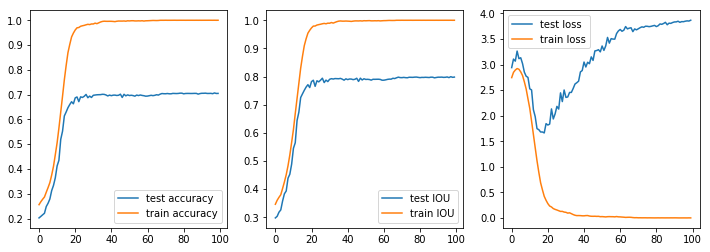

---------------------------------------------------------------------------------------------------- 

Train accuracy:1.000
Test accuracy:0.711
Train IOU:1.000
Test IOU:0.801
Train loss loss:0.002
Test loss loss:1.895


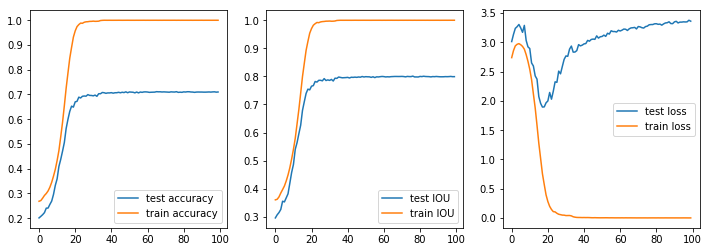

---------------------------------------------------------------------------------------------------- 

Train accuracy:1.000
Test accuracy:0.713
Train IOU:1.000
Test IOU:0.804
Train loss loss:0.003
Test loss loss:2.033


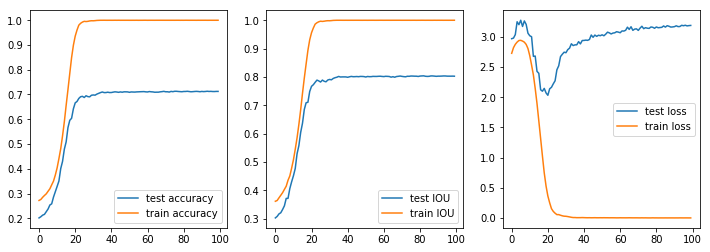

---------------------------------------------------------------------------------------------------- 



In [11]:
f = stats(txtBN_tst, txtBN_trn, ephocs=100, params=[50, 100, 150])

## Img BN

Adding Batch Normalization over the image model

In [12]:
imgBN_tst, imgBN_trn = [], []
num_hiddens=[50, 100, 150]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'imgBN_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=testset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        bnorm=True,
        Urnn_norm=False, 
        Uatt_norm=True, 
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)

    tst, trn = m.train(trainset, testset, ephocs_num=100)
    imgBN_tst.append(tst)
    imgBN_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

params_dir: ../data/training/models/All/unorder1_RL/EXP/imgBN__50
num_hidden: 50
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
batch:0 ;gs:1 ;lr:0.050 ;loss:2.629 ;acc:0.375 ;iou:0.455 ;time: 0:00:01
batch:50 ;gs:51 ;lr:0.050 ;loss:2.707 ;acc:0.295 ;iou:0.375 ;time: 0:00:16
batch:100 ;gs:101 ;lr:0.050 ;loss:2.755 ;acc:0.230 ;iou:0.315 ;time: 0:00:31
batch:150 ;gs:151 ;lr:0.050 ;loss:2.675 ;acc:0.230 ;iou:0.345 ;time: 0:00:45
batch:200 ;gs:201 ;lr:0.050 ;loss:2.664 ;acc:0.220 ;iou:0.350 ;time: 0:01:00
batch:250 ;gs:251 ;lr:0.050 ;loss:2.676 ;acc:0.255 ;iou:0.350 ;time: 0:01:12

*Train loss: 2.701 ;Train accuracy: 0.243 ;Train IOU: 0.340 ;Time: 0:01:25 

Testing, ephoc: 0
batch: 0 ;loss: 2.746 ;acc: 0.180 ;iou_acc: 0.255 ;time: 0:01:25
batch: 50 ;loss: 2.737 ;acc: 0.180 ;iou_acc: 0.305 ;time: 0:01:33
batch: 100 ;loss: 2.745 ;acc: 0.205 ;iou_acc: 0.285 ;time: 0:01:41
batch: 150 ;loss

batch:150 ;gs:2230 ;lr:0.050 ;loss:2.641 ;acc:0.285 ;iou:0.375 ;time: 0:00:40
batch:200 ;gs:2280 ;lr:0.050 ;loss:2.542 ;acc:0.300 ;iou:0.355 ;time: 0:00:53
batch:250 ;gs:2330 ;lr:0.050 ;loss:2.770 ;acc:0.200 ;iou:0.275 ;time: 0:01:07

*Train loss: 2.661 ;Train accuracy: 0.284 ;Train IOU: 0.373 ;Time: 0:01:19 

Testing, ephoc: 7
batch: 0 ;loss: 2.761 ;acc: 0.195 ;iou_acc: 0.260 ;time: 0:01:20
batch: 50 ;loss: 2.724 ;acc: 0.270 ;iou_acc: 0.330 ;time: 0:01:28
batch: 100 ;loss: 2.733 ;acc: 0.225 ;iou_acc: 0.320 ;time: 0:01:36
batch: 150 ;loss: 2.727 ;acc: 0.175 ;iou_acc: 0.255 ;time: 0:01:45
batch: 200 ;loss: 2.767 ;acc: 0.215 ;iou_acc: 0.315 ;time: 0:01:53
batch: 250 ;loss: 2.706 ;acc: 0.175 ;iou_acc: 0.300 ;time: 0:02:01

*Test loss: 2.725 ;Test accuracy 0.196 ;Test IOU: 0.294 ;Time: 0:02:09
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.677 ;acc:0.275 ;iou:0.335 ;time: 0:00:00
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.701 ;acc:0.250 ;iou:0.340 ;time: 0:00:14
batch:100 ;gs:2477 ;lr:0.050 ;

batch: 150 ;loss: 2.719 ;acc: 0.185 ;iou_acc: 0.285 ;time: 0:01:55
batch: 200 ;loss: 2.795 ;acc: 0.180 ;iou_acc: 0.250 ;time: 0:02:04
batch: 250 ;loss: 2.720 ;acc: 0.160 ;iou_acc: 0.300 ;time: 0:02:12

*Test loss: 2.735 ;Test accuracy 0.195 ;Test IOU: 0.295 ;Time: 0:02:20
Train, ephoc: 15
batch:0 ;gs:4456 ;lr:0.050 ;loss:2.624 ;acc:0.295 ;iou:0.350 ;time: 0:00:00
batch:50 ;gs:4506 ;lr:0.050 ;loss:2.530 ;acc:0.350 ;iou:0.465 ;time: 0:00:15
batch:100 ;gs:4556 ;lr:0.050 ;loss:2.623 ;acc:0.340 ;iou:0.455 ;time: 0:00:28
batch:150 ;gs:4606 ;lr:0.050 ;loss:2.577 ;acc:0.315 ;iou:0.425 ;time: 0:00:42
batch:200 ;gs:4656 ;lr:0.050 ;loss:2.598 ;acc:0.300 ;iou:0.380 ;time: 0:00:57
batch:250 ;gs:4706 ;lr:0.050 ;loss:2.646 ;acc:0.270 ;iou:0.375 ;time: 0:01:12

*Train loss: 2.601 ;Train accuracy: 0.308 ;Train IOU: 0.394 ;Time: 0:01:26 

Testing, ephoc: 15
batch: 0 ;loss: 2.757 ;acc: 0.150 ;iou_acc: 0.285 ;time: 0:01:26
batch: 50 ;loss: 2.737 ;acc: 0.200 ;iou_acc: 0.305 ;time: 0:01:35
batch: 100 ;loss:

batch:100 ;gs:6635 ;lr:0.050 ;loss:2.568 ;acc:0.295 ;iou:0.385 ;time: 0:00:29
batch:150 ;gs:6685 ;lr:0.050 ;loss:2.676 ;acc:0.260 ;iou:0.375 ;time: 0:00:42
batch:200 ;gs:6735 ;lr:0.050 ;loss:2.470 ;acc:0.305 ;iou:0.400 ;time: 0:00:58
batch:250 ;gs:6785 ;lr:0.050 ;loss:2.605 ;acc:0.305 ;iou:0.390 ;time: 0:01:11

*Train loss: 2.584 ;Train accuracy: 0.313 ;Train IOU: 0.401 ;Time: 0:01:24 

Testing, ephoc: 22
batch: 0 ;loss: 2.752 ;acc: 0.170 ;iou_acc: 0.245 ;time: 0:01:24
batch: 50 ;loss: 2.742 ;acc: 0.225 ;iou_acc: 0.320 ;time: 0:01:32
batch: 100 ;loss: 2.736 ;acc: 0.230 ;iou_acc: 0.345 ;time: 0:01:41
batch: 150 ;loss: 2.726 ;acc: 0.180 ;iou_acc: 0.255 ;time: 0:01:49
batch: 200 ;loss: 2.792 ;acc: 0.170 ;iou_acc: 0.265 ;time: 0:01:58
batch: 250 ;loss: 2.711 ;acc: 0.200 ;iou_acc: 0.345 ;time: 0:02:08

*Test loss: 2.734 ;Test accuracy 0.195 ;Test IOU: 0.297 ;Time: 0:02:16
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:2.579 ;acc:0.320 ;iou:0.385 ;time: 0:00:00
batch:50 ;gs:6882 ;lr:0.050

batch: 100 ;loss: 2.730 ;acc: 0.200 ;iou_acc: 0.285 ;time: 0:01:46
batch: 150 ;loss: 2.711 ;acc: 0.200 ;iou_acc: 0.300 ;time: 0:01:56
batch: 200 ;loss: 2.772 ;acc: 0.210 ;iou_acc: 0.290 ;time: 0:02:04
batch: 250 ;loss: 2.692 ;acc: 0.225 ;iou_acc: 0.325 ;time: 0:02:12

*Test loss: 2.730 ;Test accuracy 0.198 ;Test IOU: 0.300 ;Time: 0:02:19
Train, ephoc: 30
batch:0 ;gs:8911 ;lr:0.050 ;loss:2.567 ;acc:0.315 ;iou:0.410 ;time: 0:00:00
batch:50 ;gs:8961 ;lr:0.050 ;loss:2.597 ;acc:0.315 ;iou:0.400 ;time: 0:00:14
batch:100 ;gs:9011 ;lr:0.050 ;loss:2.564 ;acc:0.370 ;iou:0.445 ;time: 0:00:27
batch:150 ;gs:9061 ;lr:0.050 ;loss:2.535 ;acc:0.340 ;iou:0.435 ;time: 0:00:40
batch:200 ;gs:9111 ;lr:0.050 ;loss:2.538 ;acc:0.335 ;iou:0.435 ;time: 0:00:53
batch:250 ;gs:9161 ;lr:0.050 ;loss:2.551 ;acc:0.325 ;iou:0.400 ;time: 0:01:07

*Train loss: 2.569 ;Train accuracy: 0.327 ;Train IOU: 0.415 ;Time: 0:01:21 

Testing, ephoc: 30
batch: 0 ;loss: 2.754 ;acc: 0.175 ;iou_acc: 0.265 ;time: 0:01:22
batch: 50 ;loss:

batch:50 ;gs:11040 ;lr:0.045 ;loss:2.393 ;acc:0.425 ;iou:0.500 ;time: 0:00:14
batch:100 ;gs:11090 ;lr:0.045 ;loss:2.583 ;acc:0.370 ;iou:0.475 ;time: 0:00:27
batch:150 ;gs:11140 ;lr:0.045 ;loss:2.437 ;acc:0.435 ;iou:0.485 ;time: 0:00:40
batch:200 ;gs:11190 ;lr:0.045 ;loss:2.451 ;acc:0.375 ;iou:0.455 ;time: 0:00:52
batch:250 ;gs:11240 ;lr:0.045 ;loss:2.483 ;acc:0.425 ;iou:0.480 ;time: 0:01:05

*Train loss: 2.431 ;Train accuracy: 0.388 ;Train IOU: 0.476 ;Time: 0:01:18 

Testing, ephoc: 37
batch: 0 ;loss: 2.625 ;acc: 0.270 ;iou_acc: 0.350 ;time: 0:01:18
batch: 50 ;loss: 2.672 ;acc: 0.270 ;iou_acc: 0.395 ;time: 0:01:25
batch: 100 ;loss: 2.675 ;acc: 0.250 ;iou_acc: 0.335 ;time: 0:01:33
batch: 150 ;loss: 2.614 ;acc: 0.285 ;iou_acc: 0.405 ;time: 0:01:41
batch: 200 ;loss: 2.682 ;acc: 0.315 ;iou_acc: 0.385 ;time: 0:01:48
batch: 250 ;loss: 2.630 ;acc: 0.205 ;iou_acc: 0.345 ;time: 0:01:56

*Test loss: 2.636 ;Test accuracy 0.261 ;Test IOU: 0.368 ;Time: 0:02:03
Train, ephoc: 38
batch:0 ;gs:11287 ;lr

batch: 0 ;loss: 2.288 ;acc: 0.360 ;iou_acc: 0.455 ;time: 0:01:19
batch: 50 ;loss: 2.322 ;acc: 0.360 ;iou_acc: 0.475 ;time: 0:01:28
batch: 100 ;loss: 2.468 ;acc: 0.295 ;iou_acc: 0.390 ;time: 0:01:36
batch: 150 ;loss: 2.259 ;acc: 0.385 ;iou_acc: 0.525 ;time: 0:01:44
batch: 200 ;loss: 2.283 ;acc: 0.430 ;iou_acc: 0.515 ;time: 0:01:52
batch: 250 ;loss: 2.287 ;acc: 0.345 ;iou_acc: 0.450 ;time: 0:02:00

*Test loss: 2.312 ;Test accuracy 0.363 ;Test IOU: 0.470 ;Time: 0:02:07
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:1.992 ;acc:0.525 ;iou:0.630 ;time: 0:00:00
batch:50 ;gs:13416 ;lr:0.045 ;loss:1.975 ;acc:0.545 ;iou:0.615 ;time: 0:00:13
batch:100 ;gs:13466 ;lr:0.045 ;loss:1.956 ;acc:0.460 ;iou:0.550 ;time: 0:00:26
batch:150 ;gs:13516 ;lr:0.045 ;loss:2.049 ;acc:0.510 ;iou:0.570 ;time: 0:00:40
batch:200 ;gs:13566 ;lr:0.045 ;loss:1.829 ;acc:0.585 ;iou:0.630 ;time: 0:00:54
batch:250 ;gs:13616 ;lr:0.045 ;loss:1.991 ;acc:0.525 ;iou:0.585 ;time: 0:01:07

*Train loss: 1.992 ;Train accuracy: 0.51

batch:0 ;gs:15445 ;lr:0.045 ;loss:1.611 ;acc:0.635 ;iou:0.685 ;time: 0:00:00
batch:50 ;gs:15495 ;lr:0.045 ;loss:1.580 ;acc:0.640 ;iou:0.685 ;time: 0:00:14
batch:100 ;gs:15545 ;lr:0.045 ;loss:1.858 ;acc:0.555 ;iou:0.635 ;time: 0:00:28
batch:150 ;gs:15595 ;lr:0.045 ;loss:1.906 ;acc:0.565 ;iou:0.650 ;time: 0:00:41
batch:200 ;gs:15645 ;lr:0.045 ;loss:1.823 ;acc:0.565 ;iou:0.630 ;time: 0:00:54
batch:250 ;gs:15695 ;lr:0.045 ;loss:1.912 ;acc:0.530 ;iou:0.625 ;time: 0:01:08

*Train loss: 1.779 ;Train accuracy: 0.580 ;Train IOU: 0.653 ;Time: 0:01:21 

Testing, ephoc: 52
batch: 0 ;loss: 2.161 ;acc: 0.365 ;iou_acc: 0.455 ;time: 0:01:21
batch: 50 ;loss: 2.161 ;acc: 0.400 ;iou_acc: 0.505 ;time: 0:01:29
batch: 100 ;loss: 2.268 ;acc: 0.325 ;iou_acc: 0.475 ;time: 0:01:37
batch: 150 ;loss: 2.152 ;acc: 0.440 ;iou_acc: 0.540 ;time: 0:01:44
batch: 200 ;loss: 2.094 ;acc: 0.505 ;iou_acc: 0.565 ;time: 0:01:52
batch: 250 ;loss: 2.186 ;acc: 0.400 ;iou_acc: 0.505 ;time: 0:02:01

*Test loss: 2.166 ;Test accuracy


*Train loss: 1.576 ;Train accuracy: 0.645 ;Train IOU: 0.713 ;Time: 0:01:25 

Testing, ephoc: 59
batch: 0 ;loss: 2.150 ;acc: 0.455 ;iou_acc: 0.550 ;time: 0:01:26
batch: 50 ;loss: 2.117 ;acc: 0.480 ;iou_acc: 0.595 ;time: 0:01:35
batch: 100 ;loss: 2.212 ;acc: 0.450 ;iou_acc: 0.575 ;time: 0:01:43
batch: 150 ;loss: 2.119 ;acc: 0.465 ;iou_acc: 0.550 ;time: 0:01:52
batch: 200 ;loss: 2.100 ;acc: 0.470 ;iou_acc: 0.555 ;time: 0:02:00
batch: 250 ;loss: 2.173 ;acc: 0.435 ;iou_acc: 0.550 ;time: 0:02:09

*Test loss: 2.123 ;Test accuracy 0.448 ;Test IOU: 0.554 ;Time: 0:02:16
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:1.624 ;acc:0.625 ;iou:0.705 ;time: 0:00:01
batch:50 ;gs:17871 ;lr:0.045 ;loss:1.574 ;acc:0.660 ;iou:0.730 ;time: 0:00:16
batch:100 ;gs:17921 ;lr:0.045 ;loss:1.410 ;acc:0.670 ;iou:0.745 ;time: 0:00:31
batch:150 ;gs:17971 ;lr:0.045 ;loss:1.653 ;acc:0.600 ;iou:0.655 ;time: 0:00:47
batch:200 ;gs:18021 ;lr:0.045 ;loss:1.571 ;acc:0.680 ;iou:0.740 ;time: 0:01:02
batch:250 ;gs:18071 ;lr


*Test loss: 2.079 ;Test accuracy 0.472 ;Test IOU: 0.577 ;Time: 0:02:12
Train, ephoc: 67
batch:0 ;gs:19900 ;lr:0.045 ;loss:1.316 ;acc:0.720 ;iou:0.785 ;time: 0:00:00
batch:50 ;gs:19950 ;lr:0.045 ;loss:1.488 ;acc:0.665 ;iou:0.720 ;time: 0:00:14
batch:100 ;gs:20000 ;lr:0.045 ;loss:1.498 ;acc:0.655 ;iou:0.710 ;time: 0:00:28
batch:150 ;gs:20050 ;lr:0.040 ;loss:1.442 ;acc:0.690 ;iou:0.760 ;time: 0:00:42
batch:200 ;gs:20100 ;lr:0.040 ;loss:1.268 ;acc:0.770 ;iou:0.820 ;time: 0:00:57
batch:250 ;gs:20150 ;lr:0.040 ;loss:1.328 ;acc:0.750 ;iou:0.805 ;time: 0:01:10

*Train loss: 1.400 ;Train accuracy: 0.699 ;Train IOU: 0.758 ;Time: 0:01:24 

Testing, ephoc: 67
batch: 0 ;loss: 2.115 ;acc: 0.450 ;iou_acc: 0.560 ;time: 0:01:24
batch: 50 ;loss: 2.147 ;acc: 0.495 ;iou_acc: 0.570 ;time: 0:01:32
batch: 100 ;loss: 2.236 ;acc: 0.445 ;iou_acc: 0.555 ;time: 0:01:40
batch: 150 ;loss: 2.128 ;acc: 0.450 ;iou_acc: 0.535 ;time: 0:01:49
batch: 200 ;loss: 2.081 ;acc: 0.495 ;iou_acc: 0.580 ;time: 0:01:58
batch: 250 

batch:200 ;gs:22179 ;lr:0.040 ;loss:1.434 ;acc:0.705 ;iou:0.750 ;time: 0:00:52
batch:250 ;gs:22229 ;lr:0.040 ;loss:1.221 ;acc:0.745 ;iou:0.800 ;time: 0:01:05

*Train loss: 1.281 ;Train accuracy: 0.734 ;Train IOU: 0.788 ;Time: 0:01:18 

Testing, ephoc: 74
batch: 0 ;loss: 1.973 ;acc: 0.485 ;iou_acc: 0.595 ;time: 0:01:18
batch: 50 ;loss: 2.210 ;acc: 0.480 ;iou_acc: 0.585 ;time: 0:01:25
batch: 100 ;loss: 2.266 ;acc: 0.465 ;iou_acc: 0.570 ;time: 0:01:32
batch: 150 ;loss: 2.081 ;acc: 0.515 ;iou_acc: 0.585 ;time: 0:01:40
batch: 200 ;loss: 2.021 ;acc: 0.470 ;iou_acc: 0.560 ;time: 0:01:48
batch: 250 ;loss: 2.185 ;acc: 0.435 ;iou_acc: 0.530 ;time: 0:01:55

*Test loss: 2.095 ;Test accuracy 0.480 ;Test IOU: 0.585 ;Time: 0:02:02
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:1.269 ;acc:0.705 ;iou:0.745 ;time: 0:00:01
batch:50 ;gs:22326 ;lr:0.040 ;loss:1.157 ;acc:0.760 ;iou:0.820 ;time: 0:00:14
batch:100 ;gs:22376 ;lr:0.040 ;loss:1.286 ;acc:0.760 ;iou:0.795 ;time: 0:00:26
batch:150 ;gs:22426 ;lr

batch: 150 ;loss: 2.090 ;acc: 0.510 ;iou_acc: 0.585 ;time: 0:01:52
batch: 200 ;loss: 2.099 ;acc: 0.520 ;iou_acc: 0.585 ;time: 0:02:01
batch: 250 ;loss: 2.162 ;acc: 0.495 ;iou_acc: 0.580 ;time: 0:02:10

*Test loss: 2.096 ;Test accuracy 0.489 ;Test IOU: 0.594 ;Time: 0:02:19
Train, ephoc: 82
batch:0 ;gs:24355 ;lr:0.040 ;loss:1.268 ;acc:0.735 ;iou:0.760 ;time: 0:00:00
batch:50 ;gs:24405 ;lr:0.040 ;loss:1.072 ;acc:0.800 ;iou:0.845 ;time: 0:00:14
batch:100 ;gs:24455 ;lr:0.040 ;loss:1.076 ;acc:0.770 ;iou:0.840 ;time: 0:00:29
batch:150 ;gs:24505 ;lr:0.040 ;loss:1.227 ;acc:0.735 ;iou:0.775 ;time: 0:00:44
batch:200 ;gs:24555 ;lr:0.040 ;loss:1.021 ;acc:0.815 ;iou:0.860 ;time: 0:00:59
batch:250 ;gs:24605 ;lr:0.040 ;loss:1.229 ;acc:0.740 ;iou:0.800 ;time: 0:01:13

*Train loss: 1.168 ;Train accuracy: 0.765 ;Train IOU: 0.813 ;Time: 0:01:27 

Testing, ephoc: 82
batch: 0 ;loss: 2.026 ;acc: 0.520 ;iou_acc: 0.620 ;time: 0:01:27
batch: 50 ;loss: 2.234 ;acc: 0.480 ;iou_acc: 0.600 ;time: 0:01:37
batch: 100 

batch:100 ;gs:26534 ;lr:0.040 ;loss:1.161 ;acc:0.775 ;iou:0.815 ;time: 0:00:29
batch:150 ;gs:26584 ;lr:0.040 ;loss:0.886 ;acc:0.870 ;iou:0.890 ;time: 0:00:43
batch:200 ;gs:26634 ;lr:0.040 ;loss:1.096 ;acc:0.780 ;iou:0.815 ;time: 0:00:56
batch:250 ;gs:26684 ;lr:0.040 ;loss:1.125 ;acc:0.805 ;iou:0.845 ;time: 0:01:11

*Train loss: 1.087 ;Train accuracy: 0.786 ;Train IOU: 0.829 ;Time: 0:01:23 

Testing, ephoc: 89
batch: 0 ;loss: 2.128 ;acc: 0.505 ;iou_acc: 0.605 ;time: 0:01:23
batch: 50 ;loss: 2.325 ;acc: 0.505 ;iou_acc: 0.605 ;time: 0:01:32
batch: 100 ;loss: 2.378 ;acc: 0.455 ;iou_acc: 0.565 ;time: 0:01:40
batch: 150 ;loss: 2.375 ;acc: 0.485 ;iou_acc: 0.585 ;time: 0:01:48
batch: 200 ;loss: 2.160 ;acc: 0.535 ;iou_acc: 0.585 ;time: 0:01:56
batch: 250 ;loss: 2.455 ;acc: 0.420 ;iou_acc: 0.530 ;time: 0:02:04

*Test loss: 2.208 ;Test accuracy 0.494 ;Test IOU: 0.598 ;Time: 0:02:12
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:1.138 ;acc:0.770 ;iou:0.815 ;time: 0:00:00
batch:50 ;gs:26781 ;lr

batch: 50 ;loss: 2.327 ;acc: 0.525 ;iou_acc: 0.605 ;time: 0:01:24
batch: 100 ;loss: 2.633 ;acc: 0.425 ;iou_acc: 0.545 ;time: 0:01:31
batch: 150 ;loss: 2.383 ;acc: 0.495 ;iou_acc: 0.595 ;time: 0:01:39
batch: 200 ;loss: 2.267 ;acc: 0.485 ;iou_acc: 0.580 ;time: 0:01:47
batch: 250 ;loss: 2.441 ;acc: 0.455 ;iou_acc: 0.565 ;time: 0:01:54

*Test loss: 2.279 ;Test accuracy 0.493 ;Test IOU: 0.599 ;Time: 0:02:01
Train, ephoc: 97
batch:0 ;gs:28810 ;lr:0.040 ;loss:0.962 ;acc:0.810 ;iou:0.865 ;time: 0:00:01
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.923 ;acc:0.840 ;iou:0.870 ;time: 0:00:14
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.943 ;acc:0.850 ;iou:0.885 ;time: 0:00:27
batch:150 ;gs:28960 ;lr:0.040 ;loss:1.102 ;acc:0.755 ;iou:0.785 ;time: 0:00:40
batch:200 ;gs:29010 ;lr:0.040 ;loss:1.118 ;acc:0.790 ;iou:0.850 ;time: 0:00:53
batch:250 ;gs:29060 ;lr:0.040 ;loss:1.021 ;acc:0.825 ;iou:0.855 ;time: 0:01:05

*Train loss: 0.994 ;Train accuracy: 0.811 ;Train IOU: 0.850 ;Time: 0:01:17 

Testing, ephoc: 97
batch: 0 

batch: 0 ;loss: 2.742 ;acc: 0.185 ;iou_acc: 0.275 ;time: 0:01:18
batch: 50 ;loss: 2.735 ;acc: 0.190 ;iou_acc: 0.290 ;time: 0:01:25
batch: 100 ;loss: 2.747 ;acc: 0.175 ;iou_acc: 0.255 ;time: 0:01:33
batch: 150 ;loss: 2.705 ;acc: 0.245 ;iou_acc: 0.360 ;time: 0:01:40
batch: 200 ;loss: 2.780 ;acc: 0.160 ;iou_acc: 0.245 ;time: 0:01:48
batch: 250 ;loss: 2.690 ;acc: 0.180 ;iou_acc: 0.270 ;time: 0:01:55

*Test loss: 2.723 ;Test accuracy 0.194 ;Test IOU: 0.292 ;Time: 0:02:02
Train, ephoc: 4
batch:0 ;gs:1189 ;lr:0.050 ;loss:2.652 ;acc:0.235 ;iou:0.320 ;time: 0:00:00
batch:50 ;gs:1239 ;lr:0.050 ;loss:2.630 ;acc:0.280 ;iou:0.395 ;time: 0:00:14
batch:100 ;gs:1289 ;lr:0.050 ;loss:2.725 ;acc:0.220 ;iou:0.330 ;time: 0:00:27
batch:150 ;gs:1339 ;lr:0.050 ;loss:2.628 ;acc:0.330 ;iou:0.410 ;time: 0:00:39
batch:200 ;gs:1389 ;lr:0.050 ;loss:2.648 ;acc:0.285 ;iou:0.400 ;time: 0:00:52
batch:250 ;gs:1439 ;lr:0.050 ;loss:2.595 ;acc:0.300 ;iou:0.370 ;time: 0:01:04

*Train loss: 2.687 ;Train accuracy: 0.266 ;Trai

batch:0 ;gs:3268 ;lr:0.050 ;loss:2.617 ;acc:0.320 ;iou:0.380 ;time: 0:00:00
batch:50 ;gs:3318 ;lr:0.050 ;loss:2.671 ;acc:0.300 ;iou:0.395 ;time: 0:00:12
batch:100 ;gs:3368 ;lr:0.050 ;loss:2.647 ;acc:0.310 ;iou:0.415 ;time: 0:00:26
batch:150 ;gs:3418 ;lr:0.050 ;loss:2.590 ;acc:0.290 ;iou:0.370 ;time: 0:00:38
batch:200 ;gs:3468 ;lr:0.050 ;loss:2.524 ;acc:0.370 ;iou:0.475 ;time: 0:00:51
batch:250 ;gs:3518 ;lr:0.050 ;loss:2.694 ;acc:0.310 ;iou:0.400 ;time: 0:01:04

*Train loss: 2.608 ;Train accuracy: 0.316 ;Train IOU: 0.402 ;Time: 0:01:16 

Testing, ephoc: 11
batch: 0 ;loss: 2.746 ;acc: 0.195 ;iou_acc: 0.270 ;time: 0:01:16
batch: 50 ;loss: 2.741 ;acc: 0.175 ;iou_acc: 0.290 ;time: 0:01:24
batch: 100 ;loss: 2.765 ;acc: 0.195 ;iou_acc: 0.280 ;time: 0:01:31
batch: 150 ;loss: 2.714 ;acc: 0.210 ;iou_acc: 0.310 ;time: 0:01:39
batch: 200 ;loss: 2.796 ;acc: 0.185 ;iou_acc: 0.300 ;time: 0:01:47
batch: 250 ;loss: 2.696 ;acc: 0.205 ;iou_acc: 0.290 ;time: 0:01:55

*Test loss: 2.732 ;Test accuracy 0.194

batch: 0 ;loss: 2.757 ;acc: 0.180 ;iou_acc: 0.295 ;time: 0:01:19
batch: 50 ;loss: 2.745 ;acc: 0.190 ;iou_acc: 0.305 ;time: 0:01:27
batch: 100 ;loss: 2.765 ;acc: 0.195 ;iou_acc: 0.295 ;time: 0:01:35
batch: 150 ;loss: 2.710 ;acc: 0.260 ;iou_acc: 0.335 ;time: 0:01:43
batch: 200 ;loss: 2.804 ;acc: 0.165 ;iou_acc: 0.275 ;time: 0:01:50
batch: 250 ;loss: 2.704 ;acc: 0.165 ;iou_acc: 0.265 ;time: 0:01:58

*Test loss: 2.735 ;Test accuracy 0.194 ;Test IOU: 0.297 ;Time: 0:02:05
Train, ephoc: 19
batch:0 ;gs:5644 ;lr:0.050 ;loss:2.526 ;acc:0.320 ;iou:0.400 ;time: 0:00:01
batch:50 ;gs:5694 ;lr:0.050 ;loss:2.559 ;acc:0.355 ;iou:0.430 ;time: 0:00:13
batch:100 ;gs:5744 ;lr:0.050 ;loss:2.607 ;acc:0.300 ;iou:0.400 ;time: 0:00:26
batch:150 ;gs:5794 ;lr:0.050 ;loss:2.563 ;acc:0.345 ;iou:0.455 ;time: 0:00:40
batch:200 ;gs:5844 ;lr:0.050 ;loss:2.537 ;acc:0.320 ;iou:0.425 ;time: 0:00:53
batch:250 ;gs:5894 ;lr:0.050 ;loss:2.620 ;acc:0.320 ;iou:0.425 ;time: 0:01:06

*Train loss: 2.576 ;Train accuracy: 0.325 ;Tra

batch:0 ;gs:7723 ;lr:0.050 ;loss:2.570 ;acc:0.375 ;iou:0.470 ;time: 0:00:00
batch:50 ;gs:7773 ;lr:0.050 ;loss:2.595 ;acc:0.315 ;iou:0.390 ;time: 0:00:14
batch:100 ;gs:7823 ;lr:0.050 ;loss:2.507 ;acc:0.315 ;iou:0.395 ;time: 0:00:27
batch:150 ;gs:7873 ;lr:0.050 ;loss:2.536 ;acc:0.335 ;iou:0.410 ;time: 0:00:41
batch:200 ;gs:7923 ;lr:0.050 ;loss:2.541 ;acc:0.335 ;iou:0.490 ;time: 0:00:55
batch:250 ;gs:7973 ;lr:0.050 ;loss:2.467 ;acc:0.325 ;iou:0.455 ;time: 0:01:09

*Train loss: 2.562 ;Train accuracy: 0.335 ;Train IOU: 0.421 ;Time: 0:01:21 

Testing, ephoc: 26
batch: 0 ;loss: 2.758 ;acc: 0.160 ;iou_acc: 0.255 ;time: 0:01:22
batch: 50 ;loss: 2.740 ;acc: 0.160 ;iou_acc: 0.290 ;time: 0:01:30
batch: 100 ;loss: 2.757 ;acc: 0.205 ;iou_acc: 0.280 ;time: 0:01:39
batch: 150 ;loss: 2.702 ;acc: 0.215 ;iou_acc: 0.285 ;time: 0:01:47
batch: 200 ;loss: 2.790 ;acc: 0.210 ;iou_acc: 0.285 ;time: 0:01:56
batch: 250 ;loss: 2.701 ;acc: 0.160 ;iou_acc: 0.240 ;time: 0:02:04

*Test loss: 2.732 ;Test accuracy 0.198

batch: 0 ;loss: 2.668 ;acc: 0.290 ;iou_acc: 0.390 ;time: 0:01:22
batch: 50 ;loss: 2.753 ;acc: 0.180 ;iou_acc: 0.295 ;time: 0:01:30
batch: 100 ;loss: 2.724 ;acc: 0.210 ;iou_acc: 0.305 ;time: 0:01:39
batch: 150 ;loss: 2.646 ;acc: 0.280 ;iou_acc: 0.390 ;time: 0:01:48
batch: 200 ;loss: 2.701 ;acc: 0.230 ;iou_acc: 0.310 ;time: 0:01:56
batch: 250 ;loss: 2.678 ;acc: 0.195 ;iou_acc: 0.295 ;time: 0:02:05

*Test loss: 2.678 ;Test accuracy 0.240 ;Test IOU: 0.350 ;Time: 0:02:13
Train, ephoc: 34
batch:0 ;gs:10099 ;lr:0.045 ;loss:2.335 ;acc:0.480 ;iou:0.530 ;time: 0:00:01
batch:50 ;gs:10149 ;lr:0.045 ;loss:2.350 ;acc:0.430 ;iou:0.515 ;time: 0:00:15
batch:100 ;gs:10199 ;lr:0.045 ;loss:2.432 ;acc:0.360 ;iou:0.500 ;time: 0:00:28
batch:150 ;gs:10249 ;lr:0.045 ;loss:2.510 ;acc:0.375 ;iou:0.455 ;time: 0:00:44
batch:200 ;gs:10299 ;lr:0.045 ;loss:2.346 ;acc:0.445 ;iou:0.535 ;time: 0:01:00
batch:250 ;gs:10349 ;lr:0.045 ;loss:2.534 ;acc:0.335 ;iou:0.460 ;time: 0:01:13

*Train loss: 2.396 ;Train accuracy: 0.40

batch:0 ;gs:12178 ;lr:0.045 ;loss:1.878 ;acc:0.560 ;iou:0.650 ;time: 0:00:00
batch:50 ;gs:12228 ;lr:0.045 ;loss:2.020 ;acc:0.535 ;iou:0.600 ;time: 0:00:16
batch:100 ;gs:12278 ;lr:0.045 ;loss:2.066 ;acc:0.495 ;iou:0.560 ;time: 0:00:30
batch:150 ;gs:12328 ;lr:0.045 ;loss:2.140 ;acc:0.475 ;iou:0.550 ;time: 0:00:44
batch:200 ;gs:12378 ;lr:0.045 ;loss:2.010 ;acc:0.500 ;iou:0.560 ;time: 0:00:57
batch:250 ;gs:12428 ;lr:0.045 ;loss:1.983 ;acc:0.555 ;iou:0.605 ;time: 0:01:11

*Train loss: 2.004 ;Train accuracy: 0.518 ;Train IOU: 0.597 ;Time: 0:01:24 

Testing, ephoc: 41
batch: 0 ;loss: 2.219 ;acc: 0.400 ;iou_acc: 0.510 ;time: 0:01:24
batch: 50 ;loss: 2.392 ;acc: 0.365 ;iou_acc: 0.440 ;time: 0:01:32
batch: 100 ;loss: 2.422 ;acc: 0.340 ;iou_acc: 0.435 ;time: 0:01:40
batch: 150 ;loss: 2.345 ;acc: 0.350 ;iou_acc: 0.470 ;time: 0:01:48
batch: 200 ;loss: 2.251 ;acc: 0.375 ;iou_acc: 0.465 ;time: 0:01:56
batch: 250 ;loss: 2.332 ;acc: 0.355 ;iou_acc: 0.455 ;time: 0:02:04

*Test loss: 2.323 ;Test accuracy


*Train loss: 1.785 ;Train accuracy: 0.582 ;Train IOU: 0.657 ;Time: 0:01:21 

Testing, ephoc: 48
batch: 0 ;loss: 2.098 ;acc: 0.445 ;iou_acc: 0.540 ;time: 0:01:22
batch: 50 ;loss: 2.281 ;acc: 0.405 ;iou_acc: 0.500 ;time: 0:01:29
batch: 100 ;loss: 2.304 ;acc: 0.390 ;iou_acc: 0.500 ;time: 0:01:37
batch: 150 ;loss: 2.218 ;acc: 0.430 ;iou_acc: 0.535 ;time: 0:01:45
batch: 200 ;loss: 2.141 ;acc: 0.450 ;iou_acc: 0.500 ;time: 0:01:53
batch: 250 ;loss: 2.152 ;acc: 0.415 ;iou_acc: 0.505 ;time: 0:02:03

*Test loss: 2.172 ;Test accuracy 0.414 ;Test IOU: 0.516 ;Time: 0:02:11
Train, ephoc: 49
batch:0 ;gs:14554 ;lr:0.045 ;loss:1.659 ;acc:0.675 ;iou:0.770 ;time: 0:00:00
batch:50 ;gs:14604 ;lr:0.045 ;loss:1.733 ;acc:0.570 ;iou:0.665 ;time: 0:00:13
batch:100 ;gs:14654 ;lr:0.045 ;loss:1.769 ;acc:0.595 ;iou:0.645 ;time: 0:00:26
batch:150 ;gs:14704 ;lr:0.045 ;loss:1.823 ;acc:0.605 ;iou:0.675 ;time: 0:00:39
batch:200 ;gs:14754 ;lr:0.045 ;loss:1.837 ;acc:0.570 ;iou:0.645 ;time: 0:00:52
batch:250 ;gs:14804 ;lr


*Test loss: 2.093 ;Test accuracy 0.448 ;Test IOU: 0.552 ;Time: 0:02:05
Train, ephoc: 56
batch:0 ;gs:16633 ;lr:0.045 ;loss:1.515 ;acc:0.665 ;iou:0.710 ;time: 0:00:00
batch:50 ;gs:16683 ;lr:0.045 ;loss:1.625 ;acc:0.575 ;iou:0.655 ;time: 0:00:13
batch:100 ;gs:16733 ;lr:0.045 ;loss:1.450 ;acc:0.675 ;iou:0.715 ;time: 0:00:26
batch:150 ;gs:16783 ;lr:0.045 ;loss:1.398 ;acc:0.735 ;iou:0.775 ;time: 0:00:40
batch:200 ;gs:16833 ;lr:0.045 ;loss:1.690 ;acc:0.625 ;iou:0.700 ;time: 0:00:54
batch:250 ;gs:16883 ;lr:0.045 ;loss:1.583 ;acc:0.670 ;iou:0.720 ;time: 0:01:08

*Train loss: 1.546 ;Train accuracy: 0.660 ;Train IOU: 0.726 ;Time: 0:01:20 

Testing, ephoc: 56
batch: 0 ;loss: 2.031 ;acc: 0.440 ;iou_acc: 0.555 ;time: 0:01:20
batch: 50 ;loss: 2.192 ;acc: 0.430 ;iou_acc: 0.505 ;time: 0:01:28
batch: 100 ;loss: 2.159 ;acc: 0.480 ;iou_acc: 0.570 ;time: 0:01:36
batch: 150 ;loss: 2.152 ;acc: 0.430 ;iou_acc: 0.530 ;time: 0:01:45
batch: 200 ;loss: 2.097 ;acc: 0.475 ;iou_acc: 0.520 ;time: 0:01:52
batch: 250 

batch:200 ;gs:18912 ;lr:0.045 ;loss:1.488 ;acc:0.690 ;iou:0.775 ;time: 0:00:53
batch:250 ;gs:18962 ;lr:0.045 ;loss:1.336 ;acc:0.750 ;iou:0.840 ;time: 0:01:05

*Train loss: 1.391 ;Train accuracy: 0.707 ;Train IOU: 0.764 ;Time: 0:01:18 

Testing, ephoc: 63
batch: 0 ;loss: 1.957 ;acc: 0.530 ;iou_acc: 0.630 ;time: 0:01:18
batch: 50 ;loss: 2.163 ;acc: 0.465 ;iou_acc: 0.540 ;time: 0:01:26
batch: 100 ;loss: 2.226 ;acc: 0.445 ;iou_acc: 0.555 ;time: 0:01:34
batch: 150 ;loss: 2.222 ;acc: 0.440 ;iou_acc: 0.560 ;time: 0:01:42
batch: 200 ;loss: 2.088 ;acc: 0.525 ;iou_acc: 0.600 ;time: 0:01:50
batch: 250 ;loss: 2.245 ;acc: 0.395 ;iou_acc: 0.500 ;time: 0:01:59

*Test loss: 2.068 ;Test accuracy 0.477 ;Test IOU: 0.581 ;Time: 0:02:06
Train, ephoc: 64
batch:0 ;gs:19009 ;lr:0.045 ;loss:1.203 ;acc:0.795 ;iou:0.855 ;time: 0:00:00
batch:50 ;gs:19059 ;lr:0.045 ;loss:1.484 ;acc:0.685 ;iou:0.735 ;time: 0:00:14
batch:100 ;gs:19109 ;lr:0.045 ;loss:1.264 ;acc:0.715 ;iou:0.790 ;time: 0:00:27
batch:150 ;gs:19159 ;lr

batch: 150 ;loss: 2.218 ;acc: 0.450 ;iou_acc: 0.590 ;time: 0:01:45
batch: 200 ;loss: 2.060 ;acc: 0.530 ;iou_acc: 0.630 ;time: 0:01:53
batch: 250 ;loss: 2.265 ;acc: 0.430 ;iou_acc: 0.515 ;time: 0:02:01

*Test loss: 2.086 ;Test accuracy 0.482 ;Test IOU: 0.587 ;Time: 0:02:08
Train, ephoc: 71
batch:0 ;gs:21088 ;lr:0.040 ;loss:1.351 ;acc:0.715 ;iou:0.780 ;time: 0:00:01
batch:50 ;gs:21138 ;lr:0.040 ;loss:1.125 ;acc:0.775 ;iou:0.805 ;time: 0:00:14
batch:100 ;gs:21188 ;lr:0.040 ;loss:1.145 ;acc:0.770 ;iou:0.815 ;time: 0:00:26
batch:150 ;gs:21238 ;lr:0.040 ;loss:1.334 ;acc:0.690 ;iou:0.760 ;time: 0:00:40
batch:200 ;gs:21288 ;lr:0.040 ;loss:1.177 ;acc:0.755 ;iou:0.800 ;time: 0:00:53
batch:250 ;gs:21338 ;lr:0.040 ;loss:1.452 ;acc:0.680 ;iou:0.745 ;time: 0:01:08

*Train loss: 1.223 ;Train accuracy: 0.754 ;Train IOU: 0.804 ;Time: 0:01:20 

Testing, ephoc: 71
batch: 0 ;loss: 1.955 ;acc: 0.510 ;iou_acc: 0.600 ;time: 0:01:21
batch: 50 ;loss: 2.266 ;acc: 0.465 ;iou_acc: 0.540 ;time: 0:01:29
batch: 100 

batch:100 ;gs:23267 ;lr:0.040 ;loss:1.099 ;acc:0.785 ;iou:0.830 ;time: 0:00:26
batch:150 ;gs:23317 ;lr:0.040 ;loss:1.310 ;acc:0.730 ;iou:0.785 ;time: 0:00:40
batch:200 ;gs:23367 ;lr:0.040 ;loss:1.090 ;acc:0.790 ;iou:0.820 ;time: 0:00:55
batch:250 ;gs:23417 ;lr:0.040 ;loss:1.258 ;acc:0.760 ;iou:0.805 ;time: 0:01:09

*Train loss: 1.103 ;Train accuracy: 0.787 ;Train IOU: 0.830 ;Time: 0:01:21 

Testing, ephoc: 78
batch: 0 ;loss: 1.983 ;acc: 0.490 ;iou_acc: 0.600 ;time: 0:01:21
batch: 50 ;loss: 2.388 ;acc: 0.460 ;iou_acc: 0.540 ;time: 0:01:29
batch: 100 ;loss: 2.257 ;acc: 0.460 ;iou_acc: 0.550 ;time: 0:01:38
batch: 150 ;loss: 2.225 ;acc: 0.500 ;iou_acc: 0.605 ;time: 0:01:46
batch: 200 ;loss: 2.060 ;acc: 0.555 ;iou_acc: 0.640 ;time: 0:01:54
batch: 250 ;loss: 2.328 ;acc: 0.455 ;iou_acc: 0.560 ;time: 0:02:02

*Test loss: 2.117 ;Test accuracy 0.490 ;Test IOU: 0.597 ;Time: 0:02:09
Train, ephoc: 79
batch:0 ;gs:23464 ;lr:0.040 ;loss:1.229 ;acc:0.750 ;iou:0.805 ;time: 0:00:00
batch:50 ;gs:23514 ;lr

batch: 50 ;loss: 2.492 ;acc: 0.485 ;iou_acc: 0.555 ;time: 0:01:35
batch: 100 ;loss: 2.353 ;acc: 0.420 ;iou_acc: 0.520 ;time: 0:01:44
batch: 150 ;loss: 2.327 ;acc: 0.450 ;iou_acc: 0.605 ;time: 0:01:53
batch: 200 ;loss: 2.174 ;acc: 0.520 ;iou_acc: 0.605 ;time: 0:02:01
batch: 250 ;loss: 2.361 ;acc: 0.495 ;iou_acc: 0.595 ;time: 0:02:09

*Test loss: 2.198 ;Test accuracy 0.497 ;Test IOU: 0.602 ;Time: 0:02:17
Train, ephoc: 86
batch:0 ;gs:25543 ;lr:0.040 ;loss:1.021 ;acc:0.795 ;iou:0.835 ;time: 0:00:01
batch:50 ;gs:25593 ;lr:0.040 ;loss:0.982 ;acc:0.815 ;iou:0.835 ;time: 0:00:15
batch:100 ;gs:25643 ;lr:0.040 ;loss:1.140 ;acc:0.755 ;iou:0.780 ;time: 0:00:28
batch:150 ;gs:25693 ;lr:0.040 ;loss:1.071 ;acc:0.775 ;iou:0.830 ;time: 0:00:41
batch:200 ;gs:25743 ;lr:0.040 ;loss:0.930 ;acc:0.820 ;iou:0.865 ;time: 0:00:56
batch:250 ;gs:25793 ;lr:0.040 ;loss:0.961 ;acc:0.840 ;iou:0.870 ;time: 0:01:09

*Train loss: 0.991 ;Train accuracy: 0.817 ;Train IOU: 0.855 ;Time: 0:01:22 

Testing, ephoc: 86
batch: 0 

batch:0 ;gs:27622 ;lr:0.040 ;loss:0.820 ;acc:0.870 ;iou:0.900 ;time: 0:00:01
batch:50 ;gs:27672 ;lr:0.040 ;loss:0.831 ;acc:0.850 ;iou:0.875 ;time: 0:00:15
batch:100 ;gs:27722 ;lr:0.040 ;loss:0.763 ;acc:0.875 ;iou:0.895 ;time: 0:00:29
batch:150 ;gs:27772 ;lr:0.040 ;loss:0.972 ;acc:0.790 ;iou:0.840 ;time: 0:00:42
batch:200 ;gs:27822 ;lr:0.040 ;loss:1.049 ;acc:0.770 ;iou:0.795 ;time: 0:00:55
batch:250 ;gs:27872 ;lr:0.040 ;loss:0.917 ;acc:0.780 ;iou:0.850 ;time: 0:01:08

*Train loss: 0.894 ;Train accuracy: 0.840 ;Train IOU: 0.873 ;Time: 0:01:20 

Testing, ephoc: 93
batch: 0 ;loss: 2.088 ;acc: 0.525 ;iou_acc: 0.620 ;time: 0:01:21
batch: 50 ;loss: 2.630 ;acc: 0.465 ;iou_acc: 0.550 ;time: 0:01:28
batch: 100 ;loss: 2.542 ;acc: 0.455 ;iou_acc: 0.555 ;time: 0:01:37
batch: 150 ;loss: 2.460 ;acc: 0.470 ;iou_acc: 0.575 ;time: 0:01:46
batch: 200 ;loss: 2.297 ;acc: 0.535 ;iou_acc: 0.620 ;time: 0:01:55
batch: 250 ;loss: 2.461 ;acc: 0.480 ;iou_acc: 0.580 ;time: 0:02:04

*Test loss: 2.283 ;Test accuracy

batch:0 ;gs:1 ;lr:0.050 ;loss:2.490 ;acc:0.430 ;iou:0.530 ;time: 0:00:01
batch:50 ;gs:51 ;lr:0.050 ;loss:2.673 ;acc:0.285 ;iou:0.395 ;time: 0:00:14
batch:100 ;gs:101 ;lr:0.050 ;loss:2.687 ;acc:0.280 ;iou:0.330 ;time: 0:00:27
batch:150 ;gs:151 ;lr:0.050 ;loss:2.710 ;acc:0.305 ;iou:0.380 ;time: 0:00:40
batch:200 ;gs:201 ;lr:0.050 ;loss:2.669 ;acc:0.300 ;iou:0.380 ;time: 0:00:54
batch:250 ;gs:251 ;lr:0.050 ;loss:2.712 ;acc:0.300 ;iou:0.400 ;time: 0:01:07

*Train loss: 2.680 ;Train accuracy: 0.292 ;Train IOU: 0.382 ;Time: 0:01:19 

Testing, ephoc: 0
batch: 0 ;loss: 2.741 ;acc: 0.215 ;iou_acc: 0.305 ;time: 0:01:20
batch: 50 ;loss: 2.741 ;acc: 0.190 ;iou_acc: 0.320 ;time: 0:01:27
batch: 100 ;loss: 2.749 ;acc: 0.185 ;iou_acc: 0.270 ;time: 0:01:35
batch: 150 ;loss: 2.716 ;acc: 0.180 ;iou_acc: 0.255 ;time: 0:01:43
batch: 200 ;loss: 2.778 ;acc: 0.175 ;iou_acc: 0.290 ;time: 0:01:51
batch: 250 ;loss: 2.696 ;acc: 0.200 ;iou_acc: 0.315 ;time: 0:01:58

*Test loss: 2.724 ;Test accuracy 0.194 ;Test IOU

batch: 0 ;loss: 2.745 ;acc: 0.185 ;iou_acc: 0.270 ;time: 0:01:19
batch: 50 ;loss: 2.736 ;acc: 0.205 ;iou_acc: 0.290 ;time: 0:01:27
batch: 100 ;loss: 2.738 ;acc: 0.250 ;iou_acc: 0.340 ;time: 0:01:35
batch: 150 ;loss: 2.724 ;acc: 0.170 ;iou_acc: 0.245 ;time: 0:01:43
batch: 200 ;loss: 2.777 ;acc: 0.190 ;iou_acc: 0.280 ;time: 0:01:50
batch: 250 ;loss: 2.703 ;acc: 0.220 ;iou_acc: 0.315 ;time: 0:01:58

*Test loss: 2.728 ;Test accuracy 0.194 ;Test IOU: 0.296 ;Time: 0:02:06
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.698 ;acc:0.315 ;iou:0.400 ;time: 0:00:00
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.629 ;acc:0.270 ;iou:0.370 ;time: 0:00:13
batch:100 ;gs:2477 ;lr:0.050 ;loss:2.640 ;acc:0.315 ;iou:0.405 ;time: 0:00:26
batch:150 ;gs:2527 ;lr:0.050 ;loss:2.635 ;acc:0.285 ;iou:0.375 ;time: 0:00:39
batch:200 ;gs:2577 ;lr:0.050 ;loss:2.588 ;acc:0.345 ;iou:0.415 ;time: 0:00:52
batch:250 ;gs:2627 ;lr:0.050 ;loss:2.669 ;acc:0.300 ;iou:0.390 ;time: 0:01:05

*Train loss: 2.627 ;Train accuracy: 0.312 ;Trai

batch:0 ;gs:4456 ;lr:0.050 ;loss:2.485 ;acc:0.420 ;iou:0.470 ;time: 0:00:00
batch:50 ;gs:4506 ;lr:0.050 ;loss:2.660 ;acc:0.350 ;iou:0.430 ;time: 0:00:13
batch:100 ;gs:4556 ;lr:0.050 ;loss:2.649 ;acc:0.315 ;iou:0.395 ;time: 0:00:26
batch:150 ;gs:4606 ;lr:0.050 ;loss:2.484 ;acc:0.375 ;iou:0.465 ;time: 0:00:39
batch:200 ;gs:4656 ;lr:0.050 ;loss:2.611 ;acc:0.370 ;iou:0.450 ;time: 0:00:52
batch:250 ;gs:4706 ;lr:0.050 ;loss:2.558 ;acc:0.350 ;iou:0.430 ;time: 0:01:06

*Train loss: 2.580 ;Train accuracy: 0.327 ;Train IOU: 0.412 ;Time: 0:01:19 

Testing, ephoc: 15
batch: 0 ;loss: 2.762 ;acc: 0.150 ;iou_acc: 0.255 ;time: 0:01:19
batch: 50 ;loss: 2.750 ;acc: 0.195 ;iou_acc: 0.270 ;time: 0:01:27
batch: 100 ;loss: 2.755 ;acc: 0.205 ;iou_acc: 0.275 ;time: 0:01:35
batch: 150 ;loss: 2.738 ;acc: 0.185 ;iou_acc: 0.260 ;time: 0:01:43
batch: 200 ;loss: 2.784 ;acc: 0.200 ;iou_acc: 0.295 ;time: 0:01:51
batch: 250 ;loss: 2.679 ;acc: 0.240 ;iou_acc: 0.350 ;time: 0:01:59

*Test loss: 2.734 ;Test accuracy 0.192

batch: 0 ;loss: 2.732 ;acc: 0.190 ;iou_acc: 0.300 ;time: 0:01:21
batch: 50 ;loss: 2.755 ;acc: 0.205 ;iou_acc: 0.300 ;time: 0:01:28
batch: 100 ;loss: 2.751 ;acc: 0.235 ;iou_acc: 0.335 ;time: 0:01:36
batch: 150 ;loss: 2.741 ;acc: 0.165 ;iou_acc: 0.255 ;time: 0:01:44
batch: 200 ;loss: 2.798 ;acc: 0.145 ;iou_acc: 0.255 ;time: 0:01:52
batch: 250 ;loss: 2.685 ;acc: 0.225 ;iou_acc: 0.310 ;time: 0:02:00

*Test loss: 2.734 ;Test accuracy 0.191 ;Test IOU: 0.291 ;Time: 0:02:07
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:2.585 ;acc:0.365 ;iou:0.440 ;time: 0:00:00
batch:50 ;gs:6882 ;lr:0.050 ;loss:2.556 ;acc:0.350 ;iou:0.430 ;time: 0:00:14
batch:100 ;gs:6932 ;lr:0.050 ;loss:2.560 ;acc:0.345 ;iou:0.440 ;time: 0:00:28
batch:150 ;gs:6982 ;lr:0.050 ;loss:2.550 ;acc:0.365 ;iou:0.450 ;time: 0:00:41
batch:200 ;gs:7032 ;lr:0.050 ;loss:2.631 ;acc:0.300 ;iou:0.430 ;time: 0:00:54
batch:250 ;gs:7082 ;lr:0.050 ;loss:2.642 ;acc:0.305 ;iou:0.395 ;time: 0:01:08

*Train loss: 2.568 ;Train accuracy: 0.332 ;Tra

batch:0 ;gs:8911 ;lr:0.050 ;loss:2.566 ;acc:0.340 ;iou:0.415 ;time: 0:00:00
batch:50 ;gs:8961 ;lr:0.050 ;loss:2.511 ;acc:0.340 ;iou:0.425 ;time: 0:00:13
batch:100 ;gs:9011 ;lr:0.050 ;loss:2.587 ;acc:0.340 ;iou:0.415 ;time: 0:00:27
batch:150 ;gs:9061 ;lr:0.050 ;loss:2.627 ;acc:0.335 ;iou:0.425 ;time: 0:00:40
batch:200 ;gs:9111 ;lr:0.050 ;loss:2.539 ;acc:0.365 ;iou:0.425 ;time: 0:00:54
batch:250 ;gs:9161 ;lr:0.050 ;loss:2.637 ;acc:0.260 ;iou:0.350 ;time: 0:01:07

*Train loss: 2.560 ;Train accuracy: 0.333 ;Train IOU: 0.419 ;Time: 0:01:19 

Testing, ephoc: 30
batch: 0 ;loss: 2.751 ;acc: 0.220 ;iou_acc: 0.310 ;time: 0:01:19
batch: 50 ;loss: 2.758 ;acc: 0.185 ;iou_acc: 0.300 ;time: 0:01:27
batch: 100 ;loss: 2.756 ;acc: 0.210 ;iou_acc: 0.340 ;time: 0:01:35
batch: 150 ;loss: 2.728 ;acc: 0.135 ;iou_acc: 0.240 ;time: 0:01:43
batch: 200 ;loss: 2.786 ;acc: 0.240 ;iou_acc: 0.325 ;time: 0:01:51
batch: 250 ;loss: 2.684 ;acc: 0.225 ;iou_acc: 0.360 ;time: 0:01:59

*Test loss: 2.735 ;Test accuracy 0.194


*Train loss: 2.518 ;Train accuracy: 0.354 ;Train IOU: 0.442 ;Time: 0:01:20 

Testing, ephoc: 37
batch: 0 ;loss: 2.739 ;acc: 0.250 ;iou_acc: 0.360 ;time: 0:01:20
batch: 50 ;loss: 2.739 ;acc: 0.215 ;iou_acc: 0.325 ;time: 0:01:28
batch: 100 ;loss: 2.743 ;acc: 0.215 ;iou_acc: 0.315 ;time: 0:01:36
batch: 150 ;loss: 2.721 ;acc: 0.190 ;iou_acc: 0.270 ;time: 0:01:44
batch: 200 ;loss: 2.754 ;acc: 0.205 ;iou_acc: 0.335 ;time: 0:01:51
batch: 250 ;loss: 2.645 ;acc: 0.245 ;iou_acc: 0.350 ;time: 0:01:59

*Test loss: 2.715 ;Test accuracy 0.215 ;Test IOU: 0.324 ;Time: 0:02:07
Train, ephoc: 38
batch:0 ;gs:11287 ;lr:0.045 ;loss:2.503 ;acc:0.360 ;iou:0.420 ;time: 0:00:00
batch:50 ;gs:11337 ;lr:0.045 ;loss:2.574 ;acc:0.365 ;iou:0.440 ;time: 0:00:13
batch:100 ;gs:11387 ;lr:0.045 ;loss:2.332 ;acc:0.395 ;iou:0.480 ;time: 0:00:26
batch:150 ;gs:11437 ;lr:0.045 ;loss:2.577 ;acc:0.335 ;iou:0.445 ;time: 0:00:40
batch:200 ;gs:11487 ;lr:0.045 ;loss:2.672 ;acc:0.290 ;iou:0.380 ;time: 0:00:53
batch:250 ;gs:11537 ;lr


*Test loss: 2.592 ;Test accuracy 0.272 ;Test IOU: 0.378 ;Time: 0:02:07
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:2.287 ;acc:0.465 ;iou:0.535 ;time: 0:00:00
batch:50 ;gs:13416 ;lr:0.045 ;loss:2.294 ;acc:0.435 ;iou:0.520 ;time: 0:00:13
batch:100 ;gs:13466 ;lr:0.045 ;loss:2.043 ;acc:0.535 ;iou:0.615 ;time: 0:00:26
batch:150 ;gs:13516 ;lr:0.045 ;loss:2.620 ;acc:0.365 ;iou:0.485 ;time: 0:00:39
batch:200 ;gs:13566 ;lr:0.045 ;loss:2.259 ;acc:0.450 ;iou:0.550 ;time: 0:00:53
batch:250 ;gs:13616 ;lr:0.045 ;loss:2.294 ;acc:0.415 ;iou:0.525 ;time: 0:01:06

*Train loss: 2.270 ;Train accuracy: 0.445 ;Train IOU: 0.528 ;Time: 0:01:18 

Testing, ephoc: 45
batch: 0 ;loss: 2.527 ;acc: 0.335 ;iou_acc: 0.435 ;time: 0:01:18
batch: 50 ;loss: 2.647 ;acc: 0.230 ;iou_acc: 0.320 ;time: 0:01:26
batch: 100 ;loss: 2.657 ;acc: 0.215 ;iou_acc: 0.320 ;time: 0:01:34
batch: 150 ;loss: 2.613 ;acc: 0.210 ;iou_acc: 0.315 ;time: 0:01:42
batch: 200 ;loss: 2.603 ;acc: 0.305 ;iou_acc: 0.410 ;time: 0:01:50
batch: 250 

batch:200 ;gs:15645 ;lr:0.045 ;loss:2.143 ;acc:0.475 ;iou:0.585 ;time: 0:00:53
batch:250 ;gs:15695 ;lr:0.045 ;loss:1.937 ;acc:0.510 ;iou:0.595 ;time: 0:01:06

*Train loss: 1.937 ;Train accuracy: 0.541 ;Train IOU: 0.616 ;Time: 0:01:18 

Testing, ephoc: 52
batch: 0 ;loss: 2.300 ;acc: 0.350 ;iou_acc: 0.455 ;time: 0:01:19
batch: 50 ;loss: 2.386 ;acc: 0.380 ;iou_acc: 0.475 ;time: 0:01:26
batch: 100 ;loss: 2.377 ;acc: 0.370 ;iou_acc: 0.445 ;time: 0:01:34
batch: 150 ;loss: 2.433 ;acc: 0.335 ;iou_acc: 0.455 ;time: 0:01:42
batch: 200 ;loss: 2.359 ;acc: 0.335 ;iou_acc: 0.430 ;time: 0:01:50
batch: 250 ;loss: 2.299 ;acc: 0.355 ;iou_acc: 0.445 ;time: 0:01:57

*Test loss: 2.325 ;Test accuracy 0.365 ;Test IOU: 0.471 ;Time: 0:02:04
Train, ephoc: 53
batch:0 ;gs:15742 ;lr:0.045 ;loss:2.021 ;acc:0.520 ;iou:0.585 ;time: 0:00:01
batch:50 ;gs:15792 ;lr:0.045 ;loss:1.977 ;acc:0.480 ;iou:0.565 ;time: 0:00:14
batch:100 ;gs:15842 ;lr:0.045 ;loss:1.825 ;acc:0.605 ;iou:0.675 ;time: 0:00:27
batch:150 ;gs:15892 ;lr

batch: 150 ;loss: 2.260 ;acc: 0.405 ;iou_acc: 0.510 ;time: 0:01:44
batch: 200 ;loss: 2.237 ;acc: 0.430 ;iou_acc: 0.495 ;time: 0:01:52
batch: 250 ;loss: 2.156 ;acc: 0.420 ;iou_acc: 0.540 ;time: 0:02:00

*Test loss: 2.205 ;Test accuracy 0.408 ;Test IOU: 0.514 ;Time: 0:02:07
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:1.573 ;acc:0.655 ;iou:0.710 ;time: 0:00:00
batch:50 ;gs:17871 ;lr:0.045 ;loss:1.918 ;acc:0.550 ;iou:0.645 ;time: 0:00:14
batch:100 ;gs:17921 ;lr:0.045 ;loss:1.563 ;acc:0.640 ;iou:0.675 ;time: 0:00:28
batch:150 ;gs:17971 ;lr:0.045 ;loss:1.991 ;acc:0.500 ;iou:0.600 ;time: 0:00:40
batch:200 ;gs:18021 ;lr:0.045 ;loss:1.685 ;acc:0.650 ;iou:0.745 ;time: 0:00:54
batch:250 ;gs:18071 ;lr:0.045 ;loss:1.679 ;acc:0.605 ;iou:0.695 ;time: 0:01:06

*Train loss: 1.708 ;Train accuracy: 0.612 ;Train IOU: 0.680 ;Time: 0:01:18 

Testing, ephoc: 60
batch: 0 ;loss: 2.132 ;acc: 0.420 ;iou_acc: 0.520 ;time: 0:01:18
batch: 50 ;loss: 2.328 ;acc: 0.365 ;iou_acc: 0.470 ;time: 0:01:27
batch: 100 

batch:100 ;gs:20000 ;lr:0.045 ;loss:1.454 ;acc:0.690 ;iou:0.765 ;time: 0:00:27
batch:150 ;gs:20050 ;lr:0.040 ;loss:1.381 ;acc:0.735 ;iou:0.775 ;time: 0:00:40
batch:200 ;gs:20100 ;lr:0.040 ;loss:1.758 ;acc:0.565 ;iou:0.665 ;time: 0:00:53
batch:250 ;gs:20150 ;lr:0.040 ;loss:1.669 ;acc:0.635 ;iou:0.735 ;time: 0:01:06

*Train loss: 1.493 ;Train accuracy: 0.678 ;Train IOU: 0.740 ;Time: 0:01:17 

Testing, ephoc: 67
batch: 0 ;loss: 2.085 ;acc: 0.485 ;iou_acc: 0.580 ;time: 0:01:18
batch: 50 ;loss: 2.130 ;acc: 0.410 ;iou_acc: 0.510 ;time: 0:01:26
batch: 100 ;loss: 2.229 ;acc: 0.405 ;iou_acc: 0.530 ;time: 0:01:33
batch: 150 ;loss: 2.158 ;acc: 0.440 ;iou_acc: 0.550 ;time: 0:01:41
batch: 200 ;loss: 2.177 ;acc: 0.445 ;iou_acc: 0.540 ;time: 0:01:49
batch: 250 ;loss: 2.173 ;acc: 0.445 ;iou_acc: 0.535 ;time: 0:01:56

*Test loss: 2.125 ;Test accuracy 0.451 ;Test IOU: 0.556 ;Time: 0:02:04
Train, ephoc: 68
batch:0 ;gs:20197 ;lr:0.040 ;loss:1.442 ;acc:0.685 ;iou:0.725 ;time: 0:00:00
batch:50 ;gs:20247 ;lr

batch: 50 ;loss: 2.108 ;acc: 0.460 ;iou_acc: 0.535 ;time: 0:01:26
batch: 100 ;loss: 2.262 ;acc: 0.440 ;iou_acc: 0.570 ;time: 0:01:34
batch: 150 ;loss: 2.207 ;acc: 0.445 ;iou_acc: 0.575 ;time: 0:01:42
batch: 200 ;loss: 2.124 ;acc: 0.505 ;iou_acc: 0.600 ;time: 0:01:49
batch: 250 ;loss: 2.082 ;acc: 0.460 ;iou_acc: 0.565 ;time: 0:01:57

*Test loss: 2.107 ;Test accuracy 0.464 ;Test IOU: 0.569 ;Time: 0:02:04
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:1.164 ;acc:0.770 ;iou:0.805 ;time: 0:00:01
batch:50 ;gs:22326 ;lr:0.040 ;loss:1.305 ;acc:0.745 ;iou:0.805 ;time: 0:00:14
batch:100 ;gs:22376 ;lr:0.040 ;loss:1.272 ;acc:0.750 ;iou:0.790 ;time: 0:00:28
batch:150 ;gs:22426 ;lr:0.040 ;loss:1.255 ;acc:0.760 ;iou:0.830 ;time: 0:00:40
batch:200 ;gs:22476 ;lr:0.040 ;loss:1.102 ;acc:0.810 ;iou:0.855 ;time: 0:00:53
batch:250 ;gs:22526 ;lr:0.040 ;loss:1.340 ;acc:0.715 ;iou:0.770 ;time: 0:01:06

*Train loss: 1.312 ;Train accuracy: 0.732 ;Train IOU: 0.785 ;Time: 0:01:18 

Testing, ephoc: 75
batch: 0 

batch:0 ;gs:24355 ;lr:0.040 ;loss:0.955 ;acc:0.850 ;iou:0.885 ;time: 0:00:01
batch:50 ;gs:24405 ;lr:0.040 ;loss:1.123 ;acc:0.790 ;iou:0.810 ;time: 0:00:14
batch:100 ;gs:24455 ;lr:0.040 ;loss:1.245 ;acc:0.735 ;iou:0.775 ;time: 0:00:27
batch:150 ;gs:24505 ;lr:0.040 ;loss:1.065 ;acc:0.775 ;iou:0.835 ;time: 0:00:41
batch:200 ;gs:24555 ;lr:0.040 ;loss:1.149 ;acc:0.795 ;iou:0.830 ;time: 0:00:54
batch:250 ;gs:24605 ;lr:0.040 ;loss:1.132 ;acc:0.765 ;iou:0.830 ;time: 0:01:07

*Train loss: 1.177 ;Train accuracy: 0.770 ;Train IOU: 0.816 ;Time: 0:01:19 

Testing, ephoc: 82
batch: 0 ;loss: 1.990 ;acc: 0.495 ;iou_acc: 0.585 ;time: 0:01:20
batch: 50 ;loss: 2.165 ;acc: 0.490 ;iou_acc: 0.575 ;time: 0:01:27
batch: 100 ;loss: 2.327 ;acc: 0.445 ;iou_acc: 0.555 ;time: 0:01:35
batch: 150 ;loss: 2.225 ;acc: 0.430 ;iou_acc: 0.555 ;time: 0:01:43
batch: 200 ;loss: 2.135 ;acc: 0.515 ;iou_acc: 0.625 ;time: 0:01:51
batch: 250 ;loss: 2.128 ;acc: 0.485 ;iou_acc: 0.575 ;time: 0:01:59

*Test loss: 2.138 ;Test accuracy


*Train loss: 1.049 ;Train accuracy: 0.806 ;Train IOU: 0.843 ;Time: 0:01:17 

Testing, ephoc: 89
batch: 0 ;loss: 2.037 ;acc: 0.525 ;iou_acc: 0.620 ;time: 0:01:18
batch: 50 ;loss: 2.248 ;acc: 0.480 ;iou_acc: 0.560 ;time: 0:01:25
batch: 100 ;loss: 2.423 ;acc: 0.445 ;iou_acc: 0.555 ;time: 0:01:33
batch: 150 ;loss: 2.287 ;acc: 0.475 ;iou_acc: 0.585 ;time: 0:01:42
batch: 200 ;loss: 2.192 ;acc: 0.500 ;iou_acc: 0.610 ;time: 0:01:50
batch: 250 ;loss: 2.226 ;acc: 0.455 ;iou_acc: 0.560 ;time: 0:01:58

*Test loss: 2.224 ;Test accuracy 0.481 ;Test IOU: 0.587 ;Time: 0:02:05
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.977 ;acc:0.845 ;iou:0.875 ;time: 0:00:00
batch:50 ;gs:26781 ;lr:0.040 ;loss:0.914 ;acc:0.835 ;iou:0.860 ;time: 0:00:13
batch:100 ;gs:26831 ;lr:0.040 ;loss:0.910 ;acc:0.830 ;iou:0.855 ;time: 0:00:27
batch:150 ;gs:26881 ;lr:0.040 ;loss:1.080 ;acc:0.780 ;iou:0.815 ;time: 0:00:40
batch:200 ;gs:26931 ;lr:0.040 ;loss:1.036 ;acc:0.835 ;iou:0.870 ;time: 0:00:53
batch:250 ;gs:26981 ;lr


*Test loss: 2.268 ;Test accuracy 0.484 ;Test IOU: 0.590 ;Time: 0:02:06
Train, ephoc: 97
batch:0 ;gs:28810 ;lr:0.040 ;loss:0.855 ;acc:0.870 ;iou:0.890 ;time: 0:00:00
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.696 ;acc:0.900 ;iou:0.930 ;time: 0:00:13
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.979 ;acc:0.805 ;iou:0.845 ;time: 0:00:26
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.851 ;acc:0.885 ;iou:0.900 ;time: 0:00:39
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.805 ;acc:0.845 ;iou:0.865 ;time: 0:00:52
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.977 ;acc:0.820 ;iou:0.865 ;time: 0:01:06

*Train loss: 0.927 ;Train accuracy: 0.836 ;Train IOU: 0.868 ;Time: 0:01:18 

Testing, ephoc: 97
batch: 0 ;loss: 2.071 ;acc: 0.515 ;iou_acc: 0.595 ;time: 0:01:18
batch: 50 ;loss: 2.230 ;acc: 0.485 ;iou_acc: 0.580 ;time: 0:01:26
batch: 100 ;loss: 2.634 ;acc: 0.410 ;iou_acc: 0.525 ;time: 0:01:34
batch: 150 ;loss: 2.448 ;acc: 0.480 ;iou_acc: 0.585 ;time: 0:01:42
batch: 200 ;loss: 2.249 ;acc: 0.505 ;iou_acc: 0.615 ;time: 0:01:50
batch: 250 

Train accuracy:0.814
Test accuracy:0.496
Train IOU:0.851
Test IOU:0.601
Train loss loss:0.975
Test loss loss:2.049


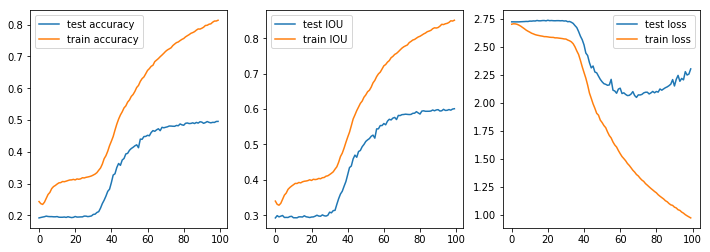

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.858
Test accuracy:0.502
Train IOU:0.888
Test IOU:0.607
Train loss loss:0.821
Test loss loss:2.057


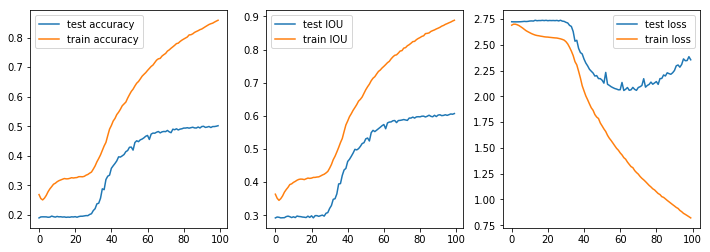

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.841
Test accuracy:0.487
Train IOU:0.872
Test IOU:0.593
Train loss loss:0.902
Test loss loss:2.100


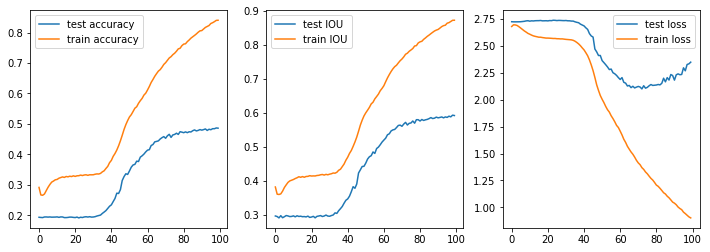

---------------------------------------------------------------------------------------------------- 



In [14]:
f = stats(imgBN_tst, imgBN_trn, ephocs=100, params=[50, 100, 150])

## Image and text BN 

Adding Batch Normalzation over both the image and text models

In [16]:
BN_tst, BN_trn = [], []
num_hiddens=[50, 100, 150]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'BN_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=testset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        bnorm=True,
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)

    tst, trn = m.train(trainset, testset, ephocs_num=100)
    BN_tst.append(tst)
    BN_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

params_dir: ../data/training/models/All/unorder1_RL/EXP/BN4__50
num_hidden: 50
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
batch:0 ;gs:1 ;lr:0.050 ;loss:2.618 ;acc:0.350 ;iou:0.400 ;time: 0:00:01
batch:50 ;gs:51 ;lr:0.050 ;loss:2.638 ;acc:0.300 ;iou:0.395 ;time: 0:00:13
batch:100 ;gs:101 ;lr:0.050 ;loss:2.635 ;acc:0.280 ;iou:0.370 ;time: 0:00:27
batch:150 ;gs:151 ;lr:0.050 ;loss:2.608 ;acc:0.290 ;iou:0.380 ;time: 0:00:40
batch:200 ;gs:201 ;lr:0.050 ;loss:2.687 ;acc:0.210 ;iou:0.310 ;time: 0:00:54
batch:250 ;gs:251 ;lr:0.050 ;loss:2.560 ;acc:0.300 ;iou:0.390 ;time: 0:01:07

*Train loss: 2.669 ;Train accuracy: 0.272 ;Train IOU: 0.367 ;Time: 0:01:18 

Testing, ephoc: 0
batch: 0 ;loss: 2.793 ;acc: 0.155 ;iou_acc: 0.260 ;time: 0:01:19
batch: 50 ;loss: 2.761 ;acc: 0.230 ;iou_acc: 0.310 ;time: 0:01:26
batch: 100 ;loss: 2.743 ;acc: 0.170 ;iou_acc: 0.315 ;time: 0:01:34
batch: 150 ;loss: 

batch:200 ;gs:2280 ;lr:0.050 ;loss:2.384 ;acc:0.415 ;iou:0.530 ;time: 0:00:53
batch:250 ;gs:2330 ;lr:0.050 ;loss:2.401 ;acc:0.395 ;iou:0.490 ;time: 0:01:06

*Train loss: 2.393 ;Train accuracy: 0.412 ;Train IOU: 0.519 ;Time: 0:01:18 

Testing, ephoc: 7
batch: 0 ;loss: 2.665 ;acc: 0.350 ;iou_acc: 0.480 ;time: 0:01:19
batch: 50 ;loss: 2.633 ;acc: 0.310 ;iou_acc: 0.420 ;time: 0:01:27
batch: 100 ;loss: 2.708 ;acc: 0.330 ;iou_acc: 0.465 ;time: 0:01:34
batch: 150 ;loss: 2.676 ;acc: 0.290 ;iou_acc: 0.440 ;time: 0:01:42
batch: 200 ;loss: 2.893 ;acc: 0.275 ;iou_acc: 0.405 ;time: 0:01:50
batch: 250 ;loss: 2.556 ;acc: 0.365 ;iou_acc: 0.455 ;time: 0:01:58

*Test loss: 2.707 ;Test accuracy 0.328 ;Test IOU: 0.459 ;Time: 0:02:05
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.227 ;acc:0.465 ;iou:0.630 ;time: 0:00:00
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.336 ;acc:0.410 ;iou:0.490 ;time: 0:00:13
batch:100 ;gs:2477 ;lr:0.050 ;loss:2.251 ;acc:0.490 ;iou:0.560 ;time: 0:00:26
batch:150 ;gs:2527 ;lr:0.050 ;

batch: 200 ;loss: 1.875 ;acc: 0.560 ;iou_acc: 0.665 ;time: 0:01:50
batch: 250 ;loss: 1.848 ;acc: 0.595 ;iou_acc: 0.680 ;time: 0:01:58

*Test loss: 1.837 ;Test accuracy 0.581 ;Test IOU: 0.700 ;Time: 0:02:05
Train, ephoc: 15
batch:0 ;gs:4456 ;lr:0.050 ;loss:0.891 ;acc:0.820 ;iou:0.875 ;time: 0:00:00
batch:50 ;gs:4506 ;lr:0.050 ;loss:0.929 ;acc:0.815 ;iou:0.855 ;time: 0:00:14
batch:100 ;gs:4556 ;lr:0.050 ;loss:1.102 ;acc:0.740 ;iou:0.810 ;time: 0:00:27
batch:150 ;gs:4606 ;lr:0.050 ;loss:0.757 ;acc:0.840 ;iou:0.880 ;time: 0:00:39
batch:200 ;gs:4656 ;lr:0.050 ;loss:0.859 ;acc:0.825 ;iou:0.895 ;time: 0:00:53
batch:250 ;gs:4706 ;lr:0.050 ;loss:0.882 ;acc:0.815 ;iou:0.915 ;time: 0:01:05

*Train loss: 0.860 ;Train accuracy: 0.834 ;Train IOU: 0.885 ;Time: 0:01:18 

Testing, ephoc: 15
batch: 0 ;loss: 1.579 ;acc: 0.645 ;iou_acc: 0.745 ;time: 0:01:18
batch: 50 ;loss: 1.847 ;acc: 0.595 ;iou_acc: 0.690 ;time: 0:01:26
batch: 100 ;loss: 1.763 ;acc: 0.610 ;iou_acc: 0.745 ;time: 0:01:34
batch: 150 ;loss:

batch:150 ;gs:6685 ;lr:0.050 ;loss:0.352 ;acc:0.955 ;iou:0.960 ;time: 0:00:40
batch:200 ;gs:6735 ;lr:0.050 ;loss:0.327 ;acc:0.955 ;iou:0.960 ;time: 0:00:53
batch:250 ;gs:6785 ;lr:0.050 ;loss:0.280 ;acc:0.975 ;iou:0.990 ;time: 0:01:07

*Train loss: 0.254 ;Train accuracy: 0.968 ;Train IOU: 0.978 ;Time: 0:01:19 

Testing, ephoc: 22
batch: 0 ;loss: 1.570 ;acc: 0.700 ;iou_acc: 0.815 ;time: 0:01:19
batch: 50 ;loss: 2.034 ;acc: 0.675 ;iou_acc: 0.755 ;time: 0:01:27
batch: 100 ;loss: 1.795 ;acc: 0.670 ;iou_acc: 0.785 ;time: 0:01:34
batch: 150 ;loss: 1.986 ;acc: 0.665 ;iou_acc: 0.760 ;time: 0:01:43
batch: 200 ;loss: 1.933 ;acc: 0.685 ;iou_acc: 0.785 ;time: 0:01:50
batch: 250 ;loss: 1.932 ;acc: 0.645 ;iou_acc: 0.800 ;time: 0:01:58

*Test loss: 1.775 ;Test accuracy 0.688 ;Test IOU: 0.785 ;Time: 0:02:06
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:0.252 ;acc:0.955 ;iou:0.970 ;time: 0:00:00
batch:50 ;gs:6882 ;lr:0.050 ;loss:0.217 ;acc:0.970 ;iou:0.980 ;time: 0:00:12
batch:100 ;gs:6932 ;lr:0.050

batch: 150 ;loss: 2.551 ;acc: 0.645 ;iou_acc: 0.725 ;time: 0:01:42
batch: 200 ;loss: 2.074 ;acc: 0.730 ;iou_acc: 0.810 ;time: 0:01:50
batch: 250 ;loss: 2.282 ;acc: 0.670 ;iou_acc: 0.785 ;time: 0:01:57

*Test loss: 2.132 ;Test accuracy 0.699 ;Test IOU: 0.794 ;Time: 0:02:05
Train, ephoc: 30
batch:0 ;gs:8911 ;lr:0.050 ;loss:0.097 ;acc:0.990 ;iou:0.990 ;time: 0:00:00
batch:50 ;gs:8961 ;lr:0.050 ;loss:0.078 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:9011 ;lr:0.050 ;loss:0.108 ;acc:0.995 ;iou:0.995 ;time: 0:00:27
batch:150 ;gs:9061 ;lr:0.050 ;loss:0.079 ;acc:0.995 ;iou:0.995 ;time: 0:00:40
batch:200 ;gs:9111 ;lr:0.050 ;loss:0.159 ;acc:0.980 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:9161 ;lr:0.050 ;loss:0.141 ;acc:0.975 ;iou:0.975 ;time: 0:01:06

*Train loss: 0.142 ;Train accuracy: 0.982 ;Train IOU: 0.987 ;Time: 0:01:18 

Testing, ephoc: 30
batch: 0 ;loss: 1.920 ;acc: 0.695 ;iou_acc: 0.810 ;time: 0:01:18
batch: 50 ;loss: 2.353 ;acc: 0.705 ;iou_acc: 0.765 ;time: 0:01:26
batch: 100 ;loss:

batch:100 ;gs:11090 ;lr:0.045 ;loss:0.127 ;acc:0.985 ;iou:0.990 ;time: 0:00:26
batch:150 ;gs:11140 ;lr:0.045 ;loss:0.122 ;acc:0.990 ;iou:0.995 ;time: 0:00:39
batch:200 ;gs:11190 ;lr:0.045 ;loss:0.070 ;acc:0.995 ;iou:0.995 ;time: 0:00:52
batch:250 ;gs:11240 ;lr:0.045 ;loss:0.075 ;acc:0.995 ;iou:0.995 ;time: 0:01:05

*Train loss: 0.082 ;Train accuracy: 0.991 ;Train IOU: 0.994 ;Time: 0:01:16 

Testing, ephoc: 37
batch: 0 ;loss: 2.224 ;acc: 0.680 ;iou_acc: 0.800 ;time: 0:01:17
batch: 50 ;loss: 2.546 ;acc: 0.690 ;iou_acc: 0.770 ;time: 0:01:24
batch: 100 ;loss: 2.289 ;acc: 0.685 ;iou_acc: 0.800 ;time: 0:01:32
batch: 150 ;loss: 2.927 ;acc: 0.670 ;iou_acc: 0.755 ;time: 0:01:40
batch: 200 ;loss: 2.796 ;acc: 0.660 ;iou_acc: 0.760 ;time: 0:01:48
batch: 250 ;loss: 2.609 ;acc: 0.670 ;iou_acc: 0.795 ;time: 0:01:56

*Test loss: 2.521 ;Test accuracy 0.696 ;Test IOU: 0.792 ;Time: 0:02:03
Train, ephoc: 38
batch:0 ;gs:11287 ;lr:0.045 ;loss:0.044 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:11337 ;lr

batch: 50 ;loss: 3.253 ;acc: 0.635 ;iou_acc: 0.720 ;time: 0:01:26
batch: 100 ;loss: 3.199 ;acc: 0.655 ;iou_acc: 0.795 ;time: 0:01:34
batch: 150 ;loss: 3.516 ;acc: 0.620 ;iou_acc: 0.750 ;time: 0:01:42
batch: 200 ;loss: 3.180 ;acc: 0.705 ;iou_acc: 0.780 ;time: 0:01:49
batch: 250 ;loss: 2.986 ;acc: 0.635 ;iou_acc: 0.765 ;time: 0:01:57

*Test loss: 2.902 ;Test accuracy 0.696 ;Test IOU: 0.790 ;Time: 0:02:04
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:0.052 ;acc:0.995 ;iou:0.995 ;time: 0:00:01
batch:50 ;gs:13416 ;lr:0.045 ;loss:0.036 ;acc:0.990 ;iou:0.995 ;time: 0:00:13
batch:100 ;gs:13466 ;lr:0.045 ;loss:0.057 ;acc:0.990 ;iou:0.995 ;time: 0:00:26
batch:150 ;gs:13516 ;lr:0.045 ;loss:0.030 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:13566 ;lr:0.045 ;loss:0.041 ;acc:0.995 ;iou:0.995 ;time: 0:00:53
batch:250 ;gs:13616 ;lr:0.045 ;loss:0.118 ;acc:0.985 ;iou:0.995 ;time: 0:01:06

*Train loss: 0.055 ;Train accuracy: 0.994 ;Train IOU: 0.996 ;Time: 0:01:18 

Testing, ephoc: 45
batch: 0 

batch:50 ;gs:15495 ;lr:0.045 ;loss:0.018 ;acc:1.000 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:15545 ;lr:0.045 ;loss:0.024 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:15595 ;lr:0.045 ;loss:0.066 ;acc:0.995 ;iou:0.995 ;time: 0:00:40
batch:200 ;gs:15645 ;lr:0.045 ;loss:0.028 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:15695 ;lr:0.045 ;loss:0.038 ;acc:0.995 ;iou:0.995 ;time: 0:01:07

*Train loss: 0.041 ;Train accuracy: 0.995 ;Train IOU: 0.997 ;Time: 0:01:19 

Testing, ephoc: 52
batch: 0 ;loss: 2.944 ;acc: 0.685 ;iou_acc: 0.795 ;time: 0:01:19
batch: 50 ;loss: 3.604 ;acc: 0.675 ;iou_acc: 0.760 ;time: 0:01:27
batch: 100 ;loss: 3.206 ;acc: 0.675 ;iou_acc: 0.800 ;time: 0:01:35
batch: 150 ;loss: 3.683 ;acc: 0.660 ;iou_acc: 0.750 ;time: 0:01:43
batch: 200 ;loss: 3.344 ;acc: 0.725 ;iou_acc: 0.815 ;time: 0:01:51
batch: 250 ;loss: 3.346 ;acc: 0.665 ;iou_acc: 0.785 ;time: 0:01:59

*Test loss: 3.242 ;Test accuracy 0.700 ;Test IOU: 0.793 ;Time: 0:02:06
Train, ephoc: 53
batch:0 ;gs:15742 ;lr

batch: 0 ;loss: 3.040 ;acc: 0.720 ;iou_acc: 0.830 ;time: 0:01:20
batch: 50 ;loss: 3.818 ;acc: 0.635 ;iou_acc: 0.740 ;time: 0:01:27
batch: 100 ;loss: 3.682 ;acc: 0.620 ;iou_acc: 0.755 ;time: 0:01:35
batch: 150 ;loss: 4.078 ;acc: 0.650 ;iou_acc: 0.750 ;time: 0:01:43
batch: 200 ;loss: 3.687 ;acc: 0.730 ;iou_acc: 0.800 ;time: 0:01:51
batch: 250 ;loss: 3.646 ;acc: 0.660 ;iou_acc: 0.795 ;time: 0:01:59

*Test loss: 3.409 ;Test accuracy 0.699 ;Test IOU: 0.794 ;Time: 0:02:06
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:0.033 ;acc:0.995 ;iou:0.995 ;time: 0:00:00
batch:50 ;gs:17871 ;lr:0.045 ;loss:0.062 ;acc:0.995 ;iou:0.995 ;time: 0:00:13
batch:100 ;gs:17921 ;lr:0.045 ;loss:0.015 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:17971 ;lr:0.045 ;loss:0.016 ;acc:1.000 ;iou:1.000 ;time: 0:00:39
batch:200 ;gs:18021 ;lr:0.045 ;loss:0.030 ;acc:0.995 ;iou:1.000 ;time: 0:00:52
batch:250 ;gs:18071 ;lr:0.045 ;loss:0.128 ;acc:0.975 ;iou:0.975 ;time: 0:01:06

*Train loss: 0.030 ;Train accuracy: 0.99

batch:0 ;gs:19900 ;lr:0.045 ;loss:0.014 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:19950 ;lr:0.045 ;loss:0.006 ;acc:1.000 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:20000 ;lr:0.045 ;loss:0.008 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:20050 ;lr:0.040 ;loss:0.019 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:20100 ;lr:0.040 ;loss:0.010 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:20150 ;lr:0.040 ;loss:0.016 ;acc:1.000 ;iou:1.000 ;time: 0:01:07

*Train loss: 0.019 ;Train accuracy: 0.998 ;Train IOU: 0.999 ;Time: 0:01:19 

Testing, ephoc: 67
batch: 0 ;loss: 3.424 ;acc: 0.695 ;iou_acc: 0.795 ;time: 0:01:19
batch: 50 ;loss: 4.002 ;acc: 0.665 ;iou_acc: 0.775 ;time: 0:01:27
batch: 100 ;loss: 3.988 ;acc: 0.655 ;iou_acc: 0.780 ;time: 0:01:35
batch: 150 ;loss: 4.406 ;acc: 0.630 ;iou_acc: 0.715 ;time: 0:01:43
batch: 200 ;loss: 4.458 ;acc: 0.690 ;iou_acc: 0.790 ;time: 0:01:51
batch: 250 ;loss: 4.057 ;acc: 0.680 ;iou_acc: 0.785 ;time: 0:01:59

*Test loss: 3.725 ;Test accuracy


*Train loss: 0.013 ;Train accuracy: 0.999 ;Train IOU: 0.999 ;Time: 0:01:18 

Testing, ephoc: 74
batch: 0 ;loss: 3.173 ;acc: 0.715 ;iou_acc: 0.830 ;time: 0:01:19
batch: 50 ;loss: 4.900 ;acc: 0.650 ;iou_acc: 0.740 ;time: 0:01:26
batch: 100 ;loss: 4.488 ;acc: 0.635 ;iou_acc: 0.765 ;time: 0:01:34
batch: 150 ;loss: 5.103 ;acc: 0.640 ;iou_acc: 0.725 ;time: 0:01:41
batch: 200 ;loss: 4.200 ;acc: 0.700 ;iou_acc: 0.805 ;time: 0:01:49
batch: 250 ;loss: 4.178 ;acc: 0.660 ;iou_acc: 0.755 ;time: 0:01:57

*Test loss: 3.986 ;Test accuracy 0.700 ;Test IOU: 0.794 ;Time: 0:02:04
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:0.028 ;acc:0.995 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:22326 ;lr:0.040 ;loss:0.008 ;acc:1.000 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:22376 ;lr:0.040 ;loss:0.006 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:22426 ;lr:0.040 ;loss:0.019 ;acc:1.000 ;iou:1.000 ;time: 0:00:41
batch:200 ;gs:22476 ;lr:0.040 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:22526 ;lr


*Test loss: 4.062 ;Test accuracy 0.702 ;Test IOU: 0.797 ;Time: 0:02:05
Train, ephoc: 82
batch:0 ;gs:24355 ;lr:0.040 ;loss:0.005 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:24405 ;lr:0.040 ;loss:0.005 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:24455 ;lr:0.040 ;loss:0.022 ;acc:0.995 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:24505 ;lr:0.040 ;loss:0.005 ;acc:1.000 ;iou:1.000 ;time: 0:00:38
batch:200 ;gs:24555 ;lr:0.040 ;loss:0.021 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:24605 ;lr:0.040 ;loss:0.009 ;acc:1.000 ;iou:1.000 ;time: 0:01:04

*Train loss: 0.012 ;Train accuracy: 0.999 ;Train IOU: 0.999 ;Time: 0:01:16 

Testing, ephoc: 82
batch: 0 ;loss: 3.754 ;acc: 0.675 ;iou_acc: 0.780 ;time: 0:01:17
batch: 50 ;loss: 4.956 ;acc: 0.645 ;iou_acc: 0.750 ;time: 0:01:24
batch: 100 ;loss: 4.770 ;acc: 0.665 ;iou_acc: 0.790 ;time: 0:01:32
batch: 150 ;loss: 4.909 ;acc: 0.660 ;iou_acc: 0.740 ;time: 0:01:40
batch: 200 ;loss: 4.549 ;acc: 0.700 ;iou_acc: 0.800 ;time: 0:01:48
batch: 250 

batch:200 ;gs:26634 ;lr:0.040 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:54
batch:250 ;gs:26684 ;lr:0.040 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:01:07

*Train loss: 0.010 ;Train accuracy: 0.999 ;Train IOU: 0.999 ;Time: 0:01:20 

Testing, ephoc: 89
batch: 0 ;loss: 3.910 ;acc: 0.685 ;iou_acc: 0.775 ;time: 0:01:20
batch: 50 ;loss: 4.862 ;acc: 0.630 ;iou_acc: 0.725 ;time: 0:01:28
batch: 100 ;loss: 4.794 ;acc: 0.645 ;iou_acc: 0.785 ;time: 0:01:36
batch: 150 ;loss: 5.026 ;acc: 0.615 ;iou_acc: 0.705 ;time: 0:01:44
batch: 200 ;loss: 4.634 ;acc: 0.695 ;iou_acc: 0.790 ;time: 0:01:51
batch: 250 ;loss: 4.825 ;acc: 0.665 ;iou_acc: 0.765 ;time: 0:01:59

*Test loss: 4.207 ;Test accuracy 0.701 ;Test IOU: 0.796 ;Time: 0:02:06
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.026 ;acc:0.995 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:26781 ;lr:0.040 ;loss:0.010 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:26831 ;lr:0.040 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:26881 ;lr

batch: 150 ;loss: 4.565 ;acc: 0.640 ;iou_acc: 0.750 ;time: 0:01:42
batch: 200 ;loss: 5.000 ;acc: 0.675 ;iou_acc: 0.785 ;time: 0:01:49
batch: 250 ;loss: 4.827 ;acc: 0.680 ;iou_acc: 0.790 ;time: 0:01:57

*Test loss: 4.283 ;Test accuracy 0.702 ;Test IOU: 0.796 ;Time: 0:02:04
Train, ephoc: 97
batch:0 ;gs:28810 ;lr:0.040 ;loss:0.009 ;acc:0.995 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.033 ;acc:0.995 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.007 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.005 ;acc:1.000 ;iou:1.000 ;time: 0:00:54
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:01:07

*Train loss: 0.008 ;Train accuracy: 0.999 ;Train IOU: 1.000 ;Time: 0:01:18 

Testing, ephoc: 97
batch: 0 ;loss: 3.597 ;acc: 0.720 ;iou_acc: 0.820 ;time: 0:01:19
batch: 50 ;loss: 4.686 ;acc: 0.675 ;iou_acc: 0.760 ;time: 0:01:26
batch: 100 

batch: 100 ;loss: 2.766 ;acc: 0.265 ;iou_acc: 0.360 ;time: 0:01:33
batch: 150 ;loss: 2.778 ;acc: 0.265 ;iou_acc: 0.360 ;time: 0:01:41
batch: 200 ;loss: 2.972 ;acc: 0.200 ;iou_acc: 0.320 ;time: 0:01:49
batch: 250 ;loss: 2.648 ;acc: 0.310 ;iou_acc: 0.375 ;time: 0:01:57

*Test loss: 2.796 ;Test accuracy 0.240 ;Test IOU: 0.354 ;Time: 0:02:04
Train, ephoc: 4
batch:0 ;gs:1189 ;lr:0.050 ;loss:2.634 ;acc:0.330 ;iou:0.420 ;time: 0:00:00
batch:50 ;gs:1239 ;lr:0.050 ;loss:2.633 ;acc:0.330 ;iou:0.405 ;time: 0:00:13
batch:100 ;gs:1289 ;lr:0.050 ;loss:2.581 ;acc:0.310 ;iou:0.425 ;time: 0:00:26
batch:150 ;gs:1339 ;lr:0.050 ;loss:2.702 ;acc:0.320 ;iou:0.430 ;time: 0:00:39
batch:200 ;gs:1389 ;lr:0.050 ;loss:2.577 ;acc:0.335 ;iou:0.435 ;time: 0:00:52
batch:250 ;gs:1439 ;lr:0.050 ;loss:2.613 ;acc:0.325 ;iou:0.395 ;time: 0:01:05

*Train loss: 2.620 ;Train accuracy: 0.337 ;Train IOU: 0.435 ;Time: 0:01:17 

Testing, ephoc: 4
batch: 0 ;loss: 2.858 ;acc: 0.240 ;iou_acc: 0.360 ;time: 0:01:17
batch: 50 ;loss: 2

batch:100 ;gs:3368 ;lr:0.050 ;loss:2.154 ;acc:0.480 ;iou:0.600 ;time: 0:00:27
batch:150 ;gs:3418 ;lr:0.050 ;loss:1.910 ;acc:0.550 ;iou:0.670 ;time: 0:00:40
batch:200 ;gs:3468 ;lr:0.050 ;loss:2.053 ;acc:0.520 ;iou:0.620 ;time: 0:00:54
batch:250 ;gs:3518 ;lr:0.050 ;loss:2.340 ;acc:0.450 ;iou:0.535 ;time: 0:01:06

*Train loss: 2.155 ;Train accuracy: 0.504 ;Train IOU: 0.608 ;Time: 0:01:19 

Testing, ephoc: 11
batch: 0 ;loss: 2.471 ;acc: 0.385 ;iou_acc: 0.510 ;time: 0:01:19
batch: 50 ;loss: 2.610 ;acc: 0.410 ;iou_acc: 0.505 ;time: 0:01:27
batch: 100 ;loss: 2.555 ;acc: 0.445 ;iou_acc: 0.580 ;time: 0:01:35
batch: 150 ;loss: 2.682 ;acc: 0.390 ;iou_acc: 0.520 ;time: 0:01:43
batch: 200 ;loss: 2.770 ;acc: 0.380 ;iou_acc: 0.505 ;time: 0:01:51
batch: 250 ;loss: 2.409 ;acc: 0.395 ;iou_acc: 0.505 ;time: 0:01:58

*Test loss: 2.577 ;Test accuracy 0.404 ;Test IOU: 0.533 ;Time: 0:02:06
Train, ephoc: 12
batch:0 ;gs:3565 ;lr:0.050 ;loss:1.929 ;acc:0.515 ;iou:0.655 ;time: 0:00:00
batch:50 ;gs:3615 ;lr:0.050

batch: 100 ;loss: 1.766 ;acc: 0.660 ;iou_acc: 0.760 ;time: 0:01:35
batch: 150 ;loss: 2.031 ;acc: 0.600 ;iou_acc: 0.695 ;time: 0:01:42
batch: 200 ;loss: 1.727 ;acc: 0.655 ;iou_acc: 0.740 ;time: 0:01:50
batch: 250 ;loss: 1.666 ;acc: 0.625 ;iou_acc: 0.740 ;time: 0:01:58

*Test loss: 1.749 ;Test accuracy 0.655 ;Test IOU: 0.762 ;Time: 0:02:05
Train, ephoc: 19
batch:0 ;gs:5644 ;lr:0.050 ;loss:0.429 ;acc:0.925 ;iou:0.950 ;time: 0:00:00
batch:50 ;gs:5694 ;lr:0.050 ;loss:0.421 ;acc:0.920 ;iou:0.945 ;time: 0:00:14
batch:100 ;gs:5744 ;lr:0.050 ;loss:0.420 ;acc:0.940 ;iou:0.970 ;time: 0:00:27
batch:150 ;gs:5794 ;lr:0.050 ;loss:0.573 ;acc:0.880 ;iou:0.920 ;time: 0:00:40
batch:200 ;gs:5844 ;lr:0.050 ;loss:0.380 ;acc:0.940 ;iou:0.955 ;time: 0:00:53
batch:250 ;gs:5894 ;lr:0.050 ;loss:0.476 ;acc:0.920 ;iou:0.945 ;time: 0:01:06

*Train loss: 0.412 ;Train accuracy: 0.933 ;Train IOU: 0.954 ;Time: 0:01:18 

Testing, ephoc: 19
batch: 0 ;loss: 1.601 ;acc: 0.730 ;iou_acc: 0.815 ;time: 0:01:18
batch: 50 ;loss:

batch:50 ;gs:7773 ;lr:0.050 ;loss:0.068 ;acc:0.990 ;iou:0.990 ;time: 0:00:13
batch:100 ;gs:7823 ;lr:0.050 ;loss:0.030 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:7873 ;lr:0.050 ;loss:0.058 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:7923 ;lr:0.050 ;loss:0.066 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:7973 ;lr:0.050 ;loss:0.142 ;acc:0.970 ;iou:0.975 ;time: 0:01:06

*Train loss: 0.089 ;Train accuracy: 0.991 ;Train IOU: 0.993 ;Time: 0:01:18 

Testing, ephoc: 26
batch: 0 ;loss: 1.646 ;acc: 0.780 ;iou_acc: 0.835 ;time: 0:01:19
batch: 50 ;loss: 2.387 ;acc: 0.630 ;iou_acc: 0.750 ;time: 0:01:26
batch: 100 ;loss: 2.354 ;acc: 0.665 ;iou_acc: 0.755 ;time: 0:01:34
batch: 150 ;loss: 2.566 ;acc: 0.680 ;iou_acc: 0.780 ;time: 0:01:42
batch: 200 ;loss: 1.911 ;acc: 0.700 ;iou_acc: 0.795 ;time: 0:01:50
batch: 250 ;loss: 2.035 ;acc: 0.650 ;iou_acc: 0.765 ;time: 0:01:58

*Test loss: 2.190 ;Test accuracy 0.699 ;Test IOU: 0.792 ;Time: 0:02:05
Train, ephoc: 27
batch:0 ;gs:8020 ;lr:0.050

batch: 0 ;loss: 2.063 ;acc: 0.770 ;iou_acc: 0.850 ;time: 0:01:19
batch: 50 ;loss: 3.220 ;acc: 0.640 ;iou_acc: 0.760 ;time: 0:01:27
batch: 100 ;loss: 2.822 ;acc: 0.685 ;iou_acc: 0.780 ;time: 0:01:35
batch: 150 ;loss: 3.455 ;acc: 0.670 ;iou_acc: 0.765 ;time: 0:01:43
batch: 200 ;loss: 2.659 ;acc: 0.690 ;iou_acc: 0.805 ;time: 0:01:50
batch: 250 ;loss: 2.261 ;acc: 0.725 ;iou_acc: 0.820 ;time: 0:01:58

*Test loss: 2.712 ;Test accuracy 0.710 ;Test IOU: 0.802 ;Time: 0:02:06
Train, ephoc: 34
batch:0 ;gs:10099 ;lr:0.045 ;loss:0.033 ;acc:0.995 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:10149 ;lr:0.045 ;loss:0.027 ;acc:1.000 ;iou:1.000 ;time: 0:00:12
batch:100 ;gs:10199 ;lr:0.045 ;loss:0.033 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:10249 ;lr:0.045 ;loss:0.049 ;acc:1.000 ;iou:1.000 ;time: 0:00:39
batch:200 ;gs:10299 ;lr:0.045 ;loss:0.030 ;acc:1.000 ;iou:1.000 ;time: 0:00:52
batch:250 ;gs:10349 ;lr:0.045 ;loss:0.022 ;acc:1.000 ;iou:1.000 ;time: 0:01:06

*Train loss: 0.038 ;Train accuracy: 0.99

batch:0 ;gs:12178 ;lr:0.045 ;loss:0.031 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:12228 ;lr:0.045 ;loss:0.098 ;acc:0.990 ;iou:0.990 ;time: 0:00:14
batch:100 ;gs:12278 ;lr:0.045 ;loss:0.007 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:12328 ;lr:0.045 ;loss:0.012 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:12378 ;lr:0.045 ;loss:0.015 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:12428 ;lr:0.045 ;loss:0.026 ;acc:1.000 ;iou:1.000 ;time: 0:01:06

*Train loss: 0.026 ;Train accuracy: 0.998 ;Train IOU: 0.998 ;Time: 0:01:19 

Testing, ephoc: 41
batch: 0 ;loss: 2.759 ;acc: 0.730 ;iou_acc: 0.805 ;time: 0:01:19
batch: 50 ;loss: 3.844 ;acc: 0.635 ;iou_acc: 0.780 ;time: 0:01:26
batch: 100 ;loss: 2.893 ;acc: 0.710 ;iou_acc: 0.805 ;time: 0:01:34
batch: 150 ;loss: 4.139 ;acc: 0.675 ;iou_acc: 0.765 ;time: 0:01:42
batch: 200 ;loss: 2.970 ;acc: 0.710 ;iou_acc: 0.810 ;time: 0:01:49
batch: 250 ;loss: 3.230 ;acc: 0.660 ;iou_acc: 0.795 ;time: 0:01:57

*Test loss: 3.235 ;Test accuracy


*Train loss: 0.022 ;Train accuracy: 0.998 ;Train IOU: 0.998 ;Time: 0:01:19 

Testing, ephoc: 48
batch: 0 ;loss: 2.990 ;acc: 0.725 ;iou_acc: 0.810 ;time: 0:01:19
batch: 50 ;loss: 3.807 ;acc: 0.660 ;iou_acc: 0.780 ;time: 0:01:27
batch: 100 ;loss: 3.446 ;acc: 0.710 ;iou_acc: 0.790 ;time: 0:01:35
batch: 150 ;loss: 4.208 ;acc: 0.675 ;iou_acc: 0.755 ;time: 0:01:43
batch: 200 ;loss: 2.774 ;acc: 0.720 ;iou_acc: 0.820 ;time: 0:01:51
batch: 250 ;loss: 2.949 ;acc: 0.685 ;iou_acc: 0.830 ;time: 0:01:59

*Test loss: 3.204 ;Test accuracy 0.711 ;Test IOU: 0.802 ;Time: 0:02:06
Train, ephoc: 49
batch:0 ;gs:14554 ;lr:0.045 ;loss:0.075 ;acc:0.985 ;iou:0.985 ;time: 0:00:00
batch:50 ;gs:14604 ;lr:0.045 ;loss:0.016 ;acc:1.000 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:14654 ;lr:0.045 ;loss:0.032 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:14704 ;lr:0.045 ;loss:0.024 ;acc:0.995 ;iou:0.995 ;time: 0:00:40
batch:200 ;gs:14754 ;lr:0.045 ;loss:0.015 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:14804 ;lr


*Test loss: 3.489 ;Test accuracy 0.707 ;Test IOU: 0.797 ;Time: 0:02:04
Train, ephoc: 56
batch:0 ;gs:16633 ;lr:0.045 ;loss:0.008 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:16683 ;lr:0.045 ;loss:0.027 ;acc:0.995 ;iou:0.995 ;time: 0:00:14
batch:100 ;gs:16733 ;lr:0.045 ;loss:0.023 ;acc:0.995 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:16783 ;lr:0.045 ;loss:0.047 ;acc:0.990 ;iou:0.995 ;time: 0:00:40
batch:200 ;gs:16833 ;lr:0.045 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:54
batch:250 ;gs:16883 ;lr:0.045 ;loss:0.009 ;acc:1.000 ;iou:1.000 ;time: 0:01:06

*Train loss: 0.016 ;Train accuracy: 0.998 ;Train IOU: 0.999 ;Time: 0:01:19 

Testing, ephoc: 56
batch: 0 ;loss: 3.047 ;acc: 0.740 ;iou_acc: 0.810 ;time: 0:01:19
batch: 50 ;loss: 4.264 ;acc: 0.660 ;iou_acc: 0.785 ;time: 0:01:27
batch: 100 ;loss: 3.314 ;acc: 0.730 ;iou_acc: 0.820 ;time: 0:01:35
batch: 150 ;loss: 4.628 ;acc: 0.635 ;iou_acc: 0.730 ;time: 0:01:43
batch: 200 ;loss: 3.182 ;acc: 0.695 ;iou_acc: 0.790 ;time: 0:01:50
batch: 250 

batch:200 ;gs:18912 ;lr:0.045 ;loss:0.005 ;acc:1.000 ;iou:1.000 ;time: 0:00:54
batch:250 ;gs:18962 ;lr:0.045 ;loss:0.008 ;acc:1.000 ;iou:1.000 ;time: 0:01:07

*Train loss: 0.013 ;Train accuracy: 0.999 ;Train IOU: 0.999 ;Time: 0:01:19 

Testing, ephoc: 63
batch: 0 ;loss: 3.308 ;acc: 0.730 ;iou_acc: 0.805 ;time: 0:01:19
batch: 50 ;loss: 4.071 ;acc: 0.670 ;iou_acc: 0.790 ;time: 0:01:27
batch: 100 ;loss: 3.585 ;acc: 0.680 ;iou_acc: 0.800 ;time: 0:01:34
batch: 150 ;loss: 4.924 ;acc: 0.680 ;iou_acc: 0.775 ;time: 0:01:42
batch: 200 ;loss: 3.524 ;acc: 0.740 ;iou_acc: 0.825 ;time: 0:01:50
batch: 250 ;loss: 3.420 ;acc: 0.695 ;iou_acc: 0.800 ;time: 0:01:58

*Test loss: 3.662 ;Test accuracy 0.714 ;Test IOU: 0.804 ;Time: 0:02:05
Train, ephoc: 64
batch:0 ;gs:19009 ;lr:0.045 ;loss:0.005 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:19059 ;lr:0.045 ;loss:0.004 ;acc:1.000 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:19109 ;lr:0.045 ;loss:0.052 ;acc:0.995 ;iou:0.995 ;time: 0:00:27
batch:150 ;gs:19159 ;lr

batch: 150 ;loss: 5.054 ;acc: 0.675 ;iou_acc: 0.745 ;time: 0:01:41
batch: 200 ;loss: 3.203 ;acc: 0.725 ;iou_acc: 0.815 ;time: 0:01:48
batch: 250 ;loss: 3.362 ;acc: 0.675 ;iou_acc: 0.805 ;time: 0:01:56

*Test loss: 3.646 ;Test accuracy 0.719 ;Test IOU: 0.808 ;Time: 0:02:03
Train, ephoc: 71
batch:0 ;gs:21088 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:21138 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:21188 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:21238 ;lr:0.040 ;loss:0.003 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:21288 ;lr:0.040 ;loss:0.005 ;acc:1.000 ;iou:1.000 ;time: 0:00:54
batch:250 ;gs:21338 ;lr:0.040 ;loss:0.005 ;acc:1.000 ;iou:1.000 ;time: 0:01:07

*Train loss: 0.005 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:19 

Testing, ephoc: 71
batch: 0 ;loss: 3.161 ;acc: 0.770 ;iou_acc: 0.835 ;time: 0:01:19
batch: 50 ;loss: 4.389 ;acc: 0.665 ;iou_acc: 0.770 ;time: 0:01:27
batch: 100 

batch:100 ;gs:23267 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:23317 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:23367 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:23417 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:01:06

*Train loss: 0.004 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:18 

Testing, ephoc: 78
batch: 0 ;loss: 3.152 ;acc: 0.770 ;iou_acc: 0.830 ;time: 0:01:18
batch: 50 ;loss: 4.243 ;acc: 0.685 ;iou_acc: 0.805 ;time: 0:01:25
batch: 100 ;loss: 3.933 ;acc: 0.700 ;iou_acc: 0.805 ;time: 0:01:33
batch: 150 ;loss: 5.194 ;acc: 0.655 ;iou_acc: 0.730 ;time: 0:01:41
batch: 200 ;loss: 3.379 ;acc: 0.715 ;iou_acc: 0.820 ;time: 0:01:49
batch: 250 ;loss: 3.410 ;acc: 0.690 ;iou_acc: 0.825 ;time: 0:01:57

*Test loss: 3.694 ;Test accuracy 0.719 ;Test IOU: 0.808 ;Time: 0:02:04
Train, ephoc: 79
batch:0 ;gs:23464 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:23514 ;lr

batch: 50 ;loss: 4.715 ;acc: 0.665 ;iou_acc: 0.795 ;time: 0:01:27
batch: 100 ;loss: 3.530 ;acc: 0.695 ;iou_acc: 0.805 ;time: 0:01:35
batch: 150 ;loss: 5.111 ;acc: 0.665 ;iou_acc: 0.750 ;time: 0:01:43
batch: 200 ;loss: 3.521 ;acc: 0.735 ;iou_acc: 0.840 ;time: 0:01:51
batch: 250 ;loss: 3.481 ;acc: 0.685 ;iou_acc: 0.810 ;time: 0:01:58

*Test loss: 3.738 ;Test accuracy 0.721 ;Test IOU: 0.811 ;Time: 0:02:06
Train, ephoc: 86
batch:0 ;gs:25543 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:25593 ;lr:0.040 ;loss:0.009 ;acc:0.995 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:25643 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:25693 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:25743 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:25793 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:01:07

*Train loss: 0.003 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:18 

Testing, ephoc: 86
batch: 0 

batch:50 ;gs:27672 ;lr:0.040 ;loss:0.115 ;acc:0.995 ;iou:0.995 ;time: 0:00:12
batch:100 ;gs:27722 ;lr:0.040 ;loss:0.000 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:27772 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:39
batch:200 ;gs:27822 ;lr:0.040 ;loss:0.000 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:27872 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:01:07

*Train loss: 0.003 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:18 

Testing, ephoc: 93
batch: 0 ;loss: 3.319 ;acc: 0.780 ;iou_acc: 0.845 ;time: 0:01:19
batch: 50 ;loss: 4.380 ;acc: 0.670 ;iou_acc: 0.785 ;time: 0:01:26
batch: 100 ;loss: 3.480 ;acc: 0.695 ;iou_acc: 0.785 ;time: 0:01:34
batch: 150 ;loss: 4.969 ;acc: 0.680 ;iou_acc: 0.760 ;time: 0:01:42
batch: 200 ;loss: 3.605 ;acc: 0.715 ;iou_acc: 0.810 ;time: 0:01:50
batch: 250 ;loss: 3.575 ;acc: 0.675 ;iou_acc: 0.810 ;time: 0:01:58

*Test loss: 3.751 ;Test accuracy 0.721 ;Test IOU: 0.810 ;Time: 0:02:05
Train, ephoc: 94
batch:0 ;gs:27919 ;lr

batch:0 ;gs:1 ;lr:0.050 ;loss:2.540 ;acc:0.405 ;iou:0.470 ;time: 0:00:01
batch:50 ;gs:51 ;lr:0.050 ;loss:2.726 ;acc:0.265 ;iou:0.355 ;time: 0:00:13
batch:100 ;gs:101 ;lr:0.050 ;loss:2.640 ;acc:0.345 ;iou:0.420 ;time: 0:00:26
batch:150 ;gs:151 ;lr:0.050 ;loss:2.633 ;acc:0.330 ;iou:0.410 ;time: 0:00:40
batch:200 ;gs:201 ;lr:0.050 ;loss:2.586 ;acc:0.315 ;iou:0.415 ;time: 0:00:54
batch:250 ;gs:251 ;lr:0.050 ;loss:2.655 ;acc:0.315 ;iou:0.410 ;time: 0:01:07

*Train loss: 2.645 ;Train accuracy: 0.301 ;Train IOU: 0.388 ;Time: 0:01:19 

Testing, ephoc: 0
batch: 0 ;loss: 2.801 ;acc: 0.150 ;iou_acc: 0.245 ;time: 0:01:19
batch: 50 ;loss: 2.773 ;acc: 0.180 ;iou_acc: 0.290 ;time: 0:01:27
batch: 100 ;loss: 2.751 ;acc: 0.220 ;iou_acc: 0.355 ;time: 0:01:35
batch: 150 ;loss: 2.768 ;acc: 0.185 ;iou_acc: 0.270 ;time: 0:01:43
batch: 200 ;loss: 2.807 ;acc: 0.175 ;iou_acc: 0.275 ;time: 0:01:51
batch: 250 ;loss: 2.733 ;acc: 0.220 ;iou_acc: 0.295 ;time: 0:01:59

*Test loss: 2.758 ;Test accuracy 0.205 ;Test IOU

batch: 0 ;loss: 3.080 ;acc: 0.240 ;iou_acc: 0.350 ;time: 0:01:19
batch: 50 ;loss: 2.987 ;acc: 0.275 ;iou_acc: 0.380 ;time: 0:01:27
batch: 100 ;loss: 2.921 ;acc: 0.335 ;iou_acc: 0.455 ;time: 0:01:35
batch: 150 ;loss: 2.927 ;acc: 0.305 ;iou_acc: 0.415 ;time: 0:01:43
batch: 200 ;loss: 3.196 ;acc: 0.190 ;iou_acc: 0.315 ;time: 0:01:50
batch: 250 ;loss: 2.792 ;acc: 0.320 ;iou_acc: 0.435 ;time: 0:01:58

*Test loss: 2.969 ;Test accuracy 0.278 ;Test IOU: 0.400 ;Time: 0:02:05
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.400 ;acc:0.445 ;iou:0.530 ;time: 0:00:01
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.405 ;acc:0.425 ;iou:0.510 ;time: 0:00:14
batch:100 ;gs:2477 ;lr:0.050 ;loss:2.756 ;acc:0.355 ;iou:0.475 ;time: 0:00:27
batch:150 ;gs:2527 ;lr:0.050 ;loss:2.559 ;acc:0.410 ;iou:0.500 ;time: 0:00:40
batch:200 ;gs:2577 ;lr:0.050 ;loss:2.809 ;acc:0.335 ;iou:0.430 ;time: 0:00:53
batch:250 ;gs:2627 ;lr:0.050 ;loss:2.584 ;acc:0.360 ;iou:0.455 ;time: 0:01:06

*Train loss: 2.620 ;Train accuracy: 0.380 ;Trai

batch:50 ;gs:4506 ;lr:0.050 ;loss:1.667 ;acc:0.630 ;iou:0.710 ;time: 0:00:13
batch:100 ;gs:4556 ;lr:0.050 ;loss:1.648 ;acc:0.650 ;iou:0.740 ;time: 0:00:26
batch:150 ;gs:4606 ;lr:0.050 ;loss:1.652 ;acc:0.645 ;iou:0.730 ;time: 0:00:39
batch:200 ;gs:4656 ;lr:0.050 ;loss:1.317 ;acc:0.670 ;iou:0.775 ;time: 0:00:52
batch:250 ;gs:4706 ;lr:0.050 ;loss:1.495 ;acc:0.695 ;iou:0.765 ;time: 0:01:06

*Train loss: 1.510 ;Train accuracy: 0.670 ;Train IOU: 0.751 ;Time: 0:01:18 

Testing, ephoc: 15
batch: 0 ;loss: 2.293 ;acc: 0.520 ;iou_acc: 0.655 ;time: 0:01:18
batch: 50 ;loss: 2.271 ;acc: 0.540 ;iou_acc: 0.670 ;time: 0:01:26
batch: 100 ;loss: 2.285 ;acc: 0.515 ;iou_acc: 0.625 ;time: 0:01:34
batch: 150 ;loss: 2.557 ;acc: 0.455 ;iou_acc: 0.595 ;time: 0:01:41
batch: 200 ;loss: 2.272 ;acc: 0.515 ;iou_acc: 0.645 ;time: 0:01:49
batch: 250 ;loss: 2.164 ;acc: 0.540 ;iou_acc: 0.660 ;time: 0:01:57

*Test loss: 2.279 ;Test accuracy 0.524 ;Test IOU: 0.649 ;Time: 0:02:03
Train, ephoc: 16
batch:0 ;gs:4753 ;lr:0.050

batch: 0 ;loss: 2.054 ;acc: 0.700 ;iou_acc: 0.795 ;time: 0:01:19
batch: 50 ;loss: 2.313 ;acc: 0.660 ;iou_acc: 0.760 ;time: 0:01:27
batch: 100 ;loss: 2.174 ;acc: 0.640 ;iou_acc: 0.740 ;time: 0:01:35
batch: 150 ;loss: 2.414 ;acc: 0.665 ;iou_acc: 0.750 ;time: 0:01:43
batch: 200 ;loss: 1.964 ;acc: 0.675 ;iou_acc: 0.790 ;time: 0:01:51
batch: 250 ;loss: 2.265 ;acc: 0.660 ;iou_acc: 0.775 ;time: 0:01:59

*Test loss: 2.133 ;Test accuracy 0.676 ;Test IOU: 0.774 ;Time: 0:02:06
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:0.132 ;acc:0.985 ;iou:0.985 ;time: 0:00:00
batch:50 ;gs:6882 ;lr:0.050 ;loss:0.155 ;acc:0.985 ;iou:0.990 ;time: 0:00:14
batch:100 ;gs:6932 ;lr:0.050 ;loss:0.059 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:6982 ;lr:0.050 ;loss:0.059 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:7032 ;lr:0.050 ;loss:0.151 ;acc:0.975 ;iou:0.975 ;time: 0:00:53
batch:250 ;gs:7082 ;lr:0.050 ;loss:0.084 ;acc:0.995 ;iou:0.995 ;time: 0:01:06

*Train loss: 0.129 ;Train accuracy: 0.986 ;Tra

batch:50 ;gs:8961 ;lr:0.050 ;loss:0.029 ;acc:0.995 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:9011 ;lr:0.050 ;loss:0.164 ;acc:0.975 ;iou:0.985 ;time: 0:00:26
batch:150 ;gs:9061 ;lr:0.050 ;loss:0.018 ;acc:1.000 ;iou:1.000 ;time: 0:00:39
batch:200 ;gs:9111 ;lr:0.050 ;loss:0.020 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:9161 ;lr:0.050 ;loss:0.032 ;acc:0.995 ;iou:0.995 ;time: 0:01:04

*Train loss: 0.043 ;Train accuracy: 0.996 ;Train IOU: 0.997 ;Time: 0:01:16 

Testing, ephoc: 30
batch: 0 ;loss: 2.372 ;acc: 0.715 ;iou_acc: 0.825 ;time: 0:01:16
batch: 50 ;loss: 2.886 ;acc: 0.645 ;iou_acc: 0.760 ;time: 0:01:24
batch: 100 ;loss: 2.308 ;acc: 0.695 ;iou_acc: 0.765 ;time: 0:01:32
batch: 150 ;loss: 3.074 ;acc: 0.620 ;iou_acc: 0.750 ;time: 0:01:40
batch: 200 ;loss: 2.486 ;acc: 0.700 ;iou_acc: 0.810 ;time: 0:01:47
batch: 250 ;loss: 2.328 ;acc: 0.690 ;iou_acc: 0.800 ;time: 0:01:56

*Test loss: 2.524 ;Test accuracy 0.708 ;Test IOU: 0.800 ;Time: 0:02:03
Train, ephoc: 31
batch:0 ;gs:9208 ;lr:0.050

batch: 0 ;loss: 2.895 ;acc: 0.705 ;iou_acc: 0.825 ;time: 0:01:19
batch: 50 ;loss: 3.387 ;acc: 0.670 ;iou_acc: 0.795 ;time: 0:01:26
batch: 100 ;loss: 2.402 ;acc: 0.730 ;iou_acc: 0.815 ;time: 0:01:35
batch: 150 ;loss: 3.444 ;acc: 0.665 ;iou_acc: 0.750 ;time: 0:01:42
batch: 200 ;loss: 2.760 ;acc: 0.710 ;iou_acc: 0.815 ;time: 0:01:50
batch: 250 ;loss: 2.930 ;acc: 0.680 ;iou_acc: 0.815 ;time: 0:01:58

*Test loss: 2.943 ;Test accuracy 0.714 ;Test IOU: 0.804 ;Time: 0:02:05
Train, ephoc: 38
batch:0 ;gs:11287 ;lr:0.045 ;loss:0.022 ;acc:0.995 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:11337 ;lr:0.045 ;loss:0.010 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:11387 ;lr:0.045 ;loss:0.050 ;acc:0.990 ;iou:0.995 ;time: 0:00:27
batch:150 ;gs:11437 ;lr:0.045 ;loss:0.009 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:11487 ;lr:0.045 ;loss:0.062 ;acc:0.985 ;iou:0.985 ;time: 0:00:54
batch:250 ;gs:11537 ;lr:0.045 ;loss:0.016 ;acc:1.000 ;iou:1.000 ;time: 0:01:06

*Train loss: 0.018 ;Train accuracy: 0.99

batch:0 ;gs:13366 ;lr:0.045 ;loss:0.011 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:13416 ;lr:0.045 ;loss:0.007 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:13466 ;lr:0.045 ;loss:0.012 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:13516 ;lr:0.045 ;loss:0.012 ;acc:1.000 ;iou:1.000 ;time: 0:00:39
batch:200 ;gs:13566 ;lr:0.045 ;loss:0.021 ;acc:1.000 ;iou:1.000 ;time: 0:00:51
batch:250 ;gs:13616 ;lr:0.045 ;loss:0.007 ;acc:1.000 ;iou:1.000 ;time: 0:01:05

*Train loss: 0.018 ;Train accuracy: 0.998 ;Train IOU: 0.998 ;Time: 0:01:17 

Testing, ephoc: 45
batch: 0 ;loss: 3.360 ;acc: 0.705 ;iou_acc: 0.825 ;time: 0:01:17
batch: 50 ;loss: 3.818 ;acc: 0.645 ;iou_acc: 0.750 ;time: 0:01:24
batch: 100 ;loss: 3.000 ;acc: 0.700 ;iou_acc: 0.785 ;time: 0:01:32
batch: 150 ;loss: 4.140 ;acc: 0.670 ;iou_acc: 0.770 ;time: 0:01:40
batch: 200 ;loss: 3.171 ;acc: 0.710 ;iou_acc: 0.815 ;time: 0:01:48
batch: 250 ;loss: 3.814 ;acc: 0.685 ;iou_acc: 0.805 ;time: 0:01:55

*Test loss: 3.341 ;Test accuracy


*Train loss: 0.016 ;Train accuracy: 0.998 ;Train IOU: 0.999 ;Time: 0:01:19 

Testing, ephoc: 52
batch: 0 ;loss: 3.238 ;acc: 0.715 ;iou_acc: 0.835 ;time: 0:01:19
batch: 50 ;loss: 4.008 ;acc: 0.670 ;iou_acc: 0.780 ;time: 0:01:27
batch: 100 ;loss: 3.144 ;acc: 0.680 ;iou_acc: 0.795 ;time: 0:01:34
batch: 150 ;loss: 3.970 ;acc: 0.680 ;iou_acc: 0.780 ;time: 0:01:43
batch: 200 ;loss: 3.080 ;acc: 0.735 ;iou_acc: 0.840 ;time: 0:01:50
batch: 250 ;loss: 3.343 ;acc: 0.700 ;iou_acc: 0.815 ;time: 0:01:58

*Test loss: 3.413 ;Test accuracy 0.714 ;Test IOU: 0.806 ;Time: 0:02:05
Train, ephoc: 53
batch:0 ;gs:15742 ;lr:0.045 ;loss:0.007 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:15792 ;lr:0.045 ;loss:0.018 ;acc:0.995 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:15842 ;lr:0.045 ;loss:0.020 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:15892 ;lr:0.045 ;loss:0.022 ;acc:0.995 ;iou:0.995 ;time: 0:00:39
batch:200 ;gs:15942 ;lr:0.045 ;loss:0.009 ;acc:1.000 ;iou:1.000 ;time: 0:00:52
batch:250 ;gs:15992 ;lr


*Test loss: 3.666 ;Test accuracy 0.711 ;Test IOU: 0.802 ;Time: 0:02:05
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:17871 ;lr:0.045 ;loss:0.007 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:17921 ;lr:0.045 ;loss:0.012 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:17971 ;lr:0.045 ;loss:0.014 ;acc:0.995 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:18021 ;lr:0.045 ;loss:0.005 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:18071 ;lr:0.045 ;loss:0.009 ;acc:0.995 ;iou:1.000 ;time: 0:01:06

*Train loss: 0.011 ;Train accuracy: 0.999 ;Train IOU: 0.999 ;Time: 0:01:19 

Testing, ephoc: 60
batch: 0 ;loss: 3.218 ;acc: 0.725 ;iou_acc: 0.840 ;time: 0:01:19
batch: 50 ;loss: 4.450 ;acc: 0.630 ;iou_acc: 0.740 ;time: 0:01:26
batch: 100 ;loss: 3.239 ;acc: 0.710 ;iou_acc: 0.800 ;time: 0:01:34
batch: 150 ;loss: 4.422 ;acc: 0.665 ;iou_acc: 0.760 ;time: 0:01:42
batch: 200 ;loss: 3.528 ;acc: 0.685 ;iou_acc: 0.805 ;time: 0:01:49
batch: 250 

batch:200 ;gs:20100 ;lr:0.040 ;loss:0.005 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:20150 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:01:06

*Train loss: 0.007 ;Train accuracy: 0.999 ;Train IOU: 1.000 ;Time: 0:01:18 

Testing, ephoc: 67
batch: 0 ;loss: 3.312 ;acc: 0.715 ;iou_acc: 0.825 ;time: 0:01:18
batch: 50 ;loss: 4.127 ;acc: 0.670 ;iou_acc: 0.780 ;time: 0:01:26
batch: 100 ;loss: 3.634 ;acc: 0.685 ;iou_acc: 0.790 ;time: 0:01:34
batch: 150 ;loss: 4.402 ;acc: 0.665 ;iou_acc: 0.780 ;time: 0:01:42
batch: 200 ;loss: 3.601 ;acc: 0.690 ;iou_acc: 0.820 ;time: 0:01:50
batch: 250 ;loss: 3.827 ;acc: 0.675 ;iou_acc: 0.800 ;time: 0:01:58

*Test loss: 3.588 ;Test accuracy 0.717 ;Test IOU: 0.807 ;Time: 0:02:05
Train, ephoc: 68
batch:0 ;gs:20197 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:20247 ;lr:0.040 ;loss:0.002 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:20297 ;lr:0.040 ;loss:0.010 ;acc:0.995 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:20347 ;lr

batch: 150 ;loss: 4.301 ;acc: 0.665 ;iou_acc: 0.775 ;time: 0:01:42
batch: 200 ;loss: 3.589 ;acc: 0.695 ;iou_acc: 0.810 ;time: 0:01:50
batch: 250 ;loss: 3.932 ;acc: 0.660 ;iou_acc: 0.795 ;time: 0:01:58

*Test loss: 3.602 ;Test accuracy 0.720 ;Test IOU: 0.811 ;Time: 0:02:05
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:22326 ;lr:0.040 ;loss:0.011 ;acc:0.995 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:22376 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:28
batch:150 ;gs:22426 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:22476 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:22526 ;lr:0.040 ;loss:0.032 ;acc:0.995 ;iou:0.995 ;time: 0:01:07

*Train loss: 0.002 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:19 

Testing, ephoc: 75
batch: 0 ;loss: 3.146 ;acc: 0.730 ;iou_acc: 0.855 ;time: 0:01:20
batch: 50 ;loss: 3.981 ;acc: 0.665 ;iou_acc: 0.785 ;time: 0:01:28
batch: 100 

batch:100 ;gs:24455 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:24505 ;lr:0.040 ;loss:0.000 ;acc:1.000 ;iou:1.000 ;time: 0:00:39
batch:200 ;gs:24555 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:52
batch:250 ;gs:24605 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:01:06

*Train loss: 0.003 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:19 

Testing, ephoc: 82
batch: 0 ;loss: 3.237 ;acc: 0.700 ;iou_acc: 0.825 ;time: 0:01:19
batch: 50 ;loss: 4.008 ;acc: 0.670 ;iou_acc: 0.770 ;time: 0:01:27
batch: 100 ;loss: 3.351 ;acc: 0.695 ;iou_acc: 0.795 ;time: 0:01:35
batch: 150 ;loss: 4.306 ;acc: 0.690 ;iou_acc: 0.775 ;time: 0:01:42
batch: 200 ;loss: 4.003 ;acc: 0.705 ;iou_acc: 0.815 ;time: 0:01:50
batch: 250 ;loss: 4.041 ;acc: 0.670 ;iou_acc: 0.805 ;time: 0:01:58

*Test loss: 3.633 ;Test accuracy 0.720 ;Test IOU: 0.811 ;Time: 0:02:05
Train, ephoc: 83
batch:0 ;gs:24652 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:24702 ;lr

batch: 50 ;loss: 3.985 ;acc: 0.675 ;iou_acc: 0.780 ;time: 0:01:27
batch: 100 ;loss: 3.603 ;acc: 0.670 ;iou_acc: 0.785 ;time: 0:01:35
batch: 150 ;loss: 4.313 ;acc: 0.695 ;iou_acc: 0.800 ;time: 0:01:42
batch: 200 ;loss: 3.517 ;acc: 0.690 ;iou_acc: 0.805 ;time: 0:01:51
batch: 250 ;loss: 3.846 ;acc: 0.685 ;iou_acc: 0.820 ;time: 0:01:58

*Test loss: 3.648 ;Test accuracy 0.720 ;Test IOU: 0.810 ;Time: 0:02:05
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:26781 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:26831 ;lr:0.040 ;loss:0.000 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:26881 ;lr:0.040 ;loss:0.007 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:26931 ;lr:0.040 ;loss:0.000 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:26981 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:01:07

*Train loss: 0.003 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:19 

Testing, ephoc: 90
batch: 0 

batch:0 ;gs:28810 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.006 ;acc:1.000 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:26
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.000 ;acc:1.000 ;iou:1.000 ;time: 0:00:39
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.001 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.000 ;acc:1.000 ;iou:1.000 ;time: 0:01:06

*Train loss: 0.002 ;Train accuracy: 1.000 ;Train IOU: 1.000 ;Time: 0:01:18 

Testing, ephoc: 97
batch: 0 ;loss: 3.183 ;acc: 0.725 ;iou_acc: 0.845 ;time: 0:01:18
batch: 50 ;loss: 4.043 ;acc: 0.660 ;iou_acc: 0.770 ;time: 0:01:26
batch: 100 ;loss: 3.280 ;acc: 0.680 ;iou_acc: 0.790 ;time: 0:01:33
batch: 150 ;loss: 4.205 ;acc: 0.670 ;iou_acc: 0.790 ;time: 0:01:41
batch: 200 ;loss: 3.672 ;acc: 0.705 ;iou_acc: 0.810 ;time: 0:01:49
batch: 250 ;loss: 3.683 ;acc: 0.665 ;iou_acc: 0.790 ;time: 0:01:57

*Test loss: 3.587 ;Test accuracy

Train accuracy:0.999
Test accuracy:0.704
Train IOU:1.000
Test IOU:0.797
Train loss loss:0.007
Test loss loss:1.571


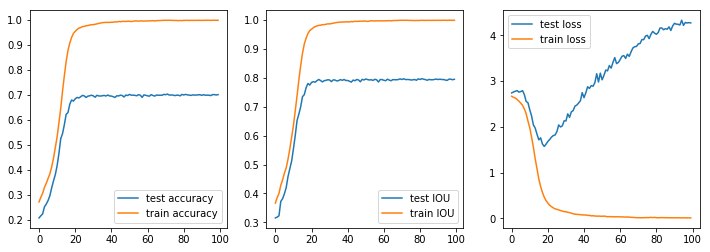

---------------------------------------------------------------------------------------------------- 

Train accuracy:1.000
Test accuracy:0.722
Train IOU:1.000
Test IOU:0.811
Train loss loss:0.002
Test loss loss:1.749


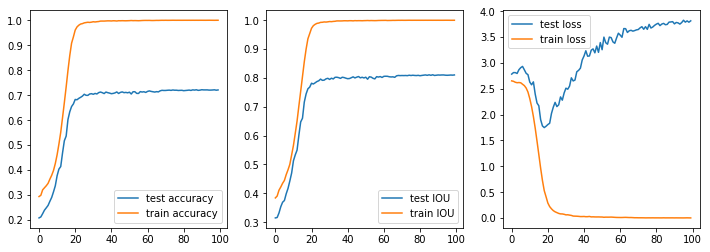

---------------------------------------------------------------------------------------------------- 

Train accuracy:1.000
Test accuracy:0.723
Train IOU:1.000
Test IOU:0.813
Train loss loss:0.002
Test loss loss:1.885


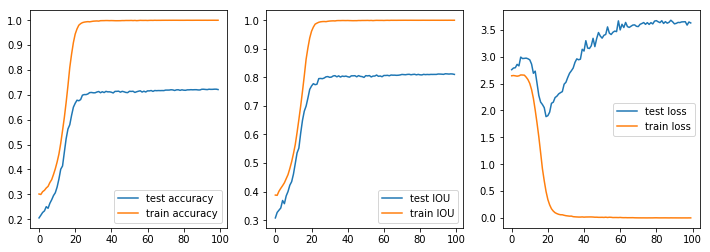

---------------------------------------------------------------------------------------------------- 



In [18]:
f = stats(BN_tst, BN_trn, ephocs=100, params=[50, 100, 150])

In [17]:
np.save(open('../data/training/results/toNoteBN__tst.bin', 'wb'), BN_tst)
np.save(open('../data/training/results/toNoteBN__trn.bin', 'wb'), BN_trn)